<a href="https://colab.research.google.com/github/sawesky/deep-stegano/blob/main/Diplomski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2023-05-24 00:23:34--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  38.8MB/s    in 7.8s    

2023-05-24 00:23:42 (30.4 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
!unzip /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [ ]:
!pip install Keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.utils as image #mora da se doda da prekrsi preprocessing image 
import keras.backend as K

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [ ]:
### Constants ###
DATA_DIR = "./tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [ ]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)


In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [ ]:
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

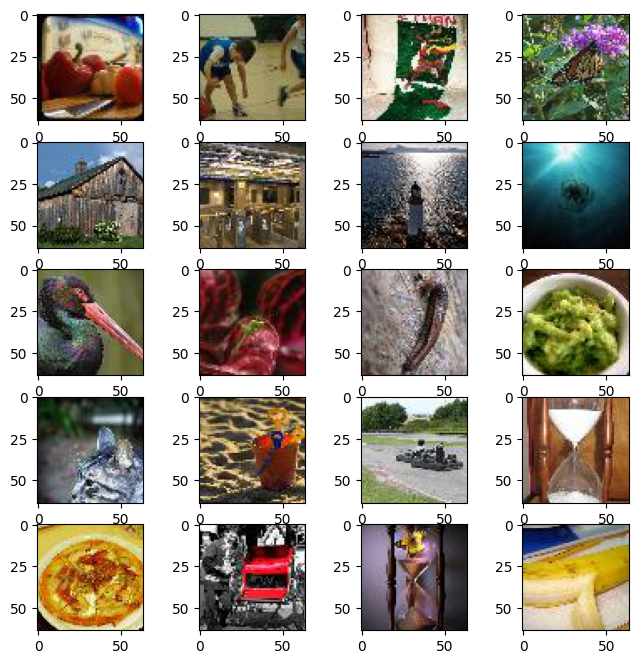

In [ ]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [21]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    loss = beta * tf.reduce_sum(tf.square(s_true - s_pred))
    return loss

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = beta * tf.reduce_sum(tf.square(s_true - s_pred))  # Call rev_loss as a function
    c_loss = tf.reduce_sum(tf.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(reveal_input)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(reveal_input)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(reveal_input)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder
 

In [22]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [23]:
NB_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
K.set_value(autoencoder_model.optimizer.lr,lr)
K.set_value(reveal_model.optimizer.lr,lr)
m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        aeloss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3))
        ae_loss.append(aeloss)

        revloss = reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S)
        rev_loss.append(revloss)
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 277ms/step


Epoch 1 | Batch:   0 of 1000. Loss AE  176163.36 | Loss Rev   85640.50:   3%|▎         | 1/32 [00:13<07:11, 13.93s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch:  32 of 1000. Loss AE  408683.37 | Loss Rev  288427.22:   6%|▋         | 2/32 [00:14<02:55,  5.84s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch:  64 of 1000. Loss AE  322442.52 | Loss Rev  217151.68:   9%|▉         | 3/32 [00:14<01:34,  3.25s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch:  96 of 1000. Loss AE  284967.20 | Loss Rev  188207.16:  12%|█▎        | 4/32 [00:14<00:56,  2.02s/it]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 128 of 1000. Loss AE  264756.13 | Loss Rev  169902.15:  16%|█▌        | 5/32 [00:14<00:36,  1.35s/it]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 160 of 1000. Loss AE  248041.69 | Loss Rev  157331.68:  19%|█▉        | 6/32 [00:14<00:24,  1.06it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 192 of 1000. Loss AE  228809.36 | Loss Rev  143956.24:  22%|██▏       | 7/32 [00:14<00:17,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 1 | Batch: 224 of 1000. Loss AE  216528.66 | Loss Rev  137324.91:  25%|██▌       | 8/32 [00:15<00:12,  1.94it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 1 | Batch: 256 of 1000. Loss AE  204840.87 | Loss Rev  129318.81:  28%|██▊       | 9/32 [00:15<00:09,  2.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 288 of 1000. Loss AE  193484.04 | Loss Rev  121455.72:  31%|███▏      | 10/32 [00:15<00:07,  3.06it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 320 of 1000. Loss AE  184382.07 | Loss Rev  114325.63:  34%|███▍      | 11/32 [00:15<00:05,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 352 of 1000. Loss AE  174887.38 | Loss Rev  107679.95:  38%|███▊      | 12/32 [00:15<00:04,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 384 of 1000. Loss AE  166709.16 | Loss Rev  101742.04:  41%|████      | 13/32 [00:15<00:04,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 416 of 1000. Loss AE  161299.22 | Loss Rev   97548.32:  44%|████▍     | 14/32 [00:15<00:03,  5.18it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 1 | Batch: 448 of 1000. Loss AE  156091.89 | Loss Rev   93108.81:  47%|████▋     | 15/32 [00:16<00:03,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 1 | Batch: 480 of 1000. Loss AE  151095.69 | Loss Rev   89184.52:  50%|█████     | 16/32 [00:16<00:02,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 512 of 1000. Loss AE  146573.75 | Loss Rev   85940.05:  53%|█████▎    | 17/32 [00:16<00:02,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 544 of 1000. Loss AE  142757.18 | Loss Rev   82834.38:  56%|█████▋    | 18/32 [00:16<00:02,  6.10it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 576 of 1000. Loss AE  139282.42 | Loss Rev   79903.58:  59%|█████▉    | 19/32 [00:16<00:02,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 608 of 1000. Loss AE  136640.02 | Loss Rev   77724.17:  62%|██████▎   | 20/32 [00:16<00:01,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 1 | Batch: 640 of 1000. Loss AE  133705.75 | Loss Rev   75335.29:  66%|██████▌   | 21/32 [00:17<00:01,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 1 | Batch: 672 of 1000. Loss AE  130831.11 | Loss Rev   73131.60:  69%|██████▉   | 22/32 [00:17<00:01,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 1 | Batch: 704 of 1000. Loss AE  127936.19 | Loss Rev   70995.88:  72%|███████▏  | 23/32 [00:17<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 1 | Batch: 736 of 1000. Loss AE  125636.05 | Loss Rev   69010.28:  75%|███████▌  | 24/32 [00:17<00:01,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 768 of 1000. Loss AE  123357.61 | Loss Rev   67228.91:  78%|███████▊  | 25/32 [00:17<00:01,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 800 of 1000. Loss AE  121331.91 | Loss Rev   65547.44:  81%|████████▏ | 26/32 [00:17<00:00,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 832 of 1000. Loss AE  119464.00 | Loss Rev   63991.24:  84%|████████▍ | 27/32 [00:17<00:00,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 864 of 1000. Loss AE  117743.03 | Loss Rev   62456.04:  88%|████████▊ | 28/32 [00:18<00:00,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 1 | Batch: 896 of 1000. Loss AE  115968.71 | Loss Rev   60987.37:  91%|█████████ | 29/32 [00:18<00:00,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 1 | Batch: 928 of 1000. Loss AE  114474.52 | Loss Rev   59643.84:  94%|█████████▍| 30/32 [00:18<00:00,  6.55it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 1 | Batch: 960 of 1000. Loss AE  112934.50 | Loss Rev   58348.29:  97%|█████████▋| 31/32 [00:18<00:00,  6.48it/s]

1/1 [==============================] - 0s 202ms/step


Epoch 1 | Batch: 992 of 1000. Loss AE  110003.18 | Loss Rev   56705.37: 100%|██████████| 32/32 [00:20<00:00,  1.52it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch:   0 of 1000. Loss AE   63094.17 | Loss Rev   18948.80:   3%|▎         | 1/32 [00:00<00:05,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch:  32 of 1000. Loss AE   66737.60 | Loss Rev   19821.45:   6%|▋         | 2/32 [00:00<00:04,  6.05it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch:  64 of 1000. Loss AE   65588.29 | Loss Rev   19090.89:   9%|▉         | 3/32 [00:00<00:04,  6.19it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch:  96 of 1000. Loss AE   65246.23 | Loss Rev   19551.76:  12%|█▎        | 4/32 [00:00<00:04,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 128 of 1000. Loss AE   65608.87 | Loss Rev   19592.12:  16%|█▌        | 5/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 160 of 1000. Loss AE   66288.95 | Loss Rev   19744.52:  19%|█▉        | 6/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2 | Batch: 192 of 1000. Loss AE   65123.27 | Loss Rev   19543.07:  22%|██▏       | 7/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 224 of 1000. Loss AE   64693.38 | Loss Rev   19354.13:  25%|██▌       | 8/32 [00:01<00:03,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 256 of 1000. Loss AE   64329.31 | Loss Rev   19280.74:  28%|██▊       | 9/32 [00:01<00:03,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 288 of 1000. Loss AE   65352.81 | Loss Rev   19593.86:  31%|███▏      | 10/32 [00:01<00:03,  6.51it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2 | Batch: 320 of 1000. Loss AE   65394.55 | Loss Rev   19413.10:  34%|███▍      | 11/32 [00:01<00:03,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 352 of 1000. Loss AE   64870.66 | Loss Rev   19263.29:  38%|███▊      | 12/32 [00:01<00:03,  6.55it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2 | Batch: 384 of 1000. Loss AE   64581.88 | Loss Rev   19398.85:  41%|████      | 13/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2 | Batch: 416 of 1000. Loss AE   64281.60 | Loss Rev   19227.71:  44%|████▍     | 14/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 448 of 1000. Loss AE   64573.36 | Loss Rev   19238.24:  47%|████▋     | 15/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 480 of 1000. Loss AE   64094.54 | Loss Rev   19077.97:  50%|█████     | 16/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 512 of 1000. Loss AE   63705.16 | Loss Rev   18888.97:  53%|█████▎    | 17/32 [00:02<00:02,  6.52it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 2 | Batch: 544 of 1000. Loss AE   63803.65 | Loss Rev   18832.74:  56%|█████▋    | 18/32 [00:02<00:02,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 576 of 1000. Loss AE   63600.95 | Loss Rev   18820.19:  59%|█████▉    | 19/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2 | Batch: 608 of 1000. Loss AE   63410.05 | Loss Rev   18766.39:  62%|██████▎   | 20/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2 | Batch: 640 of 1000. Loss AE   63171.36 | Loss Rev   18747.86:  66%|██████▌   | 21/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 672 of 1000. Loss AE   63383.81 | Loss Rev   18698.94:  69%|██████▉   | 22/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2 | Batch: 704 of 1000. Loss AE   63427.96 | Loss Rev   18659.74:  72%|███████▏  | 23/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 2 | Batch: 736 of 1000. Loss AE   63440.98 | Loss Rev   18542.80:  75%|███████▌  | 24/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 768 of 1000. Loss AE   63382.54 | Loss Rev   18504.91:  78%|███████▊  | 25/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 800 of 1000. Loss AE   63453.78 | Loss Rev   18457.81:  81%|████████▏ | 26/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 832 of 1000. Loss AE   63310.64 | Loss Rev   18407.40:  84%|████████▍ | 27/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 864 of 1000. Loss AE   63203.67 | Loss Rev   18393.81:  88%|████████▊ | 28/32 [00:04<00:00,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 896 of 1000. Loss AE   63246.88 | Loss Rev   18333.54:  91%|█████████ | 29/32 [00:04<00:00,  6.52it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 2 | Batch: 928 of 1000. Loss AE   63261.88 | Loss Rev   18236.45:  94%|█████████▍| 30/32 [00:04<00:00,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 2 | Batch: 960 of 1000. Loss AE   63533.46 | Loss Rev   18177.15:  97%|█████████▋| 31/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 2 | Batch: 992 of 1000. Loss AE   61946.80 | Loss Rev   17710.77: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch:   0 of 1000. Loss AE   66731.66 | Loss Rev   16750.30:   3%|▎         | 1/32 [00:00<00:04,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch:  32 of 1000. Loss AE   66832.81 | Loss Rev   16515.14:   6%|▋         | 2/32 [00:00<00:04,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch:  64 of 1000. Loss AE   66783.63 | Loss Rev   16397.07:   9%|▉         | 3/32 [00:00<00:04,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch:  96 of 1000. Loss AE   65460.80 | Loss Rev   15965.86:  12%|█▎        | 4/32 [00:00<00:04,  6.57it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 128 of 1000. Loss AE   64526.83 | Loss Rev   15869.28:  16%|█▌        | 5/32 [00:00<00:04,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 160 of 1000. Loss AE   63799.44 | Loss Rev   15601.85:  19%|█▉        | 6/32 [00:00<00:03,  6.57it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 3 | Batch: 192 of 1000. Loss AE   63378.02 | Loss Rev   15501.99:  22%|██▏       | 7/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 224 of 1000. Loss AE   63195.82 | Loss Rev   15318.17:  25%|██▌       | 8/32 [00:01<00:03,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 256 of 1000. Loss AE   62661.88 | Loss Rev   15285.26:  28%|██▊       | 9/32 [00:01<00:03,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 288 of 1000. Loss AE   61971.31 | Loss Rev   15174.86:  31%|███▏      | 10/32 [00:01<00:03,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 320 of 1000. Loss AE   61615.15 | Loss Rev   15337.83:  34%|███▍      | 11/32 [00:01<00:03,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 352 of 1000. Loss AE   61145.34 | Loss Rev   15178.32:  38%|███▊      | 12/32 [00:01<00:03,  6.58it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 384 of 1000. Loss AE   60654.69 | Loss Rev   15297.42:  41%|████      | 13/32 [00:01<00:02,  6.58it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 3 | Batch: 416 of 1000. Loss AE   61057.06 | Loss Rev   16067.45:  44%|████▍     | 14/32 [00:02<00:02,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 448 of 1000. Loss AE   60458.60 | Loss Rev   15909.31:  47%|████▋     | 15/32 [00:02<00:02,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 480 of 1000. Loss AE   61946.77 | Loss Rev   17713.25:  50%|█████     | 16/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 3 | Batch: 512 of 1000. Loss AE   62605.11 | Loss Rev   18846.62:  53%|█████▎    | 17/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 544 of 1000. Loss AE   64651.19 | Loss Rev   21309.85:  56%|█████▋    | 18/32 [00:02<00:02,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 576 of 1000. Loss AE   65968.16 | Loss Rev   22909.87:  59%|█████▉    | 19/32 [00:02<00:01,  6.58it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 608 of 1000. Loss AE   66399.65 | Loss Rev   23525.52:  62%|██████▎   | 20/32 [00:03<00:01,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 640 of 1000. Loss AE   66139.35 | Loss Rev   23541.48:  66%|██████▌   | 21/32 [00:03<00:01,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 672 of 1000. Loss AE   66948.40 | Loss Rev   24318.90:  69%|██████▉   | 22/32 [00:03<00:01,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 704 of 1000. Loss AE   67061.72 | Loss Rev   24397.89:  72%|███████▏  | 23/32 [00:03<00:01,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 736 of 1000. Loss AE   66704.42 | Loss Rev   24128.27:  75%|███████▌  | 24/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 3 | Batch: 768 of 1000. Loss AE   66686.27 | Loss Rev   23965.35:  78%|███████▊  | 25/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 800 of 1000. Loss AE   66782.73 | Loss Rev   23779.79:  81%|████████▏ | 26/32 [00:03<00:00,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 832 of 1000. Loss AE   67071.24 | Loss Rev   23362.26:  84%|████████▍ | 27/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 864 of 1000. Loss AE   67245.60 | Loss Rev   22911.15:  88%|████████▊ | 28/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 3 | Batch: 896 of 1000. Loss AE   67103.41 | Loss Rev   22539.30:  91%|█████████ | 29/32 [00:04<00:00,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 928 of 1000. Loss AE   67091.34 | Loss Rev   22323.82:  94%|█████████▍| 30/32 [00:04<00:00,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 3 | Batch: 960 of 1000. Loss AE   66935.31 | Loss Rev   22073.64:  97%|█████████▋| 31/32 [00:04<00:00,  6.55it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 3 | Batch: 992 of 1000. Loss AE   65407.58 | Loss Rev   21517.60: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 4 | Batch:   0 of 1000. Loss AE   60780.40 | Loss Rev   15774.15:   3%|▎         | 1/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 4 | Batch:  32 of 1000. Loss AE   60310.41 | Loss Rev   15445.37:   6%|▋         | 2/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch:  64 of 1000. Loss AE   59389.34 | Loss Rev   15273.01:   9%|▉         | 3/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch:  96 of 1000. Loss AE   59308.91 | Loss Rev   15303.37:  12%|█▎        | 4/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 128 of 1000. Loss AE   58384.00 | Loss Rev   15292.55:  16%|█▌        | 5/32 [00:00<00:04,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 160 of 1000. Loss AE   57844.67 | Loss Rev   14970.27:  19%|█▉        | 6/32 [00:00<00:03,  6.58it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 192 of 1000. Loss AE   57794.60 | Loss Rev   14753.80:  22%|██▏       | 7/32 [00:01<00:03,  6.61it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 224 of 1000. Loss AE   56453.56 | Loss Rev   14291.23:  25%|██▌       | 8/32 [00:01<00:03,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 256 of 1000. Loss AE   56027.27 | Loss Rev   14246.67:  28%|██▊       | 9/32 [00:01<00:03,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 288 of 1000. Loss AE   55935.28 | Loss Rev   14056.06:  31%|███▏      | 10/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 320 of 1000. Loss AE   55822.63 | Loss Rev   13869.55:  34%|███▍      | 11/32 [00:01<00:03,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 352 of 1000. Loss AE   55375.83 | Loss Rev   13654.05:  38%|███▊      | 12/32 [00:01<00:03,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 384 of 1000. Loss AE   55078.13 | Loss Rev   13400.88:  41%|████      | 13/32 [00:02<00:02,  6.54it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 4 | Batch: 416 of 1000. Loss AE   55054.07 | Loss Rev   13423.41:  44%|████▍     | 14/32 [00:02<00:02,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 448 of 1000. Loss AE   54699.98 | Loss Rev   13227.49:  47%|████▋     | 15/32 [00:02<00:02,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 480 of 1000. Loss AE   54161.82 | Loss Rev   13025.04:  50%|█████     | 16/32 [00:02<00:02,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 512 of 1000. Loss AE   53731.97 | Loss Rev   12939.25:  53%|█████▎    | 17/32 [00:02<00:02,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 544 of 1000. Loss AE   53515.13 | Loss Rev   12903.08:  56%|█████▋    | 18/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 576 of 1000. Loss AE   52982.27 | Loss Rev   12757.93:  59%|█████▉    | 19/32 [00:02<00:01,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 608 of 1000. Loss AE   53067.85 | Loss Rev   12789.84:  62%|██████▎   | 20/32 [00:03<00:01,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 640 of 1000. Loss AE   53023.48 | Loss Rev   12941.74:  66%|██████▌   | 21/32 [00:03<00:01,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 672 of 1000. Loss AE   53018.63 | Loss Rev   12958.29:  69%|██████▉   | 22/32 [00:03<00:01,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 704 of 1000. Loss AE   53132.46 | Loss Rev   13212.72:  72%|███████▏  | 23/32 [00:03<00:01,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 736 of 1000. Loss AE   53458.59 | Loss Rev   13713.22:  75%|███████▌  | 24/32 [00:03<00:01,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 768 of 1000. Loss AE   53529.84 | Loss Rev   14020.24:  78%|███████▊  | 25/32 [00:03<00:01,  6.55it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 4 | Batch: 800 of 1000. Loss AE   53508.38 | Loss Rev   14047.69:  81%|████████▏ | 26/32 [00:03<00:00,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 832 of 1000. Loss AE   53711.59 | Loss Rev   14282.05:  84%|████████▍ | 27/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 864 of 1000. Loss AE   53360.60 | Loss Rev   14175.86:  88%|████████▊ | 28/32 [00:04<00:00,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 896 of 1000. Loss AE   53416.41 | Loss Rev   14323.53:  91%|█████████ | 29/32 [00:04<00:00,  6.56it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 928 of 1000. Loss AE   53283.58 | Loss Rev   14288.78:  94%|█████████▍| 30/32 [00:04<00:00,  6.59it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 4 | Batch: 960 of 1000. Loss AE   53497.87 | Loss Rev   14296.28:  97%|█████████▋| 31/32 [00:04<00:00,  6.60it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 4 | Batch: 992 of 1000. Loss AE   52157.99 | Loss Rev   13916.65: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch:   0 of 1000. Loss AE   48086.73 | Loss Rev    9635.93:   3%|▎         | 1/32 [00:00<00:04,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch:  32 of 1000. Loss AE   48998.85 | Loss Rev   10111.08:   6%|▋         | 2/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch:  64 of 1000. Loss AE   49244.21 | Loss Rev   10070.21:   9%|▉         | 3/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch:  96 of 1000. Loss AE   48545.82 | Loss Rev   10237.76:  12%|█▎        | 4/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 128 of 1000. Loss AE   48591.56 | Loss Rev   10160.59:  16%|█▌        | 5/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 160 of 1000. Loss AE   49410.69 | Loss Rev   10294.04:  19%|█▉        | 6/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 192 of 1000. Loss AE   48944.24 | Loss Rev   10214.32:  22%|██▏       | 7/32 [00:01<00:03,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 224 of 1000. Loss AE   48772.55 | Loss Rev   10318.47:  25%|██▌       | 8/32 [00:01<00:03,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 256 of 1000. Loss AE   48202.33 | Loss Rev   10149.70:  28%|██▊       | 9/32 [00:01<00:03,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 288 of 1000. Loss AE   47508.84 | Loss Rev   10134.01:  31%|███▏      | 10/32 [00:01<00:03,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 320 of 1000. Loss AE   47614.81 | Loss Rev   10024.10:  34%|███▍      | 11/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 352 of 1000. Loss AE   47971.86 | Loss Rev   10008.07:  38%|███▊      | 12/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5 | Batch: 384 of 1000. Loss AE   47088.32 | Loss Rev   10009.92:  41%|████      | 13/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 416 of 1000. Loss AE   47144.70 | Loss Rev    9943.86:  44%|████▍     | 14/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 448 of 1000. Loss AE   47188.18 | Loss Rev   10028.11:  47%|████▋     | 15/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 480 of 1000. Loss AE   46811.24 | Loss Rev    9959.78:  50%|█████     | 16/32 [00:02<00:02,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 512 of 1000. Loss AE   47083.86 | Loss Rev   10000.49:  53%|█████▎    | 17/32 [00:02<00:02,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 544 of 1000. Loss AE   47056.57 | Loss Rev    9895.93:  56%|█████▋    | 18/32 [00:02<00:02,  6.57it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 5 | Batch: 576 of 1000. Loss AE   47232.57 | Loss Rev    9956.27:  59%|█████▉    | 19/32 [00:02<00:02,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 608 of 1000. Loss AE   47092.95 | Loss Rev    9875.29:  62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 640 of 1000. Loss AE   46931.14 | Loss Rev    9827.64:  66%|██████▌   | 21/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 5 | Batch: 672 of 1000. Loss AE   46712.64 | Loss Rev    9736.31:  69%|██████▉   | 22/32 [00:03<00:01,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 704 of 1000. Loss AE   46716.27 | Loss Rev    9760.50:  72%|███████▏  | 23/32 [00:03<00:01,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 736 of 1000. Loss AE   46892.17 | Loss Rev    9751.19:  75%|███████▌  | 24/32 [00:03<00:01,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 768 of 1000. Loss AE   47013.76 | Loss Rev    9720.27:  78%|███████▊  | 25/32 [00:03<00:01,  6.59it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 800 of 1000. Loss AE   47103.11 | Loss Rev    9643.15:  81%|████████▏ | 26/32 [00:04<00:00,  6.60it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 832 of 1000. Loss AE   47034.37 | Loss Rev    9581.44:  84%|████████▍ | 27/32 [00:04<00:00,  6.60it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 864 of 1000. Loss AE   46875.54 | Loss Rev    9520.81:  88%|████████▊ | 28/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 896 of 1000. Loss AE   46755.17 | Loss Rev    9460.67:  91%|█████████ | 29/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 928 of 1000. Loss AE   46396.90 | Loss Rev    9369.06:  94%|█████████▍| 30/32 [00:04<00:00,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 5 | Batch: 960 of 1000. Loss AE   46161.43 | Loss Rev    9360.01:  97%|█████████▋| 31/32 [00:04<00:00,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 5 | Batch: 992 of 1000. Loss AE   45049.94 | Loss Rev    9159.12: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch:   0 of 1000. Loss AE   49957.71 | Loss Rev   10110.12:   3%|▎         | 1/32 [00:00<00:04,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch:  32 of 1000. Loss AE   46422.74 | Loss Rev    9326.39:   6%|▋         | 2/32 [00:00<00:04,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch:  64 of 1000. Loss AE   45897.50 | Loss Rev    9271.67:   9%|▉         | 3/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch:  96 of 1000. Loss AE   48301.41 | Loss Rev   10132.28:  12%|█▎        | 4/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 128 of 1000. Loss AE   48753.12 | Loss Rev   11486.88:  16%|█▌        | 5/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 6 | Batch: 160 of 1000. Loss AE   49052.06 | Loss Rev   11378.19:  19%|█▉        | 6/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 192 of 1000. Loss AE   47952.38 | Loss Rev   10902.96:  22%|██▏       | 7/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 224 of 1000. Loss AE   48538.06 | Loss Rev   11124.18:  25%|██▌       | 8/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 256 of 1000. Loss AE   48260.47 | Loss Rev   10869.25:  28%|██▊       | 9/32 [00:01<00:03,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 288 of 1000. Loss AE   47366.32 | Loss Rev   10595.12:  31%|███▏      | 10/32 [00:01<00:03,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 320 of 1000. Loss AE   46969.10 | Loss Rev   10425.25:  34%|███▍      | 11/32 [00:01<00:03,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 352 of 1000. Loss AE   46312.26 | Loss Rev   10275.69:  38%|███▊      | 12/32 [00:01<00:03,  6.57it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 384 of 1000. Loss AE   46202.71 | Loss Rev   10290.59:  41%|████      | 13/32 [00:01<00:02,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 416 of 1000. Loss AE   46303.44 | Loss Rev   10172.73:  44%|████▍     | 14/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 448 of 1000. Loss AE   46157.10 | Loss Rev   10052.07:  47%|████▋     | 15/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 480 of 1000. Loss AE   45702.15 | Loss Rev    9944.08:  50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 512 of 1000. Loss AE   45833.10 | Loss Rev    9928.65:  53%|█████▎    | 17/32 [00:02<00:02,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 544 of 1000. Loss AE   45809.32 | Loss Rev    9832.42:  56%|█████▋    | 18/32 [00:02<00:02,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 576 of 1000. Loss AE   45381.98 | Loss Rev    9755.90:  59%|█████▉    | 19/32 [00:02<00:01,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 608 of 1000. Loss AE   45085.84 | Loss Rev    9704.58:  62%|██████▎   | 20/32 [00:03<00:01,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 640 of 1000. Loss AE   44711.37 | Loss Rev    9589.10:  66%|██████▌   | 21/32 [00:03<00:01,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 672 of 1000. Loss AE   44532.51 | Loss Rev    9471.13:  69%|██████▉   | 22/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 704 of 1000. Loss AE   44565.03 | Loss Rev    9356.03:  72%|███████▏  | 23/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 736 of 1000. Loss AE   44681.28 | Loss Rev    9268.37:  75%|███████▌  | 24/32 [00:03<00:01,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 768 of 1000. Loss AE   44563.99 | Loss Rev    9246.13:  78%|███████▊  | 25/32 [00:03<00:01,  6.53it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 6 | Batch: 800 of 1000. Loss AE   44329.66 | Loss Rev    9142.01:  81%|████████▏ | 26/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 832 of 1000. Loss AE   44379.64 | Loss Rev    9093.29:  84%|████████▍ | 27/32 [00:04<00:00,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 864 of 1000. Loss AE   44373.46 | Loss Rev    9066.15:  88%|████████▊ | 28/32 [00:04<00:00,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 896 of 1000. Loss AE   44437.26 | Loss Rev    9045.00:  91%|█████████ | 29/32 [00:04<00:00,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 928 of 1000. Loss AE   44240.49 | Loss Rev    8949.95:  94%|█████████▍| 30/32 [00:04<00:00,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 6 | Batch: 960 of 1000. Loss AE   44375.06 | Loss Rev    8913.96:  97%|█████████▋| 31/32 [00:04<00:00,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 6 | Batch: 992 of 1000. Loss AE   43362.58 | Loss Rev    8699.81: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch:   0 of 1000. Loss AE   50873.12 | Loss Rev    8193.69:   3%|▎         | 1/32 [00:00<00:04,  6.59it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch:  32 of 1000. Loss AE   43455.17 | Loss Rev    8271.59:   6%|▋         | 2/32 [00:00<00:04,  6.61it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch:  64 of 1000. Loss AE   43948.63 | Loss Rev    8379.61:   9%|▉         | 3/32 [00:00<00:04,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch:  96 of 1000. Loss AE   44729.77 | Loss Rev    8468.61:  12%|█▎        | 4/32 [00:00<00:04,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 128 of 1000. Loss AE   44872.36 | Loss Rev    8237.23:  16%|█▌        | 5/32 [00:00<00:04,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 160 of 1000. Loss AE   44943.60 | Loss Rev    8187.56:  19%|█▉        | 6/32 [00:00<00:03,  6.56it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 192 of 1000. Loss AE   44684.00 | Loss Rev    8038.65:  22%|██▏       | 7/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 7 | Batch: 224 of 1000. Loss AE   45317.07 | Loss Rev    7982.00:  25%|██▌       | 8/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 256 of 1000. Loss AE   44658.66 | Loss Rev    8183.79:  28%|██▊       | 9/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 288 of 1000. Loss AE   44175.67 | Loss Rev    8115.89:  31%|███▏      | 10/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 320 of 1000. Loss AE   43616.88 | Loss Rev    8022.09:  34%|███▍      | 11/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 352 of 1000. Loss AE   43796.42 | Loss Rev    7981.29:  38%|███▊      | 12/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 384 of 1000. Loss AE   43446.30 | Loss Rev    8033.40:  41%|████      | 13/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 416 of 1000. Loss AE   43568.18 | Loss Rev    8082.01:  44%|████▍     | 14/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 448 of 1000. Loss AE   43317.52 | Loss Rev    8089.23:  47%|████▋     | 15/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 7 | Batch: 480 of 1000. Loss AE   43091.63 | Loss Rev    8085.91:  50%|█████     | 16/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 512 of 1000. Loss AE   43232.91 | Loss Rev    8089.36:  53%|█████▎    | 17/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 544 of 1000. Loss AE   43275.12 | Loss Rev    8076.28:  56%|█████▋    | 18/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 576 of 1000. Loss AE   43080.54 | Loss Rev    8015.62:  59%|█████▉    | 19/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 608 of 1000. Loss AE   43148.28 | Loss Rev    8074.54:  62%|██████▎   | 20/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 640 of 1000. Loss AE   43286.07 | Loss Rev    8077.48:  66%|██████▌   | 21/32 [00:03<00:01,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 672 of 1000. Loss AE   43329.76 | Loss Rev    8121.19:  69%|██████▉   | 22/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 7 | Batch: 704 of 1000. Loss AE   43439.29 | Loss Rev    8207.30:  72%|███████▏  | 23/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 736 of 1000. Loss AE   43510.17 | Loss Rev    8253.53:  75%|███████▌  | 24/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 768 of 1000. Loss AE   43575.89 | Loss Rev    8464.12:  78%|███████▊  | 25/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 800 of 1000. Loss AE   43452.29 | Loss Rev    8435.88:  81%|████████▏ | 26/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 832 of 1000. Loss AE   43095.32 | Loss Rev    8413.31:  84%|████████▍ | 27/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 864 of 1000. Loss AE   42928.38 | Loss Rev    8858.36:  88%|████████▊ | 28/32 [00:04<00:00,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 896 of 1000. Loss AE   42527.00 | Loss Rev    9159.41:  91%|█████████ | 29/32 [00:04<00:00,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 7 | Batch: 928 of 1000. Loss AE   42083.81 | Loss Rev    9536.21:  94%|█████████▍| 30/32 [00:04<00:00,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 960 of 1000. Loss AE   41302.97 | Loss Rev    9547.76:  97%|█████████▋| 31/32 [00:04<00:00,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 7 | Batch: 992 of 1000. Loss AE   40246.08 | Loss Rev    9411.86: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8 | Batch:   0 of 1000. Loss AE   35970.05 | Loss Rev   24579.50:   3%|▎         | 1/32 [00:00<00:04,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch:  32 of 1000. Loss AE   34349.82 | Loss Rev   23709.91:   6%|▋         | 2/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch:  64 of 1000. Loss AE   40275.95 | Loss Rev   30180.89:   9%|▉         | 3/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch:  96 of 1000. Loss AE   39783.90 | Loss Rev   29969.81:  12%|█▎        | 4/32 [00:00<00:04,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 128 of 1000. Loss AE   36330.70 | Loss Rev   26464.92:  16%|█▌        | 5/32 [00:00<00:04,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 160 of 1000. Loss AE   36662.41 | Loss Rev   27129.39:  19%|█▉        | 6/32 [00:00<00:03,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 192 of 1000. Loss AE   34873.41 | Loss Rev   24587.87:  22%|██▏       | 7/32 [00:01<00:03,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 224 of 1000. Loss AE   34517.85 | Loss Rev   23279.47:  25%|██▌       | 8/32 [00:01<00:03,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 256 of 1000. Loss AE   33774.65 | Loss Rev   22275.02:  28%|██▊       | 9/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8 | Batch: 288 of 1000. Loss AE   32580.75 | Loss Rev   21169.25:  31%|███▏      | 10/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 320 of 1000. Loss AE   31627.17 | Loss Rev   20112.32:  34%|███▍      | 11/32 [00:01<00:03,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 352 of 1000. Loss AE   31520.81 | Loss Rev   19625.09:  38%|███▊      | 12/32 [00:01<00:03,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 384 of 1000. Loss AE   30643.04 | Loss Rev   18846.56:  41%|████      | 13/32 [00:01<00:02,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 416 of 1000. Loss AE   30175.72 | Loss Rev   18454.98:  44%|████▍     | 14/32 [00:02<00:02,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 448 of 1000. Loss AE   29766.25 | Loss Rev   18000.96:  47%|████▋     | 15/32 [00:02<00:02,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 480 of 1000. Loss AE   29319.96 | Loss Rev   17522.62:  50%|█████     | 16/32 [00:02<00:02,  6.52it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8 | Batch: 512 of 1000. Loss AE   28929.16 | Loss Rev   17230.95:  53%|█████▎    | 17/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8 | Batch: 544 of 1000. Loss AE   28423.84 | Loss Rev   16833.88:  56%|█████▋    | 18/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 576 of 1000. Loss AE   28049.56 | Loss Rev   16571.49:  59%|█████▉    | 19/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 608 of 1000. Loss AE   27626.64 | Loss Rev   16288.18:  62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 640 of 1000. Loss AE   27140.66 | Loss Rev   16019.34:  66%|██████▌   | 21/32 [00:03<00:01,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 672 of 1000. Loss AE   26785.17 | Loss Rev   15836.45:  69%|██████▉   | 22/32 [00:03<00:01,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 704 of 1000. Loss AE   26360.92 | Loss Rev   15514.97:  72%|███████▏  | 23/32 [00:03<00:01,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 736 of 1000. Loss AE   25918.57 | Loss Rev   15191.18:  75%|███████▌  | 24/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 768 of 1000. Loss AE   25514.23 | Loss Rev   14941.23:  78%|███████▊  | 25/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 8 | Batch: 800 of 1000. Loss AE   25086.41 | Loss Rev   14651.53:  81%|████████▏ | 26/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 8 | Batch: 832 of 1000. Loss AE   24805.73 | Loss Rev   14498.94:  84%|████████▍ | 27/32 [00:04<00:00,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 864 of 1000. Loss AE   24471.03 | Loss Rev   14278.95:  88%|████████▊ | 28/32 [00:04<00:00,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 896 of 1000. Loss AE   24203.47 | Loss Rev   14160.75:  91%|█████████ | 29/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 928 of 1000. Loss AE   23939.10 | Loss Rev   14006.21:  94%|█████████▍| 30/32 [00:04<00:00,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 8 | Batch: 960 of 1000. Loss AE   23691.54 | Loss Rev   13828.93:  97%|█████████▋| 31/32 [00:04<00:00,  6.50it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 8 | Batch: 992 of 1000. Loss AE   23061.10 | Loss Rev   13463.31: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch:   0 of 1000. Loss AE   16005.28 | Loss Rev    9065.47:   3%|▎         | 1/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch:  32 of 1000. Loss AE   14337.93 | Loss Rev    8421.23:   6%|▋         | 2/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9 | Batch:  64 of 1000. Loss AE   14348.22 | Loss Rev    8120.42:   9%|▉         | 3/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch:  96 of 1000. Loss AE   14314.33 | Loss Rev    8020.68:  12%|█▎        | 4/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 128 of 1000. Loss AE   14610.26 | Loss Rev    8521.36:  16%|█▌        | 5/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 160 of 1000. Loss AE   14625.95 | Loss Rev    8664.71:  19%|█▉        | 6/32 [00:00<00:04,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 192 of 1000. Loss AE   15034.22 | Loss Rev    8960.34:  22%|██▏       | 7/32 [00:01<00:03,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 224 of 1000. Loss AE   15089.09 | Loss Rev    8952.78:  25%|██▌       | 8/32 [00:01<00:03,  6.51it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9 | Batch: 256 of 1000. Loss AE   14895.62 | Loss Rev    8798.87:  28%|██▊       | 9/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 288 of 1000. Loss AE   14798.96 | Loss Rev    8648.31:  31%|███▏      | 10/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 320 of 1000. Loss AE   14716.07 | Loss Rev    8548.66:  34%|███▍      | 11/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 352 of 1000. Loss AE   14547.77 | Loss Rev    8390.98:  38%|███▊      | 12/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 384 of 1000. Loss AE   14405.75 | Loss Rev    8299.47:  41%|████      | 13/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 416 of 1000. Loss AE   14324.88 | Loss Rev    8252.57:  44%|████▍     | 14/32 [00:02<00:02,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 448 of 1000. Loss AE   14297.60 | Loss Rev    8254.72:  47%|████▋     | 15/32 [00:02<00:02,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 480 of 1000. Loss AE   14254.23 | Loss Rev    8267.75:  50%|█████     | 16/32 [00:02<00:02,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 512 of 1000. Loss AE   14324.42 | Loss Rev    8348.69:  53%|█████▎    | 17/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 544 of 1000. Loss AE   14144.35 | Loss Rev    8260.06:  56%|█████▋    | 18/32 [00:02<00:02,  6.52it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 9 | Batch: 576 of 1000. Loss AE   14079.24 | Loss Rev    8262.15:  59%|█████▉    | 19/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 608 of 1000. Loss AE   14048.35 | Loss Rev    8253.38:  62%|██████▎   | 20/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 9 | Batch: 640 of 1000. Loss AE   13899.08 | Loss Rev    8139.08:  66%|██████▌   | 21/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 672 of 1000. Loss AE   13839.88 | Loss Rev    8104.84:  69%|██████▉   | 22/32 [00:03<00:01,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 704 of 1000. Loss AE   13831.45 | Loss Rev    8088.35:  72%|███████▏  | 23/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 736 of 1000. Loss AE   13781.87 | Loss Rev    8062.89:  75%|███████▌  | 24/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 9 | Batch: 768 of 1000. Loss AE   13716.86 | Loss Rev    8041.44:  78%|███████▊  | 25/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 9 | Batch: 800 of 1000. Loss AE   13597.37 | Loss Rev    7968.62:  81%|████████▏ | 26/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 9 | Batch: 832 of 1000. Loss AE   13576.83 | Loss Rev    7962.56:  84%|████████▍ | 27/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 9 | Batch: 864 of 1000. Loss AE   13582.00 | Loss Rev    7995.15:  88%|████████▊ | 28/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 896 of 1000. Loss AE   13588.84 | Loss Rev    7995.46:  91%|█████████ | 29/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 928 of 1000. Loss AE   13579.61 | Loss Rev    7990.47:  94%|█████████▍| 30/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 960 of 1000. Loss AE   13507.08 | Loss Rev    7944.78:  97%|█████████▋| 31/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 9 | Batch: 992 of 1000. Loss AE   13212.87 | Loss Rev    7765.92: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch:   0 of 1000. Loss AE   14569.79 | Loss Rev   10210.05:   3%|▎         | 1/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch:  32 of 1000. Loss AE   25571.49 | Loss Rev   20860.94:   6%|▋         | 2/32 [00:00<00:04,  6.18it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch:  64 of 1000. Loss AE   31124.03 | Loss Rev   25949.58:   9%|▉         | 3/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch:  96 of 1000. Loss AE   35833.22 | Loss Rev   30279.58:  12%|█▎        | 4/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 128 of 1000. Loss AE   33796.02 | Loss Rev   28035.43:  16%|█▌        | 5/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 160 of 1000. Loss AE   31498.83 | Loss Rev   25751.30:  19%|█▉        | 6/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 192 of 1000. Loss AE   31576.50 | Loss Rev   25877.87:  22%|██▏       | 7/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch: 224 of 1000. Loss AE   30115.45 | Loss Rev   24368.45:  25%|██▌       | 8/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 256 of 1000. Loss AE   29676.95 | Loss Rev   23763.39:  28%|██▊       | 9/32 [00:01<00:03,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 288 of 1000. Loss AE   29424.43 | Loss Rev   23419.07:  31%|███▏      | 10/32 [00:01<00:03,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 320 of 1000. Loss AE   29068.40 | Loss Rev   22820.54:  34%|███▍      | 11/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch: 352 of 1000. Loss AE   28292.60 | Loss Rev   21848.77:  38%|███▊      | 12/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 10 | Batch: 384 of 1000. Loss AE   28294.16 | Loss Rev   21494.97:  41%|████      | 13/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 416 of 1000. Loss AE   27704.93 | Loss Rev   20682.02:  44%|████▍     | 14/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 448 of 1000. Loss AE   27172.27 | Loss Rev   20144.28:  47%|████▋     | 15/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 480 of 1000. Loss AE   26915.72 | Loss Rev   19761.63:  50%|█████     | 16/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 512 of 1000. Loss AE   26385.02 | Loss Rev   19195.29:  53%|█████▎    | 17/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 544 of 1000. Loss AE   26039.32 | Loss Rev   18755.87:  56%|█████▋    | 18/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 576 of 1000. Loss AE   25834.04 | Loss Rev   18421.77:  59%|█████▉    | 19/32 [00:02<00:01,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 608 of 1000. Loss AE   25461.68 | Loss Rev   18065.59:  62%|██████▎   | 20/32 [00:03<00:01,  6.58it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch: 640 of 1000. Loss AE   25071.75 | Loss Rev   17722.22:  66%|██████▌   | 21/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 672 of 1000. Loss AE   24841.51 | Loss Rev   17480.65:  69%|██████▉   | 22/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch: 704 of 1000. Loss AE   24416.09 | Loss Rev   17062.79:  72%|███████▏  | 23/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 736 of 1000. Loss AE   24033.78 | Loss Rev   16684.64:  75%|███████▌  | 24/32 [00:03<00:01,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 768 of 1000. Loss AE   23853.80 | Loss Rev   16527.41:  78%|███████▊  | 25/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 800 of 1000. Loss AE   23564.99 | Loss Rev   16229.63:  81%|████████▏ | 26/32 [00:04<00:00,  6.55it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 832 of 1000. Loss AE   23213.44 | Loss Rev   15919.10:  84%|████████▍ | 27/32 [00:04<00:00,  6.59it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 10 | Batch: 864 of 1000. Loss AE   22950.01 | Loss Rev   15723.97:  88%|████████▊ | 28/32 [00:04<00:00,  6.58it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 896 of 1000. Loss AE   22725.42 | Loss Rev   15527.60:  91%|█████████ | 29/32 [00:04<00:00,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 10 | Batch: 928 of 1000. Loss AE   22414.53 | Loss Rev   15258.39:  94%|█████████▍| 30/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 10 | Batch: 960 of 1000. Loss AE   22169.20 | Loss Rev   15075.01:  97%|█████████▋| 31/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 10 | Batch: 992 of 1000. Loss AE   21576.36 | Loss Rev   14661.91: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch:   0 of 1000. Loss AE   13497.74 | Loss Rev    8188.29:   3%|▎         | 1/32 [00:00<00:04,  6.61it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch:  32 of 1000. Loss AE   13663.14 | Loss Rev    8288.29:   6%|▋         | 2/32 [00:00<00:04,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch:  64 of 1000. Loss AE   13528.46 | Loss Rev    8563.49:   9%|▉         | 3/32 [00:00<00:04,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch:  96 of 1000. Loss AE   13689.97 | Loss Rev    8739.16:  12%|█▎        | 4/32 [00:00<00:04,  6.54it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 11 | Batch: 128 of 1000. Loss AE   13407.11 | Loss Rev    8489.21:  16%|█▌        | 5/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 160 of 1000. Loss AE   13448.60 | Loss Rev    8580.10:  19%|█▉        | 6/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 192 of 1000. Loss AE   13102.99 | Loss Rev    8298.41:  22%|██▏       | 7/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 224 of 1000. Loss AE   13165.49 | Loss Rev    8276.99:  25%|██▌       | 8/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 256 of 1000. Loss AE   13184.42 | Loss Rev    8312.87:  28%|██▊       | 9/32 [00:01<00:03,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 288 of 1000. Loss AE   13202.79 | Loss Rev    8275.39:  31%|███▏      | 10/32 [00:01<00:03,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 320 of 1000. Loss AE   13098.81 | Loss Rev    8255.22:  34%|███▍      | 11/32 [00:01<00:03,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 352 of 1000. Loss AE   13160.68 | Loss Rev    8353.48:  38%|███▊      | 12/32 [00:01<00:03,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 384 of 1000. Loss AE   13092.49 | Loss Rev    8258.01:  41%|████      | 13/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 416 of 1000. Loss AE   12991.14 | Loss Rev    8221.78:  44%|████▍     | 14/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 448 of 1000. Loss AE   12867.83 | Loss Rev    8165.31:  47%|████▋     | 15/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 11 | Batch: 480 of 1000. Loss AE   12796.68 | Loss Rev    8117.41:  50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 512 of 1000. Loss AE   12792.28 | Loss Rev    8176.96:  53%|█████▎    | 17/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 544 of 1000. Loss AE   12710.80 | Loss Rev    8122.91:  56%|█████▋    | 18/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 11 | Batch: 576 of 1000. Loss AE   12632.96 | Loss Rev    8032.39:  59%|█████▉    | 19/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 608 of 1000. Loss AE   12627.26 | Loss Rev    8040.03:  62%|██████▎   | 20/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 640 of 1000. Loss AE   12442.86 | Loss Rev    7929.44:  66%|██████▌   | 21/32 [00:03<00:01,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 672 of 1000. Loss AE   12366.36 | Loss Rev    7907.70:  69%|██████▉   | 22/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 11 | Batch: 704 of 1000. Loss AE   12366.86 | Loss Rev    7910.84:  72%|███████▏  | 23/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 736 of 1000. Loss AE   12331.80 | Loss Rev    7891.87:  75%|███████▌  | 24/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 768 of 1000. Loss AE   12282.16 | Loss Rev    7866.36:  78%|███████▊  | 25/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 11 | Batch: 800 of 1000. Loss AE   12192.13 | Loss Rev    7815.80:  81%|████████▏ | 26/32 [00:04<00:00,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 832 of 1000. Loss AE   12101.97 | Loss Rev    7754.92:  84%|████████▍ | 27/32 [00:04<00:00,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 864 of 1000. Loss AE   12098.96 | Loss Rev    7758.55:  88%|████████▊ | 28/32 [00:04<00:00,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 11 | Batch: 896 of 1000. Loss AE   11999.57 | Loss Rev    7695.95:  91%|█████████ | 29/32 [00:04<00:00,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 928 of 1000. Loss AE   11982.30 | Loss Rev    7689.44:  94%|█████████▍| 30/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 11 | Batch: 960 of 1000. Loss AE   12011.46 | Loss Rev    7747.17:  97%|█████████▋| 31/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 11 | Batch: 992 of 1000. Loss AE   11751.91 | Loss Rev    7592.21: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 12 | Batch:   0 of 1000. Loss AE   20586.84 | Loss Rev   16600.95:   3%|▎         | 1/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch:  32 of 1000. Loss AE   19656.38 | Loss Rev   15852.45:   6%|▋         | 2/32 [00:00<00:04,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch:  64 of 1000. Loss AE   17485.93 | Loss Rev   13378.34:   9%|▉         | 3/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch:  96 of 1000. Loss AE   17068.34 | Loss Rev   13025.93:  12%|█▎        | 4/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 128 of 1000. Loss AE   16196.78 | Loss Rev   12194.82:  16%|█▌        | 5/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch: 160 of 1000. Loss AE   15924.38 | Loss Rev   11864.00:  19%|█▉        | 6/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 192 of 1000. Loss AE   15419.34 | Loss Rev   11360.33:  22%|██▏       | 7/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 12 | Batch: 224 of 1000. Loss AE   14988.54 | Loss Rev   10861.95:  25%|██▌       | 8/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch: 256 of 1000. Loss AE   14955.44 | Loss Rev   10708.92:  28%|██▊       | 9/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 288 of 1000. Loss AE   14513.00 | Loss Rev   10252.57:  31%|███▏      | 10/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 320 of 1000. Loss AE   14273.46 | Loss Rev   10030.19:  34%|███▍      | 11/32 [00:01<00:03,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 352 of 1000. Loss AE   14116.96 | Loss Rev    9889.97:  38%|███▊      | 12/32 [00:01<00:03,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 384 of 1000. Loss AE   14038.80 | Loss Rev    9854.31:  41%|████      | 13/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 416 of 1000. Loss AE   13943.96 | Loss Rev    9731.93:  44%|████▍     | 14/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 448 of 1000. Loss AE   13721.18 | Loss Rev    9550.25:  47%|████▋     | 15/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch: 480 of 1000. Loss AE   13590.84 | Loss Rev    9388.73:  50%|█████     | 16/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 512 of 1000. Loss AE   13531.26 | Loss Rev    9363.40:  53%|█████▎    | 17/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch: 544 of 1000. Loss AE   13376.50 | Loss Rev    9215.08:  56%|█████▋    | 18/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 576 of 1000. Loss AE   13268.42 | Loss Rev    9119.78:  59%|█████▉    | 19/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 608 of 1000. Loss AE   13176.08 | Loss Rev    9005.48:  62%|██████▎   | 20/32 [00:03<00:01,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 640 of 1000. Loss AE   13124.76 | Loss Rev    8976.81:  66%|██████▌   | 21/32 [00:03<00:01,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 672 of 1000. Loss AE   13112.75 | Loss Rev    8985.62:  69%|██████▉   | 22/32 [00:03<00:01,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 704 of 1000. Loss AE   13077.01 | Loss Rev    8974.27:  72%|███████▏  | 23/32 [00:03<00:01,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 736 of 1000. Loss AE   12914.46 | Loss Rev    8834.04:  75%|███████▌  | 24/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 768 of 1000. Loss AE   12954.34 | Loss Rev    8848.07:  78%|███████▊  | 25/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 800 of 1000. Loss AE   12873.40 | Loss Rev    8772.60:  81%|████████▏ | 26/32 [00:04<00:00,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 832 of 1000. Loss AE   12772.85 | Loss Rev    8693.05:  84%|████████▍ | 27/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 12 | Batch: 864 of 1000. Loss AE   12712.80 | Loss Rev    8631.27:  88%|████████▊ | 28/32 [00:04<00:00,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 12 | Batch: 896 of 1000. Loss AE   12604.97 | Loss Rev    8540.35:  91%|█████████ | 29/32 [00:04<00:00,  6.57it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 12 | Batch: 928 of 1000. Loss AE   12536.08 | Loss Rev    8468.00:  94%|█████████▍| 30/32 [00:04<00:00,  6.61it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch: 960 of 1000. Loss AE   12455.06 | Loss Rev    8394.66:  97%|█████████▋| 31/32 [00:04<00:00,  6.58it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 12 | Batch: 992 of 1000. Loss AE   12154.00 | Loss Rev    8188.00: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 13 | Batch:   0 of 1000. Loss AE   11000.65 | Loss Rev    6954.39:   3%|▎         | 1/32 [00:00<00:05,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch:  32 of 1000. Loss AE   10740.14 | Loss Rev    7080.16:   6%|▋         | 2/32 [00:00<00:04,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch:  64 of 1000. Loss AE   11413.37 | Loss Rev    7484.66:   9%|▉         | 3/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch:  96 of 1000. Loss AE   10890.02 | Loss Rev    7061.60:  12%|█▎        | 4/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 128 of 1000. Loss AE   10681.14 | Loss Rev    6897.64:  16%|█▌        | 5/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 160 of 1000. Loss AE   10636.03 | Loss Rev    6922.54:  19%|█▉        | 6/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 192 of 1000. Loss AE   10680.40 | Loss Rev    7033.39:  22%|██▏       | 7/32 [00:01<00:03,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 224 of 1000. Loss AE   10689.71 | Loss Rev    7101.91:  25%|██▌       | 8/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 256 of 1000. Loss AE   10849.29 | Loss Rev    7334.13:  28%|██▊       | 9/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 288 of 1000. Loss AE   10743.53 | Loss Rev    7284.62:  31%|███▏      | 10/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 320 of 1000. Loss AE   10716.77 | Loss Rev    7218.11:  34%|███▍      | 11/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 352 of 1000. Loss AE   10705.37 | Loss Rev    7247.22:  38%|███▊      | 12/32 [00:01<00:03,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 384 of 1000. Loss AE   10693.82 | Loss Rev    7202.77:  41%|████      | 13/32 [00:02<00:02,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 416 of 1000. Loss AE   10620.04 | Loss Rev    7169.16:  44%|████▍     | 14/32 [00:02<00:02,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 448 of 1000. Loss AE   10523.10 | Loss Rev    7092.60:  47%|████▋     | 15/32 [00:02<00:02,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 480 of 1000. Loss AE   10462.15 | Loss Rev    7056.94:  50%|█████     | 16/32 [00:02<00:02,  6.56it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 13 | Batch: 512 of 1000. Loss AE   10431.13 | Loss Rev    7060.15:  53%|█████▎    | 17/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 544 of 1000. Loss AE   10350.45 | Loss Rev    6983.53:  56%|█████▋    | 18/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 13 | Batch: 576 of 1000. Loss AE   10217.95 | Loss Rev    6874.21:  59%|█████▉    | 19/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 608 of 1000. Loss AE   10316.20 | Loss Rev    6978.13:  62%|██████▎   | 20/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 13 | Batch: 640 of 1000. Loss AE   10281.83 | Loss Rev    6956.49:  66%|██████▌   | 21/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 672 of 1000. Loss AE   10254.68 | Loss Rev    6948.88:  69%|██████▉   | 22/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 704 of 1000. Loss AE   10198.49 | Loss Rev    6903.18:  72%|███████▏  | 23/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 736 of 1000. Loss AE   10161.94 | Loss Rev    6871.21:  75%|███████▌  | 24/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 13 | Batch: 768 of 1000. Loss AE   10105.23 | Loss Rev    6832.60:  78%|███████▊  | 25/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 13 | Batch: 800 of 1000. Loss AE   10106.69 | Loss Rev    6870.17:  81%|████████▏ | 26/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 832 of 1000. Loss AE   10196.53 | Loss Rev    6990.54:  84%|████████▍ | 27/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 864 of 1000. Loss AE   10419.36 | Loss Rev    7234.98:  88%|████████▊ | 28/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 13 | Batch: 896 of 1000. Loss AE   10388.93 | Loss Rev    7221.11:  91%|█████████ | 29/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 13 | Batch: 928 of 1000. Loss AE   10569.45 | Loss Rev    7396.45:  94%|█████████▍| 30/32 [00:04<00:00,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 13 | Batch: 960 of 1000. Loss AE   10651.74 | Loss Rev    7493.59:  97%|█████████▋| 31/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 13 | Batch: 992 of 1000. Loss AE   10417.09 | Loss Rev    7329.63: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch:   0 of 1000. Loss AE   10458.77 | Loss Rev    7174.81:   3%|▎         | 1/32 [00:00<00:04,  6.57it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14 | Batch:  32 of 1000. Loss AE   11312.49 | Loss Rev    7949.27:   6%|▋         | 2/32 [00:00<00:04,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch:  64 of 1000. Loss AE   11074.24 | Loss Rev    7411.83:   9%|▉         | 3/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch:  96 of 1000. Loss AE   10992.64 | Loss Rev    7478.00:  12%|█▎        | 4/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 128 of 1000. Loss AE   10879.13 | Loss Rev    7388.92:  16%|█▌        | 5/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14 | Batch: 160 of 1000. Loss AE   10723.78 | Loss Rev    7278.06:  19%|█▉        | 6/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 192 of 1000. Loss AE   10552.16 | Loss Rev    7159.09:  22%|██▏       | 7/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14 | Batch: 224 of 1000. Loss AE   10479.24 | Loss Rev    7114.55:  25%|██▌       | 8/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 256 of 1000. Loss AE   10437.51 | Loss Rev    7064.70:  28%|██▊       | 9/32 [00:01<00:03,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14 | Batch: 288 of 1000. Loss AE   10494.61 | Loss Rev    7134.56:  31%|███▏      | 10/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 320 of 1000. Loss AE   10397.51 | Loss Rev    7040.80:  34%|███▍      | 11/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 14 | Batch: 352 of 1000. Loss AE   10475.45 | Loss Rev    7141.40:  38%|███▊      | 12/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 384 of 1000. Loss AE   10445.69 | Loss Rev    7074.20:  41%|████      | 13/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 416 of 1000. Loss AE   10537.33 | Loss Rev    7171.67:  44%|████▍     | 14/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 448 of 1000. Loss AE   10436.18 | Loss Rev    7103.45:  47%|████▋     | 15/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 480 of 1000. Loss AE   10461.86 | Loss Rev    7134.33:  50%|█████     | 16/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 14 | Batch: 512 of 1000. Loss AE   10368.84 | Loss Rev    7060.97:  53%|█████▎    | 17/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 544 of 1000. Loss AE   10338.93 | Loss Rev    7041.35:  56%|█████▋    | 18/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14 | Batch: 576 of 1000. Loss AE   10313.37 | Loss Rev    7058.97:  59%|█████▉    | 19/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 14 | Batch: 608 of 1000. Loss AE   10208.63 | Loss Rev    6992.29:  62%|██████▎   | 20/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 640 of 1000. Loss AE   10156.72 | Loss Rev    6969.49:  66%|██████▌   | 21/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14 | Batch: 672 of 1000. Loss AE   10223.87 | Loss Rev    7029.86:  69%|██████▉   | 22/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 14 | Batch: 704 of 1000. Loss AE   10208.07 | Loss Rev    6989.98:  72%|███████▏  | 23/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 736 of 1000. Loss AE   10138.56 | Loss Rev    6923.47:  75%|███████▌  | 24/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14 | Batch: 768 of 1000. Loss AE   10133.15 | Loss Rev    6914.18:  78%|███████▊  | 25/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14 | Batch: 800 of 1000. Loss AE   10104.72 | Loss Rev    6887.11:  81%|████████▏ | 26/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 14 | Batch: 832 of 1000. Loss AE   10116.48 | Loss Rev    6908.41:  84%|████████▍ | 27/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 864 of 1000. Loss AE   10059.14 | Loss Rev    6883.04:  88%|████████▊ | 28/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 896 of 1000. Loss AE   10014.13 | Loss Rev    6851.57:  91%|█████████ | 29/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 14 | Batch: 928 of 1000. Loss AE    9978.49 | Loss Rev    6847.66:  94%|█████████▍| 30/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 14 | Batch: 960 of 1000. Loss AE    9947.54 | Loss Rev    6830.61:  97%|█████████▋| 31/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 14 | Batch: 992 of 1000. Loss AE    9716.49 | Loss Rev    6674.65: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch:   0 of 1000. Loss AE    9938.35 | Loss Rev    7453.87:   3%|▎         | 1/32 [00:00<00:04,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch:  32 of 1000. Loss AE   11422.92 | Loss Rev    8813.20:   6%|▋         | 2/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch:  64 of 1000. Loss AE   10469.18 | Loss Rev    7837.23:   9%|▉         | 3/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch:  96 of 1000. Loss AE   11188.54 | Loss Rev    8557.31:  12%|█▎        | 4/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 128 of 1000. Loss AE   11410.86 | Loss Rev    8639.99:  16%|█▌        | 5/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 160 of 1000. Loss AE   11102.84 | Loss Rev    8426.14:  19%|█▉        | 6/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch: 192 of 1000. Loss AE   11318.16 | Loss Rev    8625.40:  22%|██▏       | 7/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 224 of 1000. Loss AE   11102.86 | Loss Rev    8393.76:  25%|██▌       | 8/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch: 256 of 1000. Loss AE   11171.83 | Loss Rev    8466.86:  28%|██▊       | 9/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 15 | Batch: 288 of 1000. Loss AE   10987.51 | Loss Rev    8231.34:  31%|███▏      | 10/32 [00:01<00:03,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 15 | Batch: 320 of 1000. Loss AE   11067.38 | Loss Rev    8200.47:  34%|███▍      | 11/32 [00:01<00:03,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 15 | Batch: 352 of 1000. Loss AE   10796.00 | Loss Rev    7967.70:  38%|███▊      | 12/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 384 of 1000. Loss AE   10733.52 | Loss Rev    7908.70:  41%|████      | 13/32 [00:02<00:04,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 416 of 1000. Loss AE   10585.16 | Loss Rev    7739.26:  44%|████▍     | 14/32 [00:02<00:03,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 448 of 1000. Loss AE   10742.38 | Loss Rev    7904.07:  47%|████▋     | 15/32 [00:02<00:03,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 480 of 1000. Loss AE   10611.98 | Loss Rev    7746.20:  50%|█████     | 16/32 [00:02<00:03,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 15 | Batch: 512 of 1000. Loss AE   10566.99 | Loss Rev    7735.43:  53%|█████▎    | 17/32 [00:02<00:02,  5.49it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 15 | Batch: 544 of 1000. Loss AE   10450.57 | Loss Rev    7579.31:  56%|█████▋    | 18/32 [00:03<00:02,  5.64it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 15 | Batch: 576 of 1000. Loss AE   10420.90 | Loss Rev    7575.95:  59%|█████▉    | 19/32 [00:03<00:02,  5.72it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 15 | Batch: 608 of 1000. Loss AE   10397.50 | Loss Rev    7566.62:  62%|██████▎   | 20/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 640 of 1000. Loss AE   10335.15 | Loss Rev    7492.99:  66%|██████▌   | 21/32 [00:03<00:01,  5.81it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 672 of 1000. Loss AE   10300.32 | Loss Rev    7457.61:  69%|██████▉   | 22/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 15 | Batch: 704 of 1000. Loss AE   10256.00 | Loss Rev    7393.52:  72%|███████▏  | 23/32 [00:03<00:01,  5.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 736 of 1000. Loss AE   10235.72 | Loss Rev    7376.70:  75%|███████▌  | 24/32 [00:04<00:01,  5.98it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 768 of 1000. Loss AE   10207.56 | Loss Rev    7352.43:  78%|███████▊  | 25/32 [00:04<00:01,  6.01it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 800 of 1000. Loss AE   10102.13 | Loss Rev    7268.43:  81%|████████▏ | 26/32 [00:04<00:00,  6.05it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 15 | Batch: 832 of 1000. Loss AE   10065.96 | Loss Rev    7238.51:  84%|████████▍ | 27/32 [00:04<00:00,  6.07it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 864 of 1000. Loss AE   10000.98 | Loss Rev    7170.28:  88%|████████▊ | 28/32 [00:04<00:00,  6.10it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 15 | Batch: 896 of 1000. Loss AE    9978.39 | Loss Rev    7152.41:  91%|█████████ | 29/32 [00:04<00:00,  5.97it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 15 | Batch: 928 of 1000. Loss AE    9960.16 | Loss Rev    7145.24:  94%|█████████▍| 30/32 [00:05<00:00,  6.00it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 15 | Batch: 960 of 1000. Loss AE    9949.00 | Loss Rev    7145.22:  97%|█████████▋| 31/32 [00:05<00:00,  6.02it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 15 | Batch: 992 of 1000. Loss AE    9702.41 | Loss Rev    6960.65: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch:   0 of 1000. Loss AE   11324.64 | Loss Rev    8342.08:   3%|▎         | 1/32 [00:00<00:05,  6.12it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch:  32 of 1000. Loss AE   10011.42 | Loss Rev    7297.70:   6%|▋         | 2/32 [00:00<00:04,  6.19it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 16 | Batch:  64 of 1000. Loss AE    9383.28 | Loss Rev    6616.33:   9%|▉         | 3/32 [00:00<00:04,  6.14it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch:  96 of 1000. Loss AE    9217.37 | Loss Rev    6545.13:  12%|█▎        | 4/32 [00:00<00:04,  6.13it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 16 | Batch: 128 of 1000. Loss AE    9050.19 | Loss Rev    6456.22:  16%|█▌        | 5/32 [00:00<00:04,  6.18it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 160 of 1000. Loss AE    9065.80 | Loss Rev    6494.66:  19%|█▉        | 6/32 [00:00<00:04,  6.05it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 192 of 1000. Loss AE    9079.69 | Loss Rev    6550.70:  22%|██▏       | 7/32 [00:01<00:04,  6.08it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 224 of 1000. Loss AE    8936.68 | Loss Rev    6415.86:  25%|██▌       | 8/32 [00:01<00:03,  6.14it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 256 of 1000. Loss AE    9015.02 | Loss Rev    6534.28:  28%|██▊       | 9/32 [00:01<00:03,  6.12it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 16 | Batch: 288 of 1000. Loss AE    8878.15 | Loss Rev    6391.39:  31%|███▏      | 10/32 [00:01<00:03,  6.12it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 16 | Batch: 320 of 1000. Loss AE    8811.61 | Loss Rev    6331.86:  34%|███▍      | 11/32 [00:01<00:03,  6.15it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 16 | Batch: 352 of 1000. Loss AE    8813.38 | Loss Rev    6344.93:  38%|███▊      | 12/32 [00:01<00:03,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 16 | Batch: 384 of 1000. Loss AE    8973.63 | Loss Rev    6466.39:  41%|████      | 13/32 [00:02<00:03,  6.26it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 416 of 1000. Loss AE    8894.25 | Loss Rev    6410.10:  44%|████▍     | 14/32 [00:02<00:02,  6.15it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 448 of 1000. Loss AE    8831.60 | Loss Rev    6352.49:  47%|████▋     | 15/32 [00:02<00:02,  6.17it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 16 | Batch: 480 of 1000. Loss AE    8803.68 | Loss Rev    6350.21:  50%|█████     | 16/32 [00:02<00:02,  6.19it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16 | Batch: 512 of 1000. Loss AE    8815.37 | Loss Rev    6375.42:  53%|█████▎    | 17/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 16 | Batch: 544 of 1000. Loss AE    8797.05 | Loss Rev    6381.89:  56%|█████▋    | 18/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16 | Batch: 576 of 1000. Loss AE    8956.67 | Loss Rev    6492.71:  59%|█████▉    | 19/32 [00:03<00:02,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 16 | Batch: 608 of 1000. Loss AE    8947.37 | Loss Rev    6505.28:  62%|██████▎   | 20/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16 | Batch: 640 of 1000. Loss AE    8916.29 | Loss Rev    6470.81:  66%|██████▌   | 21/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 672 of 1000. Loss AE    8931.66 | Loss Rev    6477.68:  69%|██████▉   | 22/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 16 | Batch: 704 of 1000. Loss AE    8942.86 | Loss Rev    6449.13:  72%|███████▏  | 23/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 16 | Batch: 736 of 1000. Loss AE    8885.94 | Loss Rev    6400.14:  75%|███████▌  | 24/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16 | Batch: 768 of 1000. Loss AE    8871.00 | Loss Rev    6385.17:  78%|███████▊  | 25/32 [00:04<00:01,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 16 | Batch: 800 of 1000. Loss AE    8826.85 | Loss Rev    6355.83:  81%|████████▏ | 26/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 16 | Batch: 832 of 1000. Loss AE    8768.07 | Loss Rev    6299.13:  84%|████████▍ | 27/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 16 | Batch: 864 of 1000. Loss AE    8768.93 | Loss Rev    6308.56:  88%|████████▊ | 28/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 16 | Batch: 896 of 1000. Loss AE    8721.71 | Loss Rev    6276.29:  91%|█████████ | 29/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 16 | Batch: 928 of 1000. Loss AE    8691.59 | Loss Rev    6260.76:  94%|█████████▍| 30/32 [00:04<00:00,  6.19it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 16 | Batch: 960 of 1000. Loss AE    8691.37 | Loss Rev    6264.77:  97%|█████████▋| 31/32 [00:04<00:00,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 16 | Batch: 992 of 1000. Loss AE    8522.45 | Loss Rev    6155.52: 100%|██████████| 32/32 [00:05<00:00,  6.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17 | Batch:   0 of 1000. Loss AE   10019.73 | Loss Rev    8245.16:   3%|▎         | 1/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch:  32 of 1000. Loss AE   15829.26 | Loss Rev   13244.09:   6%|▋         | 2/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch:  64 of 1000. Loss AE   20566.48 | Loss Rev   17533.20:   9%|▉         | 3/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch:  96 of 1000. Loss AE   18549.17 | Loss Rev   15367.15:  12%|█▎        | 4/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 128 of 1000. Loss AE   18317.20 | Loss Rev   15229.39:  16%|█▌        | 5/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 17 | Batch: 160 of 1000. Loss AE   16860.41 | Loss Rev   13841.01:  19%|█▉        | 6/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17 | Batch: 192 of 1000. Loss AE   16570.31 | Loss Rev   13530.14:  22%|██▏       | 7/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 224 of 1000. Loss AE   15823.77 | Loss Rev   12738.57:  25%|██▌       | 8/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17 | Batch: 256 of 1000. Loss AE   15549.95 | Loss Rev   12315.54:  28%|██▊       | 9/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 288 of 1000. Loss AE   15187.90 | Loss Rev   11841.76:  31%|███▏      | 10/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17 | Batch: 320 of 1000. Loss AE   14965.97 | Loss Rev   11543.04:  34%|███▍      | 11/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 352 of 1000. Loss AE   14834.86 | Loss Rev   11364.79:  38%|███▊      | 12/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17 | Batch: 384 of 1000. Loss AE   14442.28 | Loss Rev   11001.25:  41%|████      | 13/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 416 of 1000. Loss AE   14373.62 | Loss Rev   10933.50:  44%|████▍     | 14/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17 | Batch: 448 of 1000. Loss AE   14075.43 | Loss Rev   10644.56:  47%|████▋     | 15/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 480 of 1000. Loss AE   13867.94 | Loss Rev   10464.98:  50%|█████     | 16/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 512 of 1000. Loss AE   13734.62 | Loss Rev   10328.35:  53%|█████▎    | 17/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 544 of 1000. Loss AE   13492.46 | Loss Rev   10108.72:  56%|█████▋    | 18/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 576 of 1000. Loss AE   13349.29 | Loss Rev    9981.13:  59%|█████▉    | 19/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17 | Batch: 608 of 1000. Loss AE   13193.84 | Loss Rev    9796.74:  62%|██████▎   | 20/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 640 of 1000. Loss AE   13030.61 | Loss Rev    9625.35:  66%|██████▌   | 21/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 672 of 1000. Loss AE   12870.26 | Loss Rev    9444.89:  69%|██████▉   | 22/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 17 | Batch: 704 of 1000. Loss AE   12770.35 | Loss Rev    9333.44:  72%|███████▏  | 23/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 736 of 1000. Loss AE   12623.88 | Loss Rev    9204.24:  75%|███████▌  | 24/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 768 of 1000. Loss AE   12516.71 | Loss Rev    9095.93:  78%|███████▊  | 25/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 17 | Batch: 800 of 1000. Loss AE   12401.76 | Loss Rev    9007.91:  81%|████████▏ | 26/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 832 of 1000. Loss AE   12299.39 | Loss Rev    8923.33:  84%|████████▍ | 27/32 [00:04<00:00,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 864 of 1000. Loss AE   12229.16 | Loss Rev    8844.24:  88%|████████▊ | 28/32 [00:04<00:00,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 896 of 1000. Loss AE   12101.99 | Loss Rev    8726.63:  91%|█████████ | 29/32 [00:04<00:00,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 928 of 1000. Loss AE   11981.10 | Loss Rev    8636.62:  94%|█████████▍| 30/32 [00:04<00:00,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 17 | Batch: 960 of 1000. Loss AE   11889.94 | Loss Rev    8546.09:  97%|█████████▋| 31/32 [00:04<00:00,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 17 | Batch: 992 of 1000. Loss AE   11577.31 | Loss Rev    8320.26: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch:   0 of 1000. Loss AE    9166.66 | Loss Rev    6112.50:   3%|▎         | 1/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch:  32 of 1000. Loss AE    9435.81 | Loss Rev    6142.02:   6%|▋         | 2/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 18 | Batch:  64 of 1000. Loss AE    9728.51 | Loss Rev    6574.24:   9%|▉         | 3/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch:  96 of 1000. Loss AE    9559.42 | Loss Rev    6621.64:  12%|█▎        | 4/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 128 of 1000. Loss AE    9526.08 | Loss Rev    6629.88:  16%|█▌        | 5/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 160 of 1000. Loss AE    9142.87 | Loss Rev    6388.20:  19%|█▉        | 6/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 192 of 1000. Loss AE    8961.22 | Loss Rev    6198.91:  22%|██▏       | 7/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 224 of 1000. Loss AE    8883.75 | Loss Rev    6143.89:  25%|██▌       | 8/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 18 | Batch: 256 of 1000. Loss AE    8833.82 | Loss Rev    6096.65:  28%|██▊       | 9/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 18 | Batch: 288 of 1000. Loss AE    8943.48 | Loss Rev    6160.35:  31%|███▏      | 10/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 320 of 1000. Loss AE    8975.35 | Loss Rev    6199.29:  34%|███▍      | 11/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 352 of 1000. Loss AE    8923.00 | Loss Rev    6164.27:  38%|███▊      | 12/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 384 of 1000. Loss AE    8924.16 | Loss Rev    6222.32:  41%|████      | 13/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 416 of 1000. Loss AE    8861.12 | Loss Rev    6197.54:  44%|████▍     | 14/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 448 of 1000. Loss AE    8911.12 | Loss Rev    6281.60:  47%|████▋     | 15/32 [00:02<00:02,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 18 | Batch: 480 of 1000. Loss AE    9098.49 | Loss Rev    6498.24:  50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 512 of 1000. Loss AE    9050.75 | Loss Rev    6479.34:  53%|█████▎    | 17/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 18 | Batch: 544 of 1000. Loss AE    9001.90 | Loss Rev    6452.00:  56%|█████▋    | 18/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 576 of 1000. Loss AE    8952.46 | Loss Rev    6392.71:  59%|█████▉    | 19/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 608 of 1000. Loss AE    8819.44 | Loss Rev    6286.56:  62%|██████▎   | 20/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 640 of 1000. Loss AE    8767.32 | Loss Rev    6268.01:  66%|██████▌   | 21/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 672 of 1000. Loss AE    8675.94 | Loss Rev    6199.25:  69%|██████▉   | 22/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 18 | Batch: 704 of 1000. Loss AE    8619.09 | Loss Rev    6177.89:  72%|███████▏  | 23/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 736 of 1000. Loss AE    8589.97 | Loss Rev    6153.39:  75%|███████▌  | 24/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 768 of 1000. Loss AE    8572.59 | Loss Rev    6136.49:  78%|███████▊  | 25/32 [00:03<00:01,  6.55it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 18 | Batch: 800 of 1000. Loss AE    8551.18 | Loss Rev    6144.63:  81%|████████▏ | 26/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 832 of 1000. Loss AE    8521.95 | Loss Rev    6138.41:  84%|████████▍ | 27/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 864 of 1000. Loss AE    8484.62 | Loss Rev    6112.10:  88%|████████▊ | 28/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 896 of 1000. Loss AE    8430.69 | Loss Rev    6083.47:  91%|█████████ | 29/32 [00:04<00:00,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 18 | Batch: 928 of 1000. Loss AE    8407.53 | Loss Rev    6078.81:  94%|█████████▍| 30/32 [00:04<00:00,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 18 | Batch: 960 of 1000. Loss AE    8392.64 | Loss Rev    6077.31:  97%|█████████▋| 31/32 [00:04<00:00,  6.54it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 18 | Batch: 992 of 1000. Loss AE    8177.04 | Loss Rev    5917.62: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch:   0 of 1000. Loss AE    9079.97 | Loss Rev    7177.58:   3%|▎         | 1/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 19 | Batch:  32 of 1000. Loss AE   10114.83 | Loss Rev    8265.96:   6%|▋         | 2/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19 | Batch:  64 of 1000. Loss AE   10032.93 | Loss Rev    8181.79:   9%|▉         | 3/32 [00:00<00:04,  6.18it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 19 | Batch:  96 of 1000. Loss AE   10120.91 | Loss Rev    8253.02:  12%|█▎        | 4/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19 | Batch: 128 of 1000. Loss AE    9920.43 | Loss Rev    8026.83:  16%|█▌        | 5/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 160 of 1000. Loss AE    9617.82 | Loss Rev    7716.27:  19%|█▉        | 6/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 192 of 1000. Loss AE    9486.58 | Loss Rev    7595.57:  22%|██▏       | 7/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19 | Batch: 224 of 1000. Loss AE    9311.66 | Loss Rev    7344.66:  25%|██▌       | 8/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 256 of 1000. Loss AE    9373.07 | Loss Rev    7413.45:  28%|██▊       | 9/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19 | Batch: 288 of 1000. Loss AE    9235.43 | Loss Rev    7260.04:  31%|███▏      | 10/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 19 | Batch: 320 of 1000. Loss AE    9137.01 | Loss Rev    7119.27:  34%|███▍      | 11/32 [00:01<00:03,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19 | Batch: 352 of 1000. Loss AE    9085.70 | Loss Rev    7069.91:  38%|███▊      | 12/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 384 of 1000. Loss AE    9038.86 | Loss Rev    7023.25:  41%|████      | 13/32 [00:02<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 416 of 1000. Loss AE    8936.14 | Loss Rev    6944.63:  44%|████▍     | 14/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 448 of 1000. Loss AE    8842.44 | Loss Rev    6857.35:  47%|████▋     | 15/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 480 of 1000. Loss AE    8842.66 | Loss Rev    6841.62:  50%|█████     | 16/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 512 of 1000. Loss AE    8748.90 | Loss Rev    6721.29:  53%|█████▎    | 17/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 544 of 1000. Loss AE    8686.71 | Loss Rev    6645.88:  56%|█████▋    | 18/32 [00:02<00:02,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 576 of 1000. Loss AE    8666.24 | Loss Rev    6627.02:  59%|█████▉    | 19/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 19 | Batch: 608 of 1000. Loss AE    8578.99 | Loss Rev    6555.45:  62%|██████▎   | 20/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 640 of 1000. Loss AE    8544.58 | Loss Rev    6524.67:  66%|██████▌   | 21/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19 | Batch: 672 of 1000. Loss AE    8499.99 | Loss Rev    6479.06:  69%|██████▉   | 22/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 704 of 1000. Loss AE    8563.13 | Loss Rev    6562.78:  72%|███████▏  | 23/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 19 | Batch: 736 of 1000. Loss AE    8562.61 | Loss Rev    6555.39:  75%|███████▌  | 24/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 768 of 1000. Loss AE    8509.76 | Loss Rev    6517.41:  78%|███████▊  | 25/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 800 of 1000. Loss AE    8567.61 | Loss Rev    6564.13:  81%|████████▏ | 26/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 832 of 1000. Loss AE    8576.57 | Loss Rev    6556.79:  84%|████████▍ | 27/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 864 of 1000. Loss AE    8590.58 | Loss Rev    6569.65:  88%|████████▊ | 28/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 896 of 1000. Loss AE    8542.20 | Loss Rev    6536.22:  91%|█████████ | 29/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19 | Batch: 928 of 1000. Loss AE    8493.83 | Loss Rev    6492.55:  94%|█████████▍| 30/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 19 | Batch: 960 of 1000. Loss AE    8462.88 | Loss Rev    6470.53:  97%|█████████▋| 31/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 19 | Batch: 992 of 1000. Loss AE    8261.98 | Loss Rev    6319.78: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20 | Batch:   0 of 1000. Loss AE    7312.38 | Loss Rev    5668.27:   3%|▎         | 1/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20 | Batch:  32 of 1000. Loss AE    7293.24 | Loss Rev    5730.81:   6%|▋         | 2/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch:  64 of 1000. Loss AE    7180.56 | Loss Rev    5554.17:   9%|▉         | 3/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch:  96 of 1000. Loss AE    7316.33 | Loss Rev    5564.91:  12%|█▎        | 4/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 128 of 1000. Loss AE    7816.96 | Loss Rev    5987.41:  16%|█▌        | 5/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 160 of 1000. Loss AE    7694.41 | Loss Rev    5902.23:  19%|█▉        | 6/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 192 of 1000. Loss AE    7654.06 | Loss Rev    5876.17:  22%|██▏       | 7/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch: 224 of 1000. Loss AE    7691.07 | Loss Rev    5939.39:  25%|██▌       | 8/32 [00:01<00:03,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch: 256 of 1000. Loss AE    7622.37 | Loss Rev    5848.67:  28%|██▊       | 9/32 [00:01<00:03,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 288 of 1000. Loss AE    7588.47 | Loss Rev    5847.35:  31%|███▏      | 10/32 [00:01<00:03,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch: 320 of 1000. Loss AE    7630.02 | Loss Rev    5917.48:  34%|███▍      | 11/32 [00:01<00:03,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 352 of 1000. Loss AE    7656.81 | Loss Rev    5939.21:  38%|███▊      | 12/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 384 of 1000. Loss AE    7662.18 | Loss Rev    5934.60:  41%|████      | 13/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 416 of 1000. Loss AE    7593.44 | Loss Rev    5838.88:  44%|████▍     | 14/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch: 448 of 1000. Loss AE    7653.09 | Loss Rev    5903.60:  47%|████▋     | 15/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 480 of 1000. Loss AE    7529.52 | Loss Rev    5796.50:  50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 512 of 1000. Loss AE    7590.31 | Loss Rev    5847.88:  53%|█████▎    | 17/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 544 of 1000. Loss AE    7531.12 | Loss Rev    5806.59:  56%|█████▋    | 18/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 576 of 1000. Loss AE    7509.17 | Loss Rev    5789.83:  59%|█████▉    | 19/32 [00:02<00:01,  6.51it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20 | Batch: 608 of 1000. Loss AE    7475.48 | Loss Rev    5750.73:  62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 20 | Batch: 640 of 1000. Loss AE    7474.39 | Loss Rev    5758.22:  66%|██████▌   | 21/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 672 of 1000. Loss AE    7450.06 | Loss Rev    5736.76:  69%|██████▉   | 22/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20 | Batch: 704 of 1000. Loss AE    7395.26 | Loss Rev    5692.89:  72%|███████▏  | 23/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 736 of 1000. Loss AE    7498.02 | Loss Rev    5783.86:  75%|███████▌  | 24/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 768 of 1000. Loss AE    7490.01 | Loss Rev    5783.08:  78%|███████▊  | 25/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20 | Batch: 800 of 1000. Loss AE    7452.24 | Loss Rev    5746.63:  81%|████████▏ | 26/32 [00:04<00:00,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 832 of 1000. Loss AE    7470.00 | Loss Rev    5755.47:  84%|████████▍ | 27/32 [00:04<00:00,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch: 864 of 1000. Loss AE    7418.25 | Loss Rev    5703.36:  88%|████████▊ | 28/32 [00:04<00:00,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 20 | Batch: 896 of 1000. Loss AE    7405.16 | Loss Rev    5691.30:  91%|█████████ | 29/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 928 of 1000. Loss AE    7405.19 | Loss Rev    5697.59:  94%|█████████▍| 30/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 20 | Batch: 960 of 1000. Loss AE    7404.69 | Loss Rev    5709.96:  97%|█████████▋| 31/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 20 | Batch: 992 of 1000. Loss AE    7232.73 | Loss Rev    5575.44: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch:   0 of 1000. Loss AE    9907.47 | Loss Rev    7646.37:   3%|▎         | 1/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch:  32 of 1000. Loss AE   11982.14 | Loss Rev   10003.88:   6%|▋         | 2/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch:  64 of 1000. Loss AE   11899.34 | Loss Rev    9733.97:   9%|▉         | 3/32 [00:00<00:04,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch:  96 of 1000. Loss AE   11224.81 | Loss Rev    9164.07:  12%|█▎        | 4/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 128 of 1000. Loss AE   11952.45 | Loss Rev    9964.06:  16%|█▌        | 5/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 21 | Batch: 160 of 1000. Loss AE   11725.62 | Loss Rev    9769.66:  19%|█▉        | 6/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 192 of 1000. Loss AE   11361.61 | Loss Rev    9454.47:  22%|██▏       | 7/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 224 of 1000. Loss AE   11171.48 | Loss Rev    9271.60:  25%|██▌       | 8/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 256 of 1000. Loss AE   10682.18 | Loss Rev    8823.26:  28%|██▊       | 9/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 288 of 1000. Loss AE   10448.80 | Loss Rev    8522.24:  31%|███▏      | 10/32 [00:01<00:03,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 320 of 1000. Loss AE   10472.69 | Loss Rev    8547.41:  34%|███▍      | 11/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 352 of 1000. Loss AE   10394.98 | Loss Rev    8453.68:  38%|███▊      | 12/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 384 of 1000. Loss AE   10173.21 | Loss Rev    8232.86:  41%|████      | 13/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 21 | Batch: 416 of 1000. Loss AE    9949.54 | Loss Rev    8015.77:  44%|████▍     | 14/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 21 | Batch: 448 of 1000. Loss AE    9828.00 | Loss Rev    7908.82:  47%|████▋     | 15/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 480 of 1000. Loss AE    9608.55 | Loss Rev    7685.52:  50%|█████     | 16/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 512 of 1000. Loss AE    9467.86 | Loss Rev    7553.68:  53%|█████▎    | 17/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 21 | Batch: 544 of 1000. Loss AE    9386.98 | Loss Rev    7468.91:  56%|█████▋    | 18/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 576 of 1000. Loss AE    9240.19 | Loss Rev    7319.59:  59%|█████▉    | 19/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 21 | Batch: 608 of 1000. Loss AE    9171.34 | Loss Rev    7241.93:  62%|██████▎   | 20/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 640 of 1000. Loss AE    9058.94 | Loss Rev    7128.15:  66%|██████▌   | 21/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 672 of 1000. Loss AE    8931.90 | Loss Rev    7013.80:  69%|██████▉   | 22/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 21 | Batch: 704 of 1000. Loss AE    8854.48 | Loss Rev    6950.56:  72%|███████▏  | 23/32 [00:03<00:01,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 736 of 1000. Loss AE    8788.51 | Loss Rev    6888.15:  75%|███████▌  | 24/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 768 of 1000. Loss AE    8740.16 | Loss Rev    6831.47:  78%|███████▊  | 25/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 21 | Batch: 800 of 1000. Loss AE    8680.33 | Loss Rev    6753.42:  81%|████████▏ | 26/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 832 of 1000. Loss AE    8702.18 | Loss Rev    6791.09:  84%|████████▍ | 27/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 864 of 1000. Loss AE    8639.81 | Loss Rev    6730.33:  88%|████████▊ | 28/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 21 | Batch: 896 of 1000. Loss AE    8603.17 | Loss Rev    6696.51:  91%|█████████ | 29/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 21 | Batch: 928 of 1000. Loss AE    8529.98 | Loss Rev    6633.51:  94%|█████████▍| 30/32 [00:04<00:00,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 960 of 1000. Loss AE    8476.14 | Loss Rev    6578.55:  97%|█████████▋| 31/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 21 | Batch: 992 of 1000. Loss AE    8266.40 | Loss Rev    6411.56: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch:   0 of 1000. Loss AE    7351.56 | Loss Rev    5543.32:   3%|▎         | 1/32 [00:00<00:04,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch:  32 of 1000. Loss AE    6517.77 | Loss Rev    4887.31:   6%|▋         | 2/32 [00:00<00:04,  6.57it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch:  64 of 1000. Loss AE    6341.36 | Loss Rev    4635.88:   9%|▉         | 3/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 22 | Batch:  96 of 1000. Loss AE    6616.43 | Loss Rev    4907.71:  12%|█▎        | 4/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 128 of 1000. Loss AE    6910.38 | Loss Rev    5176.94:  16%|█▌        | 5/32 [00:00<00:04,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 160 of 1000. Loss AE    6902.20 | Loss Rev    5161.05:  19%|█▉        | 6/32 [00:00<00:03,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 192 of 1000. Loss AE    6977.94 | Loss Rev    5268.47:  22%|██▏       | 7/32 [00:01<00:03,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 224 of 1000. Loss AE    6907.82 | Loss Rev    5177.76:  25%|██▌       | 8/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 22 | Batch: 256 of 1000. Loss AE    6977.14 | Loss Rev    5211.90:  28%|██▊       | 9/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 22 | Batch: 288 of 1000. Loss AE    6937.64 | Loss Rev    5200.87:  31%|███▏      | 10/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 320 of 1000. Loss AE    6987.98 | Loss Rev    5295.57:  34%|███▍      | 11/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 352 of 1000. Loss AE    7147.25 | Loss Rev    5475.47:  38%|███▊      | 12/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 384 of 1000. Loss AE    7206.90 | Loss Rev    5493.01:  41%|████      | 13/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 416 of 1000. Loss AE    7125.03 | Loss Rev    5433.22:  44%|████▍     | 14/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 448 of 1000. Loss AE    7145.98 | Loss Rev    5476.76:  47%|████▋     | 15/32 [00:02<00:02,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 480 of 1000. Loss AE    7196.80 | Loss Rev    5549.56:  50%|█████     | 16/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 22 | Batch: 512 of 1000. Loss AE    7208.00 | Loss Rev    5559.61:  53%|█████▎    | 17/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 544 of 1000. Loss AE    7200.60 | Loss Rev    5545.58:  56%|█████▋    | 18/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 576 of 1000. Loss AE    7131.20 | Loss Rev    5500.33:  59%|█████▉    | 19/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 608 of 1000. Loss AE    7146.83 | Loss Rev    5502.35:  62%|██████▎   | 20/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 22 | Batch: 640 of 1000. Loss AE    7154.41 | Loss Rev    5528.68:  66%|██████▌   | 21/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 672 of 1000. Loss AE    7190.78 | Loss Rev    5559.08:  69%|██████▉   | 22/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 704 of 1000. Loss AE    7151.24 | Loss Rev    5534.70:  72%|███████▏  | 23/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 736 of 1000. Loss AE    7090.33 | Loss Rev    5479.36:  75%|███████▌  | 24/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 768 of 1000. Loss AE    7131.05 | Loss Rev    5523.19:  78%|███████▊  | 25/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 22 | Batch: 800 of 1000. Loss AE    7061.56 | Loss Rev    5463.50:  81%|████████▏ | 26/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 832 of 1000. Loss AE    7034.61 | Loss Rev    5443.23:  84%|████████▍ | 27/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 864 of 1000. Loss AE    7039.35 | Loss Rev    5432.07:  88%|████████▊ | 28/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 22 | Batch: 896 of 1000. Loss AE    7117.56 | Loss Rev    5521.29:  91%|█████████ | 29/32 [00:04<00:00,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 928 of 1000. Loss AE    7073.52 | Loss Rev    5488.85:  94%|█████████▍| 30/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 22 | Batch: 960 of 1000. Loss AE    7057.33 | Loss Rev    5468.31:  97%|█████████▋| 31/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 22 | Batch: 992 of 1000. Loss AE    6881.45 | Loss Rev    5333.51: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch:   0 of 1000. Loss AE    7834.57 | Loss Rev    6221.98:   3%|▎         | 1/32 [00:00<00:05,  6.20it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch:  32 of 1000. Loss AE    9133.73 | Loss Rev    7263.20:   6%|▋         | 2/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch:  64 of 1000. Loss AE    8681.28 | Loss Rev    6887.51:   9%|▉         | 3/32 [00:00<00:04,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch:  96 of 1000. Loss AE    8238.99 | Loss Rev    6553.60:  12%|█▎        | 4/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 23 | Batch: 128 of 1000. Loss AE    8252.27 | Loss Rev    6607.58:  16%|█▌        | 5/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 160 of 1000. Loss AE    7853.18 | Loss Rev    6243.89:  19%|█▉        | 6/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 192 of 1000. Loss AE    7887.57 | Loss Rev    6287.49:  22%|██▏       | 7/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 224 of 1000. Loss AE    7968.35 | Loss Rev    6290.48:  25%|██▌       | 8/32 [00:01<00:03,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 256 of 1000. Loss AE    7953.40 | Loss Rev    6288.94:  28%|██▊       | 9/32 [00:01<00:03,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 288 of 1000. Loss AE    7816.41 | Loss Rev    6173.46:  31%|███▏      | 10/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 23 | Batch: 320 of 1000. Loss AE    7800.60 | Loss Rev    6149.96:  34%|███▍      | 11/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 352 of 1000. Loss AE    7714.41 | Loss Rev    6061.27:  38%|███▊      | 12/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 384 of 1000. Loss AE    7616.30 | Loss Rev    5956.21:  41%|████      | 13/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 416 of 1000. Loss AE    7528.47 | Loss Rev    5895.95:  44%|████▍     | 14/32 [00:02<00:02,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 448 of 1000. Loss AE    7462.78 | Loss Rev    5838.87:  47%|████▋     | 15/32 [00:02<00:02,  6.52it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 23 | Batch: 480 of 1000. Loss AE    7424.39 | Loss Rev    5796.73:  50%|█████     | 16/32 [00:02<00:02,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 512 of 1000. Loss AE    7368.11 | Loss Rev    5754.46:  53%|█████▎    | 17/32 [00:02<00:02,  6.53it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 23 | Batch: 544 of 1000. Loss AE    7347.06 | Loss Rev    5751.07:  56%|█████▋    | 18/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 576 of 1000. Loss AE    7244.96 | Loss Rev    5664.43:  59%|█████▉    | 19/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 608 of 1000. Loss AE    7194.03 | Loss Rev    5618.04:  62%|██████▎   | 20/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 640 of 1000. Loss AE    7204.22 | Loss Rev    5616.01:  66%|██████▌   | 21/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 672 of 1000. Loss AE    7211.50 | Loss Rev    5624.32:  69%|██████▉   | 22/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 704 of 1000. Loss AE    7184.65 | Loss Rev    5606.06:  72%|███████▏  | 23/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 736 of 1000. Loss AE    7201.56 | Loss Rev    5617.50:  75%|███████▌  | 24/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 768 of 1000. Loss AE    7146.84 | Loss Rev    5568.70:  78%|███████▊  | 25/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 23 | Batch: 800 of 1000. Loss AE    7147.64 | Loss Rev    5550.32:  81%|████████▏ | 26/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 832 of 1000. Loss AE    7111.11 | Loss Rev    5528.20:  84%|████████▍ | 27/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 864 of 1000. Loss AE    7180.19 | Loss Rev    5579.38:  88%|████████▊ | 28/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 896 of 1000. Loss AE    7123.28 | Loss Rev    5528.65:  91%|█████████ | 29/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 928 of 1000. Loss AE    7124.89 | Loss Rev    5542.24:  94%|█████████▍| 30/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 23 | Batch: 960 of 1000. Loss AE    7085.06 | Loss Rev    5515.02:  97%|█████████▋| 31/32 [00:04<00:00,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 23 | Batch: 992 of 1000. Loss AE    6907.61 | Loss Rev    5377.59: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch:   0 of 1000. Loss AE    6134.84 | Loss Rev    4680.52:   3%|▎         | 1/32 [00:00<00:04,  6.46it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 24 | Batch:  32 of 1000. Loss AE    6270.52 | Loss Rev    4903.22:   6%|▋         | 2/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 24 | Batch:  64 of 1000. Loss AE    6928.77 | Loss Rev    5539.90:   9%|▉         | 3/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch:  96 of 1000. Loss AE    6900.50 | Loss Rev    5470.30:  12%|█▎        | 4/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 24 | Batch: 128 of 1000. Loss AE    6929.07 | Loss Rev    5546.91:  16%|█▌        | 5/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 160 of 1000. Loss AE    6808.62 | Loss Rev    5444.09:  19%|█▉        | 6/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 192 of 1000. Loss AE    6866.78 | Loss Rev    5516.67:  22%|██▏       | 7/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 224 of 1000. Loss AE    7049.03 | Loss Rev    5654.38:  25%|██▌       | 8/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 256 of 1000. Loss AE    6999.00 | Loss Rev    5608.54:  28%|██▊       | 9/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 288 of 1000. Loss AE    7010.12 | Loss Rev    5616.62:  31%|███▏      | 10/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 320 of 1000. Loss AE    6943.81 | Loss Rev    5545.38:  34%|███▍      | 11/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 24 | Batch: 352 of 1000. Loss AE    7120.60 | Loss Rev    5671.78:  38%|███▊      | 12/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 384 of 1000. Loss AE    7063.33 | Loss Rev    5626.09:  41%|████      | 13/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 24 | Batch: 416 of 1000. Loss AE    7002.65 | Loss Rev    5560.66:  44%|████▍     | 14/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 448 of 1000. Loss AE    7061.86 | Loss Rev    5599.49:  47%|████▋     | 15/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 24 | Batch: 480 of 1000. Loss AE    7057.07 | Loss Rev    5603.82:  50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 512 of 1000. Loss AE    7060.08 | Loss Rev    5611.89:  53%|█████▎    | 17/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 544 of 1000. Loss AE    6989.31 | Loss Rev    5536.20:  56%|█████▋    | 18/32 [00:02<00:02,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 576 of 1000. Loss AE    6972.48 | Loss Rev    5528.01:  59%|█████▉    | 19/32 [00:02<00:01,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 608 of 1000. Loss AE    6993.30 | Loss Rev    5549.33:  62%|██████▎   | 20/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 640 of 1000. Loss AE    7038.79 | Loss Rev    5588.47:  66%|██████▌   | 21/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 672 of 1000. Loss AE    7019.91 | Loss Rev    5568.34:  69%|██████▉   | 22/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 24 | Batch: 704 of 1000. Loss AE    6987.01 | Loss Rev    5534.43:  72%|███████▏  | 23/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 736 of 1000. Loss AE    6947.03 | Loss Rev    5490.35:  75%|███████▌  | 24/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 768 of 1000. Loss AE    6897.20 | Loss Rev    5437.86:  78%|███████▊  | 25/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 800 of 1000. Loss AE    6939.65 | Loss Rev    5471.56:  81%|████████▏ | 26/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 832 of 1000. Loss AE    6905.26 | Loss Rev    5441.61:  84%|████████▍ | 27/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 864 of 1000. Loss AE    6914.17 | Loss Rev    5462.82:  88%|████████▊ | 28/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 24 | Batch: 896 of 1000. Loss AE    6885.98 | Loss Rev    5438.13:  91%|█████████ | 29/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 928 of 1000. Loss AE    6894.26 | Loss Rev    5423.51:  94%|█████████▍| 30/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 24 | Batch: 960 of 1000. Loss AE    6870.02 | Loss Rev    5392.42:  97%|█████████▋| 31/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 24 | Batch: 992 of 1000. Loss AE    6686.72 | Loss Rev    5245.59: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 25 | Batch:   0 of 1000. Loss AE    6767.88 | Loss Rev    5629.53:   3%|▎         | 1/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch:  32 of 1000. Loss AE    7127.81 | Loss Rev    5762.75:   6%|▋         | 2/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch:  64 of 1000. Loss AE    7765.91 | Loss Rev    6230.02:   9%|▉         | 3/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch:  96 of 1000. Loss AE    7783.85 | Loss Rev    6101.80:  12%|█▎        | 4/32 [00:00<00:04,  6.52it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 25 | Batch: 128 of 1000. Loss AE    7310.14 | Loss Rev    5713.25:  16%|█▌        | 5/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 160 of 1000. Loss AE    7413.08 | Loss Rev    5891.18:  19%|█▉        | 6/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 192 of 1000. Loss AE    7585.83 | Loss Rev    5966.34:  22%|██▏       | 7/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 224 of 1000. Loss AE    7431.77 | Loss Rev    5809.02:  25%|██▌       | 8/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 256 of 1000. Loss AE    7511.78 | Loss Rev    5918.36:  28%|██▊       | 9/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 288 of 1000. Loss AE    7649.72 | Loss Rev    6076.87:  31%|███▏      | 10/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 320 of 1000. Loss AE    7598.48 | Loss Rev    6008.97:  34%|███▍      | 11/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 352 of 1000. Loss AE    7720.61 | Loss Rev    6127.00:  38%|███▊      | 12/32 [00:01<00:03,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 384 of 1000. Loss AE    7910.77 | Loss Rev    6285.10:  41%|████      | 13/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 416 of 1000. Loss AE    7856.39 | Loss Rev    6246.38:  44%|████▍     | 14/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 448 of 1000. Loss AE    7894.76 | Loss Rev    6270.70:  47%|████▋     | 15/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 25 | Batch: 480 of 1000. Loss AE    7808.99 | Loss Rev    6191.77:  50%|█████     | 16/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 512 of 1000. Loss AE    7894.72 | Loss Rev    6273.77:  53%|█████▎    | 17/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 544 of 1000. Loss AE    7799.73 | Loss Rev    6184.84:  56%|█████▋    | 18/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 576 of 1000. Loss AE    7798.50 | Loss Rev    6173.38:  59%|█████▉    | 19/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 25 | Batch: 608 of 1000. Loss AE    7738.82 | Loss Rev    6093.67:  62%|██████▎   | 20/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 25 | Batch: 640 of 1000. Loss AE    7794.88 | Loss Rev    6148.61:  66%|██████▌   | 21/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 25 | Batch: 672 of 1000. Loss AE    7751.74 | Loss Rev    6103.89:  69%|██████▉   | 22/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 25 | Batch: 704 of 1000. Loss AE    7744.18 | Loss Rev    6092.27:  72%|███████▏  | 23/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 736 of 1000. Loss AE    7713.43 | Loss Rev    6050.94:  75%|███████▌  | 24/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 25 | Batch: 768 of 1000. Loss AE    7736.96 | Loss Rev    6070.31:  78%|███████▊  | 25/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 800 of 1000. Loss AE    7731.05 | Loss Rev    6060.11:  81%|████████▏ | 26/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 832 of 1000. Loss AE    7676.89 | Loss Rev    6012.33:  84%|████████▍ | 27/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 25 | Batch: 864 of 1000. Loss AE    7630.17 | Loss Rev    5972.93:  88%|████████▊ | 28/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 25 | Batch: 896 of 1000. Loss AE    7673.11 | Loss Rev    6003.99:  91%|█████████ | 29/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 25 | Batch: 928 of 1000. Loss AE    7602.46 | Loss Rev    5944.24:  94%|█████████▍| 30/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 25 | Batch: 960 of 1000. Loss AE    7599.36 | Loss Rev    5950.66:  97%|█████████▋| 31/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 25 | Batch: 992 of 1000. Loss AE    7417.75 | Loss Rev    5804.81: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 26 | Batch:   0 of 1000. Loss AE    6857.64 | Loss Rev    5468.13:   3%|▎         | 1/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch:  32 of 1000. Loss AE    7398.44 | Loss Rev    5984.80:   6%|▋         | 2/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 26 | Batch:  64 of 1000. Loss AE    6942.74 | Loss Rev    5441.49:   9%|▉         | 3/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch:  96 of 1000. Loss AE    6887.78 | Loss Rev    5422.97:  12%|█▎        | 4/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 26 | Batch: 128 of 1000. Loss AE    6829.59 | Loss Rev    5278.87:  16%|█▌        | 5/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 160 of 1000. Loss AE    6597.51 | Loss Rev    5020.90:  19%|█▉        | 6/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 26 | Batch: 192 of 1000. Loss AE    6885.53 | Loss Rev    5271.45:  22%|██▏       | 7/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 224 of 1000. Loss AE    6811.15 | Loss Rev    5216.98:  25%|██▌       | 8/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 256 of 1000. Loss AE    6760.09 | Loss Rev    5202.27:  28%|██▊       | 9/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 288 of 1000. Loss AE    6795.25 | Loss Rev    5248.48:  31%|███▏      | 10/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 320 of 1000. Loss AE    6864.63 | Loss Rev    5300.53:  34%|███▍      | 11/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 26 | Batch: 352 of 1000. Loss AE    6787.36 | Loss Rev    5240.19:  38%|███▊      | 12/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 26 | Batch: 384 of 1000. Loss AE    6808.52 | Loss Rev    5237.98:  41%|████      | 13/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 416 of 1000. Loss AE    6805.16 | Loss Rev    5215.44:  44%|████▍     | 14/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 26 | Batch: 448 of 1000. Loss AE    6820.24 | Loss Rev    5190.75:  47%|████▋     | 15/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 26 | Batch: 480 of 1000. Loss AE    6748.37 | Loss Rev    5126.62:  50%|█████     | 16/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 512 of 1000. Loss AE    6793.20 | Loss Rev    5183.83:  53%|█████▎    | 17/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 26 | Batch: 544 of 1000. Loss AE    6788.53 | Loss Rev    5197.15:  56%|█████▋    | 18/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 576 of 1000. Loss AE    6723.62 | Loss Rev    5146.09:  59%|█████▉    | 19/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 608 of 1000. Loss AE    6735.68 | Loss Rev    5174.64:  62%|██████▎   | 20/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 640 of 1000. Loss AE    6696.77 | Loss Rev    5150.99:  66%|██████▌   | 21/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 672 of 1000. Loss AE    6636.32 | Loss Rev    5102.97:  69%|██████▉   | 22/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 704 of 1000. Loss AE    6632.08 | Loss Rev    5103.38:  72%|███████▏  | 23/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 26 | Batch: 736 of 1000. Loss AE    6590.65 | Loss Rev    5069.95:  75%|███████▌  | 24/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 26 | Batch: 768 of 1000. Loss AE    6633.19 | Loss Rev    5075.47:  78%|███████▊  | 25/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 800 of 1000. Loss AE    6605.25 | Loss Rev    5041.97:  81%|████████▏ | 26/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 832 of 1000. Loss AE    6559.55 | Loss Rev    5002.34:  84%|████████▍ | 27/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 26 | Batch: 864 of 1000. Loss AE    6556.94 | Loss Rev    5011.17:  88%|████████▊ | 28/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 896 of 1000. Loss AE    6548.38 | Loss Rev    5004.53:  91%|█████████ | 29/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 928 of 1000. Loss AE    6528.10 | Loss Rev    4984.02:  94%|█████████▍| 30/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 26 | Batch: 960 of 1000. Loss AE    6576.87 | Loss Rev    5035.51:  97%|█████████▋| 31/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 26 | Batch: 992 of 1000. Loss AE    6423.43 | Loss Rev    4922.72: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 27 | Batch:   0 of 1000. Loss AE    8267.19 | Loss Rev    6828.98:   3%|▎         | 1/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch:  32 of 1000. Loss AE   10052.85 | Loss Rev    8591.82:   6%|▋         | 2/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch:  64 of 1000. Loss AE   10144.03 | Loss Rev    8760.00:   9%|▉         | 3/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch:  96 of 1000. Loss AE    9027.79 | Loss Rev    7628.01:  12%|█▎        | 4/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 27 | Batch: 128 of 1000. Loss AE    9404.89 | Loss Rev    8001.04:  16%|█▌        | 5/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 160 of 1000. Loss AE   10191.44 | Loss Rev    8660.74:  19%|█▉        | 6/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 192 of 1000. Loss AE    9757.14 | Loss Rev    8218.52:  22%|██▏       | 7/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 224 of 1000. Loss AE   10129.78 | Loss Rev    8606.30:  25%|██▌       | 8/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 27 | Batch: 256 of 1000. Loss AE   10481.65 | Loss Rev    8870.32:  28%|██▊       | 9/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 288 of 1000. Loss AE   10323.74 | Loss Rev    8723.65:  31%|███▏      | 10/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 27 | Batch: 320 of 1000. Loss AE   10535.03 | Loss Rev    8864.07:  34%|███▍      | 11/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 352 of 1000. Loss AE   10349.87 | Loss Rev    8643.66:  38%|███▊      | 12/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 384 of 1000. Loss AE   10316.46 | Loss Rev    8592.92:  41%|████      | 13/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 416 of 1000. Loss AE   10089.41 | Loss Rev    8354.71:  44%|████▍     | 14/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 448 of 1000. Loss AE    9926.90 | Loss Rev    8131.78:  47%|████▋     | 15/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 27 | Batch: 480 of 1000. Loss AE    9755.55 | Loss Rev    7901.65:  50%|█████     | 16/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 512 of 1000. Loss AE    9576.40 | Loss Rev    7685.87:  53%|█████▎    | 17/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 27 | Batch: 544 of 1000. Loss AE    9463.33 | Loss Rev    7551.72:  56%|█████▋    | 18/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 576 of 1000. Loss AE    9347.07 | Loss Rev    7389.79:  59%|█████▉    | 19/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 608 of 1000. Loss AE    9230.59 | Loss Rev    7262.41:  62%|██████▎   | 20/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 640 of 1000. Loss AE    9083.72 | Loss Rev    7096.63:  66%|██████▌   | 21/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 672 of 1000. Loss AE    8965.47 | Loss Rev    6972.75:  69%|██████▉   | 22/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 704 of 1000. Loss AE    8942.47 | Loss Rev    6934.92:  72%|███████▏  | 23/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 736 of 1000. Loss AE    8804.37 | Loss Rev    6803.98:  75%|███████▌  | 24/32 [00:03<00:01,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 768 of 1000. Loss AE    8764.57 | Loss Rev    6749.37:  78%|███████▊  | 25/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 27 | Batch: 800 of 1000. Loss AE    8689.68 | Loss Rev    6687.80:  81%|████████▏ | 26/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 27 | Batch: 832 of 1000. Loss AE    8615.72 | Loss Rev    6598.58:  84%|████████▍ | 27/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 864 of 1000. Loss AE    8530.04 | Loss Rev    6515.11:  88%|████████▊ | 28/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 896 of 1000. Loss AE    8446.27 | Loss Rev    6443.81:  91%|█████████ | 29/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 27 | Batch: 928 of 1000. Loss AE    8408.49 | Loss Rev    6412.21:  94%|█████████▍| 30/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 27 | Batch: 960 of 1000. Loss AE    8355.37 | Loss Rev    6360.28:  97%|█████████▋| 31/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 27 | Batch: 992 of 1000. Loss AE    8142.47 | Loss Rev    6195.11: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch:   0 of 1000. Loss AE    7432.77 | Loss Rev    5151.53:   3%|▎         | 1/32 [00:00<00:04,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch:  32 of 1000. Loss AE    7537.88 | Loss Rev    5546.77:   6%|▋         | 2/32 [00:00<00:04,  6.22it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 28 | Batch:  64 of 1000. Loss AE    7190.41 | Loss Rev    5303.26:   9%|▉         | 3/32 [00:00<00:04,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch:  96 of 1000. Loss AE    7384.47 | Loss Rev    5511.31:  12%|█▎        | 4/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 128 of 1000. Loss AE    7079.84 | Loss Rev    5275.13:  16%|█▌        | 5/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 160 of 1000. Loss AE    6989.01 | Loss Rev    5184.20:  19%|█▉        | 6/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 192 of 1000. Loss AE    6759.27 | Loss Rev    4989.55:  22%|██▏       | 7/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 224 of 1000. Loss AE    6765.87 | Loss Rev    4974.02:  25%|██▌       | 8/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 256 of 1000. Loss AE    6626.09 | Loss Rev    4868.54:  28%|██▊       | 9/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 288 of 1000. Loss AE    6609.90 | Loss Rev    4885.52:  31%|███▏      | 10/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 28 | Batch: 320 of 1000. Loss AE    6500.32 | Loss Rev    4806.23:  34%|███▍      | 11/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 28 | Batch: 352 of 1000. Loss AE    6536.40 | Loss Rev    4858.24:  38%|███▊      | 12/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 384 of 1000. Loss AE    6504.23 | Loss Rev    4838.78:  41%|████      | 13/32 [00:02<00:03,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 416 of 1000. Loss AE    6408.92 | Loss Rev    4754.07:  44%|████▍     | 14/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 448 of 1000. Loss AE    6359.73 | Loss Rev    4725.72:  47%|████▋     | 15/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 28 | Batch: 480 of 1000. Loss AE    6278.53 | Loss Rev    4651.54:  50%|█████     | 16/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 512 of 1000. Loss AE    6281.97 | Loss Rev    4685.54:  53%|█████▎    | 17/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 28 | Batch: 544 of 1000. Loss AE    6248.66 | Loss Rev    4660.81:  56%|█████▋    | 18/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 576 of 1000. Loss AE    6200.13 | Loss Rev    4620.89:  59%|█████▉    | 19/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 28 | Batch: 608 of 1000. Loss AE    6163.48 | Loss Rev    4598.88:  62%|██████▎   | 20/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 28 | Batch: 640 of 1000. Loss AE    6206.36 | Loss Rev    4654.83:  66%|██████▌   | 21/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 672 of 1000. Loss AE    6215.25 | Loss Rev    4658.88:  69%|██████▉   | 22/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 28 | Batch: 704 of 1000. Loss AE    6235.11 | Loss Rev    4686.10:  72%|███████▏  | 23/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 736 of 1000. Loss AE    6197.65 | Loss Rev    4656.17:  75%|███████▌  | 24/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 28 | Batch: 768 of 1000. Loss AE    6170.12 | Loss Rev    4621.11:  78%|███████▊  | 25/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 800 of 1000. Loss AE    6131.79 | Loss Rev    4589.04:  81%|████████▏ | 26/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 28 | Batch: 832 of 1000. Loss AE    6221.92 | Loss Rev    4678.11:  84%|████████▍ | 27/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 864 of 1000. Loss AE    6265.87 | Loss Rev    4725.54:  88%|████████▊ | 28/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 896 of 1000. Loss AE    6233.96 | Loss Rev    4706.23:  91%|█████████ | 29/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 928 of 1000. Loss AE    6236.07 | Loss Rev    4713.65:  94%|█████████▍| 30/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 28 | Batch: 960 of 1000. Loss AE    6214.68 | Loss Rev    4707.93:  97%|█████████▋| 31/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 28 | Batch: 992 of 1000. Loss AE    6061.52 | Loss Rev    4594.15: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 29 | Batch:   0 of 1000. Loss AE    8457.58 | Loss Rev    6450.11:   3%|▎         | 1/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch:  32 of 1000. Loss AE   10465.50 | Loss Rev    8794.17:   6%|▋         | 2/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch:  64 of 1000. Loss AE   13127.46 | Loss Rev   11504.59:   9%|▉         | 3/32 [00:00<00:04,  6.53it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 29 | Batch:  96 of 1000. Loss AE   11560.73 | Loss Rev    9840.67:  12%|█▎        | 4/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 29 | Batch: 128 of 1000. Loss AE   12588.31 | Loss Rev   10939.45:  16%|█▌        | 5/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 160 of 1000. Loss AE   12598.13 | Loss Rev   10891.69:  19%|█▉        | 6/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 192 of 1000. Loss AE   12705.55 | Loss Rev   10996.86:  22%|██▏       | 7/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 224 of 1000. Loss AE   12125.68 | Loss Rev   10413.09:  25%|██▌       | 8/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 256 of 1000. Loss AE   12017.68 | Loss Rev   10285.13:  28%|██▊       | 9/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 288 of 1000. Loss AE   11668.71 | Loss Rev    9906.68:  31%|███▏      | 10/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 320 of 1000. Loss AE   11693.24 | Loss Rev    9911.81:  34%|███▍      | 11/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 352 of 1000. Loss AE   11379.52 | Loss Rev    9576.64:  38%|███▊      | 12/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 29 | Batch: 384 of 1000. Loss AE   11259.64 | Loss Rev    9417.61:  41%|████      | 13/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 416 of 1000. Loss AE   11054.73 | Loss Rev    9171.60:  44%|████▍     | 14/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 29 | Batch: 448 of 1000. Loss AE   10835.78 | Loss Rev    8923.33:  47%|████▋     | 15/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 480 of 1000. Loss AE   10678.37 | Loss Rev    8742.79:  50%|█████     | 16/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 512 of 1000. Loss AE   10443.44 | Loss Rev    8480.97:  53%|█████▎    | 17/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 29 | Batch: 544 of 1000. Loss AE   10355.99 | Loss Rev    8398.64:  56%|█████▋    | 18/32 [00:02<00:02,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 576 of 1000. Loss AE   10222.80 | Loss Rev    8228.57:  59%|█████▉    | 19/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 608 of 1000. Loss AE   10026.79 | Loss Rev    8005.43:  62%|██████▎   | 20/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 640 of 1000. Loss AE    9969.96 | Loss Rev    7915.11:  66%|██████▌   | 21/32 [00:03<00:01,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 672 of 1000. Loss AE    9858.08 | Loss Rev    7793.06:  69%|██████▉   | 22/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 29 | Batch: 704 of 1000. Loss AE    9752.68 | Loss Rev    7645.97:  72%|███████▏  | 23/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 736 of 1000. Loss AE    9688.05 | Loss Rev    7569.02:  75%|███████▌  | 24/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 768 of 1000. Loss AE    9563.76 | Loss Rev    7440.94:  78%|███████▊  | 25/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 800 of 1000. Loss AE    9453.80 | Loss Rev    7326.58:  81%|████████▏ | 26/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 832 of 1000. Loss AE    9358.23 | Loss Rev    7244.19:  84%|████████▍ | 27/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 29 | Batch: 864 of 1000. Loss AE    9276.65 | Loss Rev    7162.91:  88%|████████▊ | 28/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 29 | Batch: 896 of 1000. Loss AE    9196.83 | Loss Rev    7069.27:  91%|█████████ | 29/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 928 of 1000. Loss AE    9092.04 | Loss Rev    6968.77:  94%|█████████▍| 30/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 29 | Batch: 960 of 1000. Loss AE    8987.60 | Loss Rev    6858.66:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 29 | Batch: 992 of 1000. Loss AE    8738.79 | Loss Rev    6664.22: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch:   0 of 1000. Loss AE    7907.02 | Loss Rev    6172.12:   3%|▎         | 1/32 [00:00<00:04,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch:  32 of 1000. Loss AE    7265.14 | Loss Rev    5417.98:   6%|▋         | 2/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch:  64 of 1000. Loss AE    6828.80 | Loss Rev    5091.66:   9%|▉         | 3/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 30 | Batch:  96 of 1000. Loss AE    7293.54 | Loss Rev    5564.48:  12%|█▎        | 4/32 [00:00<00:04,  6.46it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 30 | Batch: 128 of 1000. Loss AE    6956.04 | Loss Rev    5283.75:  16%|█▌        | 5/32 [00:00<00:04,  6.53it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 30 | Batch: 160 of 1000. Loss AE    6850.54 | Loss Rev    5212.39:  19%|█▉        | 6/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 192 of 1000. Loss AE    7021.97 | Loss Rev    5332.32:  22%|██▏       | 7/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 224 of 1000. Loss AE    7121.29 | Loss Rev    5425.68:  25%|██▌       | 8/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 256 of 1000. Loss AE    7007.15 | Loss Rev    5326.11:  28%|██▊       | 9/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 288 of 1000. Loss AE    6969.03 | Loss Rev    5341.04:  31%|███▏      | 10/32 [00:01<00:03,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 320 of 1000. Loss AE    6849.91 | Loss Rev    5231.12:  34%|███▍      | 11/32 [00:01<00:03,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 352 of 1000. Loss AE    6751.86 | Loss Rev    5091.85:  38%|███▊      | 12/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 30 | Batch: 384 of 1000. Loss AE    6692.33 | Loss Rev    5061.42:  41%|████      | 13/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 416 of 1000. Loss AE    6601.97 | Loss Rev    4985.03:  44%|████▍     | 14/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 30 | Batch: 448 of 1000. Loss AE    6611.60 | Loss Rev    4944.47:  47%|████▋     | 15/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 30 | Batch: 480 of 1000. Loss AE    6523.28 | Loss Rev    4884.37:  50%|█████     | 16/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 512 of 1000. Loss AE    6550.81 | Loss Rev    4921.98:  53%|█████▎    | 17/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 544 of 1000. Loss AE    6495.76 | Loss Rev    4875.98:  56%|█████▋    | 18/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 576 of 1000. Loss AE    6443.32 | Loss Rev    4834.20:  59%|█████▉    | 19/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 608 of 1000. Loss AE    6383.25 | Loss Rev    4787.34:  62%|██████▎   | 20/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 640 of 1000. Loss AE    6392.23 | Loss Rev    4812.78:  66%|██████▌   | 21/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 672 of 1000. Loss AE    6334.09 | Loss Rev    4769.64:  69%|██████▉   | 22/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 30 | Batch: 704 of 1000. Loss AE    6279.09 | Loss Rev    4726.01:  72%|███████▏  | 23/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 736 of 1000. Loss AE    6230.38 | Loss Rev    4685.39:  75%|███████▌  | 24/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 768 of 1000. Loss AE    6233.72 | Loss Rev    4697.36:  78%|███████▊  | 25/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 30 | Batch: 800 of 1000. Loss AE    6225.80 | Loss Rev    4694.77:  81%|████████▏ | 26/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 832 of 1000. Loss AE    6197.04 | Loss Rev    4665.01:  84%|████████▍ | 27/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 864 of 1000. Loss AE    6159.16 | Loss Rev    4631.10:  88%|████████▊ | 28/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 896 of 1000. Loss AE    6097.36 | Loss Rev    4573.71:  91%|█████████ | 29/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 928 of 1000. Loss AE    6080.60 | Loss Rev    4553.79:  94%|█████████▍| 30/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 30 | Batch: 960 of 1000. Loss AE    6097.98 | Loss Rev    4590.78:  97%|█████████▋| 31/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 30 | Batch: 992 of 1000. Loss AE    5952.20 | Loss Rev    4475.38: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 31 | Batch:   0 of 1000. Loss AE    4985.83 | Loss Rev    3753.72:   3%|▎         | 1/32 [00:00<00:04,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch:  32 of 1000. Loss AE    6156.52 | Loss Rev    4843.39:   6%|▋         | 2/32 [00:00<00:04,  6.25it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 31 | Batch:  64 of 1000. Loss AE    6767.73 | Loss Rev    5480.80:   9%|▉         | 3/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch:  96 of 1000. Loss AE    6429.50 | Loss Rev    5051.10:  12%|█▎        | 4/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 128 of 1000. Loss AE    6354.03 | Loss Rev    4943.10:  16%|█▌        | 5/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 160 of 1000. Loss AE    6314.30 | Loss Rev    4912.66:  19%|█▉        | 6/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 192 of 1000. Loss AE    6103.36 | Loss Rev    4703.12:  22%|██▏       | 7/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 224 of 1000. Loss AE    6057.29 | Loss Rev    4586.28:  25%|██▌       | 8/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 256 of 1000. Loss AE    6057.39 | Loss Rev    4573.99:  28%|██▊       | 9/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 31 | Batch: 288 of 1000. Loss AE    6080.98 | Loss Rev    4602.74:  31%|███▏      | 10/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 320 of 1000. Loss AE    6058.96 | Loss Rev    4574.19:  34%|███▍      | 11/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 31 | Batch: 352 of 1000. Loss AE    6086.48 | Loss Rev    4621.79:  38%|███▊      | 12/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 384 of 1000. Loss AE    6207.23 | Loss Rev    4742.01:  41%|████      | 13/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 416 of 1000. Loss AE    6197.90 | Loss Rev    4735.60:  44%|████▍     | 14/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 448 of 1000. Loss AE    6299.16 | Loss Rev    4861.28:  47%|████▋     | 15/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 480 of 1000. Loss AE    6258.02 | Loss Rev    4833.62:  50%|█████     | 16/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 512 of 1000. Loss AE    6245.65 | Loss Rev    4826.45:  53%|█████▎    | 17/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 544 of 1000. Loss AE    6305.43 | Loss Rev    4861.79:  56%|█████▋    | 18/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 576 of 1000. Loss AE    6257.53 | Loss Rev    4814.31:  59%|█████▉    | 19/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 608 of 1000. Loss AE    6193.51 | Loss Rev    4770.27:  62%|██████▎   | 20/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 640 of 1000. Loss AE    6199.17 | Loss Rev    4749.24:  66%|██████▌   | 21/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 672 of 1000. Loss AE    6256.16 | Loss Rev    4789.95:  69%|██████▉   | 22/32 [00:03<00:01,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 704 of 1000. Loss AE    6260.15 | Loss Rev    4792.26:  72%|███████▏  | 23/32 [00:03<00:01,  6.52it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 31 | Batch: 736 of 1000. Loss AE    6272.53 | Loss Rev    4790.63:  75%|███████▌  | 24/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 31 | Batch: 768 of 1000. Loss AE    6277.41 | Loss Rev    4803.52:  78%|███████▊  | 25/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 31 | Batch: 800 of 1000. Loss AE    6260.55 | Loss Rev    4787.17:  81%|████████▏ | 26/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 832 of 1000. Loss AE    6271.51 | Loss Rev    4802.99:  84%|████████▍ | 27/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 864 of 1000. Loss AE    6253.13 | Loss Rev    4796.87:  88%|████████▊ | 28/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 896 of 1000. Loss AE    6199.58 | Loss Rev    4751.74:  91%|█████████ | 29/32 [00:04<00:00,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 31 | Batch: 928 of 1000. Loss AE    6153.88 | Loss Rev    4714.62:  94%|█████████▍| 30/32 [00:04<00:00,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 960 of 1000. Loss AE    6166.60 | Loss Rev    4732.78:  97%|█████████▋| 31/32 [00:04<00:00,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 31 | Batch: 992 of 1000. Loss AE    6012.27 | Loss Rev    4605.44: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch:   0 of 1000. Loss AE    6139.03 | Loss Rev    4620.19:   3%|▎         | 1/32 [00:00<00:04,  6.59it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch:  32 of 1000. Loss AE    6261.04 | Loss Rev    4650.88:   6%|▋         | 2/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch:  64 of 1000. Loss AE    6448.30 | Loss Rev    4895.87:   9%|▉         | 3/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch:  96 of 1000. Loss AE    5881.88 | Loss Rev    4440.16:  12%|█▎        | 4/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 128 of 1000. Loss AE    6175.47 | Loss Rev    4742.46:  16%|█▌        | 5/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch: 160 of 1000. Loss AE    5977.93 | Loss Rev    4526.82:  19%|█▉        | 6/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 192 of 1000. Loss AE    5858.98 | Loss Rev    4464.73:  22%|██▏       | 7/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 224 of 1000. Loss AE    5907.06 | Loss Rev    4503.39:  25%|██▌       | 8/32 [00:01<00:03,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 256 of 1000. Loss AE    5955.81 | Loss Rev    4494.97:  28%|██▊       | 9/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch: 288 of 1000. Loss AE    5961.63 | Loss Rev    4537.70:  31%|███▏      | 10/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 320 of 1000. Loss AE    5907.29 | Loss Rev    4498.40:  34%|███▍      | 11/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch: 352 of 1000. Loss AE    5818.12 | Loss Rev    4443.75:  38%|███▊      | 12/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch: 384 of 1000. Loss AE    5850.52 | Loss Rev    4466.89:  41%|████      | 13/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 416 of 1000. Loss AE    5858.89 | Loss Rev    4482.15:  44%|████▍     | 14/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 448 of 1000. Loss AE    5799.62 | Loss Rev    4414.44:  47%|████▋     | 15/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch: 480 of 1000. Loss AE    5713.52 | Loss Rev    4356.49:  50%|█████     | 16/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 512 of 1000. Loss AE    5738.26 | Loss Rev    4386.47:  53%|█████▎    | 17/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 32 | Batch: 544 of 1000. Loss AE    5739.48 | Loss Rev    4378.42:  56%|█████▋    | 18/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 576 of 1000. Loss AE    5691.26 | Loss Rev    4339.12:  59%|█████▉    | 19/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 608 of 1000. Loss AE    5738.11 | Loss Rev    4387.98:  62%|██████▎   | 20/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 640 of 1000. Loss AE    5730.39 | Loss Rev    4354.07:  66%|██████▌   | 21/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 672 of 1000. Loss AE    5669.64 | Loss Rev    4297.85:  69%|██████▉   | 22/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 704 of 1000. Loss AE    5665.77 | Loss Rev    4297.24:  72%|███████▏  | 23/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 736 of 1000. Loss AE    5701.40 | Loss Rev    4328.86:  75%|███████▌  | 24/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 32 | Batch: 768 of 1000. Loss AE    5729.57 | Loss Rev    4365.71:  78%|███████▊  | 25/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 800 of 1000. Loss AE    5738.24 | Loss Rev    4387.00:  81%|████████▏ | 26/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 32 | Batch: 832 of 1000. Loss AE    5794.60 | Loss Rev    4462.01:  84%|████████▍ | 27/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 32 | Batch: 864 of 1000. Loss AE    5837.38 | Loss Rev    4499.90:  88%|████████▊ | 28/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 32 | Batch: 896 of 1000. Loss AE    5922.12 | Loss Rev    4569.69:  91%|█████████ | 29/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 928 of 1000. Loss AE    5956.37 | Loss Rev    4603.80:  94%|█████████▍| 30/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 32 | Batch: 960 of 1000. Loss AE    5937.14 | Loss Rev    4576.83:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 32 | Batch: 992 of 1000. Loss AE    5812.18 | Loss Rev    4483.24: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch:   0 of 1000. Loss AE    5691.94 | Loss Rev    4218.89:   3%|▎         | 1/32 [00:00<00:04,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch:  32 of 1000. Loss AE    6171.73 | Loss Rev    4642.96:   6%|▋         | 2/32 [00:00<00:04,  6.52it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 33 | Batch:  64 of 1000. Loss AE    6439.16 | Loss Rev    4973.77:   9%|▉         | 3/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch:  96 of 1000. Loss AE    6112.42 | Loss Rev    4718.49:  12%|█▎        | 4/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 33 | Batch: 128 of 1000. Loss AE    6119.20 | Loss Rev    4759.42:  16%|█▌        | 5/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 160 of 1000. Loss AE    6148.41 | Loss Rev    4817.14:  19%|█▉        | 6/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 192 of 1000. Loss AE    5951.09 | Loss Rev    4653.21:  22%|██▏       | 7/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 224 of 1000. Loss AE    6163.97 | Loss Rev    4757.61:  25%|██▌       | 8/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 33 | Batch: 256 of 1000. Loss AE    6294.87 | Loss Rev    4856.92:  28%|██▊       | 9/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 288 of 1000. Loss AE    6167.46 | Loss Rev    4758.33:  31%|███▏      | 10/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 33 | Batch: 320 of 1000. Loss AE    6160.56 | Loss Rev    4756.57:  34%|███▍      | 11/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 33 | Batch: 352 of 1000. Loss AE    6179.43 | Loss Rev    4796.54:  38%|███▊      | 12/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 384 of 1000. Loss AE    6191.96 | Loss Rev    4791.60:  41%|████      | 13/32 [00:02<00:03,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 33 | Batch: 416 of 1000. Loss AE    6434.51 | Loss Rev    4947.31:  44%|████▍     | 14/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 448 of 1000. Loss AE    6546.09 | Loss Rev    5065.89:  47%|████▋     | 15/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 33 | Batch: 480 of 1000. Loss AE    6444.65 | Loss Rev    4979.15:  50%|█████     | 16/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 512 of 1000. Loss AE    6531.73 | Loss Rev    5063.37:  53%|█████▎    | 17/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 544 of 1000. Loss AE    6510.56 | Loss Rev    5016.84:  56%|█████▋    | 18/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 576 of 1000. Loss AE    6514.78 | Loss Rev    5025.57:  59%|█████▉    | 19/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 33 | Batch: 608 of 1000. Loss AE    6566.62 | Loss Rev    5066.79:  62%|██████▎   | 20/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 640 of 1000. Loss AE    6510.24 | Loss Rev    5026.20:  66%|██████▌   | 21/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 33 | Batch: 672 of 1000. Loss AE    6602.24 | Loss Rev    5110.94:  69%|██████▉   | 22/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 704 of 1000. Loss AE    6534.80 | Loss Rev    5058.87:  72%|███████▏  | 23/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 736 of 1000. Loss AE    6566.35 | Loss Rev    5085.43:  75%|███████▌  | 24/32 [00:03<00:01,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 768 of 1000. Loss AE    6580.94 | Loss Rev    5099.90:  78%|███████▊  | 25/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 800 of 1000. Loss AE    6534.90 | Loss Rev    5061.82:  81%|████████▏ | 26/32 [00:04<00:00,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 832 of 1000. Loss AE    6580.29 | Loss Rev    5097.23:  84%|████████▍ | 27/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 864 of 1000. Loss AE    6506.80 | Loss Rev    5032.80:  88%|████████▊ | 28/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 33 | Batch: 896 of 1000. Loss AE    6569.29 | Loss Rev    5078.67:  91%|█████████ | 29/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 33 | Batch: 928 of 1000. Loss AE    6504.64 | Loss Rev    5013.07:  94%|█████████▍| 30/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 33 | Batch: 960 of 1000. Loss AE    6612.20 | Loss Rev    5101.12:  97%|█████████▋| 31/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 33 | Batch: 992 of 1000. Loss AE    6469.72 | Loss Rev    4991.78: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 34 | Batch:   0 of 1000. Loss AE   11111.73 | Loss Rev    9469.41:   3%|▎         | 1/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch:  32 of 1000. Loss AE   10000.86 | Loss Rev    8162.08:   6%|▋         | 2/32 [00:00<00:04,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch:  64 of 1000. Loss AE    9465.98 | Loss Rev    7739.05:   9%|▉         | 3/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch:  96 of 1000. Loss AE    9355.26 | Loss Rev    7700.37:  12%|█▎        | 4/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 128 of 1000. Loss AE    9194.41 | Loss Rev    7525.45:  16%|█▌        | 5/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 34 | Batch: 160 of 1000. Loss AE    8895.08 | Loss Rev    7213.01:  19%|█▉        | 6/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 192 of 1000. Loss AE    8732.73 | Loss Rev    7021.88:  22%|██▏       | 7/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 224 of 1000. Loss AE    8656.70 | Loss Rev    6901.23:  25%|██▌       | 8/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 256 of 1000. Loss AE    8642.11 | Loss Rev    6876.32:  28%|██▊       | 9/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 288 of 1000. Loss AE    8477.69 | Loss Rev    6712.53:  31%|███▏      | 10/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 320 of 1000. Loss AE    8474.53 | Loss Rev    6684.57:  34%|███▍      | 11/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 352 of 1000. Loss AE    8259.75 | Loss Rev    6437.08:  38%|███▊      | 12/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 384 of 1000. Loss AE    8171.19 | Loss Rev    6361.89:  41%|████      | 13/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 34 | Batch: 416 of 1000. Loss AE    8051.39 | Loss Rev    6231.14:  44%|████▍     | 14/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 448 of 1000. Loss AE    8099.53 | Loss Rev    6258.19:  47%|████▋     | 15/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 34 | Batch: 480 of 1000. Loss AE    7988.65 | Loss Rev    6140.78:  50%|█████     | 16/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 512 of 1000. Loss AE    7950.05 | Loss Rev    6086.24:  53%|█████▎    | 17/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 34 | Batch: 544 of 1000. Loss AE    7873.23 | Loss Rev    6028.58:  56%|█████▋    | 18/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 576 of 1000. Loss AE    7894.61 | Loss Rev    6037.05:  59%|█████▉    | 19/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 608 of 1000. Loss AE    7805.69 | Loss Rev    5965.94:  62%|██████▎   | 20/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 640 of 1000. Loss AE    7707.73 | Loss Rev    5890.97:  66%|██████▌   | 21/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 34 | Batch: 672 of 1000. Loss AE    7645.73 | Loss Rev    5839.58:  69%|██████▉   | 22/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 34 | Batch: 704 of 1000. Loss AE    7614.58 | Loss Rev    5810.50:  72%|███████▏  | 23/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 736 of 1000. Loss AE    7538.20 | Loss Rev    5742.54:  75%|███████▌  | 24/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 34 | Batch: 768 of 1000. Loss AE    7443.39 | Loss Rev    5653.29:  78%|███████▊  | 25/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 34 | Batch: 800 of 1000. Loss AE    7443.94 | Loss Rev    5629.07:  81%|████████▏ | 26/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 832 of 1000. Loss AE    7389.64 | Loss Rev    5574.11:  84%|████████▍ | 27/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 864 of 1000. Loss AE    7300.21 | Loss Rev    5497.55:  88%|████████▊ | 28/32 [00:04<00:00,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 896 of 1000. Loss AE    7248.03 | Loss Rev    5442.21:  91%|█████████ | 29/32 [00:04<00:00,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 34 | Batch: 928 of 1000. Loss AE    7242.63 | Loss Rev    5416.14:  94%|█████████▍| 30/32 [00:04<00:00,  6.53it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 34 | Batch: 960 of 1000. Loss AE    7196.26 | Loss Rev    5378.48:  97%|█████████▋| 31/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 34 | Batch: 992 of 1000. Loss AE    7005.44 | Loss Rev    5233.21: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch:   0 of 1000. Loss AE    7327.39 | Loss Rev    5493.53:   3%|▎         | 1/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch:  32 of 1000. Loss AE    6924.07 | Loss Rev    5040.40:   6%|▋         | 2/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch:  64 of 1000. Loss AE    6745.41 | Loss Rev    4983.28:   9%|▉         | 3/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch:  96 of 1000. Loss AE    6450.94 | Loss Rev    4767.60:  12%|█▎        | 4/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 128 of 1000. Loss AE    6307.69 | Loss Rev    4586.37:  16%|█▌        | 5/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 160 of 1000. Loss AE    6449.91 | Loss Rev    4738.17:  19%|█▉        | 6/32 [00:00<00:03,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 35 | Batch: 192 of 1000. Loss AE    6638.04 | Loss Rev    4955.86:  22%|██▏       | 7/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 224 of 1000. Loss AE    6648.25 | Loss Rev    4979.36:  25%|██▌       | 8/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 256 of 1000. Loss AE    6652.84 | Loss Rev    4994.96:  28%|██▊       | 9/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 288 of 1000. Loss AE    6781.19 | Loss Rev    5148.45:  31%|███▏      | 10/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 320 of 1000. Loss AE    6712.89 | Loss Rev    5025.04:  34%|███▍      | 11/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 352 of 1000. Loss AE    6614.77 | Loss Rev    4936.89:  38%|███▊      | 12/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 384 of 1000. Loss AE    6568.65 | Loss Rev    4906.89:  41%|████      | 13/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 416 of 1000. Loss AE    6476.22 | Loss Rev    4841.03:  44%|████▍     | 14/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 448 of 1000. Loss AE    6549.79 | Loss Rev    4934.70:  47%|████▋     | 15/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 35 | Batch: 480 of 1000. Loss AE    6423.64 | Loss Rev    4825.51:  50%|█████     | 16/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 512 of 1000. Loss AE    6450.21 | Loss Rev    4871.36:  53%|█████▎    | 17/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 35 | Batch: 544 of 1000. Loss AE    6430.90 | Loss Rev    4856.62:  56%|█████▋    | 18/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 35 | Batch: 576 of 1000. Loss AE    6361.59 | Loss Rev    4817.80:  59%|█████▉    | 19/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 35 | Batch: 608 of 1000. Loss AE    6326.44 | Loss Rev    4798.98:  62%|██████▎   | 20/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 35 | Batch: 640 of 1000. Loss AE    6404.34 | Loss Rev    4869.46:  66%|██████▌   | 21/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 35 | Batch: 672 of 1000. Loss AE    6344.80 | Loss Rev    4816.68:  69%|██████▉   | 22/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 35 | Batch: 704 of 1000. Loss AE    6295.82 | Loss Rev    4776.57:  72%|███████▏  | 23/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 736 of 1000. Loss AE    6206.80 | Loss Rev    4688.79:  75%|███████▌  | 24/32 [00:03<00:01,  6.24it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 35 | Batch: 768 of 1000. Loss AE    6195.20 | Loss Rev    4674.74:  78%|███████▊  | 25/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 35 | Batch: 800 of 1000. Loss AE    6124.05 | Loss Rev    4623.73:  81%|████████▏ | 26/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 832 of 1000. Loss AE    6078.49 | Loss Rev    4588.90:  84%|████████▍ | 27/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 864 of 1000. Loss AE    6046.60 | Loss Rev    4571.61:  88%|████████▊ | 28/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 35 | Batch: 896 of 1000. Loss AE    6018.71 | Loss Rev    4552.24:  91%|█████████ | 29/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 928 of 1000. Loss AE    6031.12 | Loss Rev    4554.15:  94%|█████████▍| 30/32 [00:04<00:00,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 35 | Batch: 960 of 1000. Loss AE    5985.70 | Loss Rev    4511.49:  97%|█████████▋| 31/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 35 | Batch: 992 of 1000. Loss AE    5830.55 | Loss Rev    4389.94: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 36 | Batch:   0 of 1000. Loss AE    5908.67 | Loss Rev    4580.54:   3%|▎         | 1/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch:  32 of 1000. Loss AE    5438.55 | Loss Rev    4094.88:   6%|▋         | 2/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 36 | Batch:  64 of 1000. Loss AE    5160.94 | Loss Rev    3838.24:   9%|▉         | 3/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch:  96 of 1000. Loss AE    5183.78 | Loss Rev    3865.05:  12%|█▎        | 4/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 128 of 1000. Loss AE    5186.13 | Loss Rev    3842.61:  16%|█▌        | 5/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 36 | Batch: 160 of 1000. Loss AE    5153.32 | Loss Rev    3809.99:  19%|█▉        | 6/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 192 of 1000. Loss AE    5264.94 | Loss Rev    3900.38:  22%|██▏       | 7/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 36 | Batch: 224 of 1000. Loss AE    5223.13 | Loss Rev    3857.87:  25%|██▌       | 8/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 256 of 1000. Loss AE    5199.90 | Loss Rev    3825.45:  28%|██▊       | 9/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 288 of 1000. Loss AE    5346.42 | Loss Rev    3970.51:  31%|███▏      | 10/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 320 of 1000. Loss AE    5487.22 | Loss Rev    4118.33:  34%|███▍      | 11/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 352 of 1000. Loss AE    5496.18 | Loss Rev    4102.77:  38%|███▊      | 12/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 384 of 1000. Loss AE    5461.42 | Loss Rev    4084.90:  41%|████      | 13/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 36 | Batch: 416 of 1000. Loss AE    5495.56 | Loss Rev    4127.29:  44%|████▍     | 14/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 36 | Batch: 448 of 1000. Loss AE    5473.35 | Loss Rev    4112.10:  47%|████▋     | 15/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 480 of 1000. Loss AE    5545.91 | Loss Rev    4160.83:  50%|█████     | 16/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 36 | Batch: 512 of 1000. Loss AE    5528.56 | Loss Rev    4154.89:  53%|█████▎    | 17/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 544 of 1000. Loss AE    5557.69 | Loss Rev    4130.30:  56%|█████▋    | 18/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 36 | Batch: 576 of 1000. Loss AE    5600.30 | Loss Rev    4173.24:  59%|█████▉    | 19/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 36 | Batch: 608 of 1000. Loss AE    5578.21 | Loss Rev    4149.06:  62%|██████▎   | 20/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 640 of 1000. Loss AE    5547.85 | Loss Rev    4126.95:  66%|██████▌   | 21/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 672 of 1000. Loss AE    5472.12 | Loss Rev    4060.66:  69%|██████▉   | 22/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 36 | Batch: 704 of 1000. Loss AE    5441.75 | Loss Rev    4045.66:  72%|███████▏  | 23/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 736 of 1000. Loss AE    5382.96 | Loss Rev    3993.35:  75%|███████▌  | 24/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 768 of 1000. Loss AE    5372.62 | Loss Rev    3983.73:  78%|███████▊  | 25/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 36 | Batch: 800 of 1000. Loss AE    5366.16 | Loss Rev    3972.67:  81%|████████▏ | 26/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 832 of 1000. Loss AE    5322.88 | Loss Rev    3938.56:  84%|████████▍ | 27/32 [00:04<00:00,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 864 of 1000. Loss AE    5283.05 | Loss Rev    3905.96:  88%|████████▊ | 28/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 36 | Batch: 896 of 1000. Loss AE    5282.44 | Loss Rev    3913.78:  91%|█████████ | 29/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 928 of 1000. Loss AE    5275.09 | Loss Rev    3908.02:  94%|█████████▍| 30/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 36 | Batch: 960 of 1000. Loss AE    5281.14 | Loss Rev    3919.35:  97%|█████████▋| 31/32 [00:04<00:00,  6.48it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 36 | Batch: 992 of 1000. Loss AE    5161.73 | Loss Rev    3829.28: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 37 | Batch:   0 of 1000. Loss AE    4139.30 | Loss Rev    2827.56:   3%|▎         | 1/32 [00:00<00:05,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch:  32 of 1000. Loss AE    4575.39 | Loss Rev    3221.20:   6%|▋         | 2/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch:  64 of 1000. Loss AE    4719.51 | Loss Rev    3164.28:   9%|▉         | 3/32 [00:00<00:04,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch:  96 of 1000. Loss AE    5386.43 | Loss Rev    3851.33:  12%|█▎        | 4/32 [00:00<00:04,  6.19it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 37 | Batch: 128 of 1000. Loss AE    5287.65 | Loss Rev    3792.32:  16%|█▌        | 5/32 [00:00<00:04,  6.22it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 37 | Batch: 160 of 1000. Loss AE    5186.89 | Loss Rev    3733.99:  19%|█▉        | 6/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 37 | Batch: 192 of 1000. Loss AE    5231.78 | Loss Rev    3812.08:  22%|██▏       | 7/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 224 of 1000. Loss AE    5615.74 | Loss Rev    4196.53:  25%|██▌       | 8/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 256 of 1000. Loss AE    6445.06 | Loss Rev    5008.89:  28%|██▊       | 9/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 37 | Batch: 288 of 1000. Loss AE    6406.44 | Loss Rev    4974.46:  31%|███▏      | 10/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 37 | Batch: 320 of 1000. Loss AE    6619.64 | Loss Rev    5178.39:  34%|███▍      | 11/32 [00:01<00:03,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 352 of 1000. Loss AE    6849.32 | Loss Rev    5386.58:  38%|███▊      | 12/32 [00:01<00:03,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 37 | Batch: 384 of 1000. Loss AE    6763.14 | Loss Rev    5319.05:  41%|████      | 13/32 [00:02<00:03,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 416 of 1000. Loss AE    7035.96 | Loss Rev    5536.10:  44%|████▍     | 14/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 448 of 1000. Loss AE    6925.85 | Loss Rev    5436.08:  47%|████▋     | 15/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 37 | Batch: 480 of 1000. Loss AE    7176.83 | Loss Rev    5639.01:  50%|█████     | 16/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 512 of 1000. Loss AE    7065.97 | Loss Rev    5531.32:  53%|█████▎    | 17/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 37 | Batch: 544 of 1000. Loss AE    7228.78 | Loss Rev    5663.67:  56%|█████▋    | 18/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 576 of 1000. Loss AE    7135.82 | Loss Rev    5574.35:  59%|█████▉    | 19/32 [00:03<00:02,  6.31it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 37 | Batch: 608 of 1000. Loss AE    7094.70 | Loss Rev    5534.27:  62%|██████▎   | 20/32 [00:03<00:01,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 640 of 1000. Loss AE    7084.48 | Loss Rev    5482.48:  66%|██████▌   | 21/32 [00:03<00:01,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 672 of 1000. Loss AE    7097.01 | Loss Rev    5471.30:  69%|██████▉   | 22/32 [00:03<00:01,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 704 of 1000. Loss AE    7058.60 | Loss Rev    5408.05:  72%|███████▏  | 23/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 736 of 1000. Loss AE    6975.59 | Loss Rev    5332.51:  75%|███████▌  | 24/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 768 of 1000. Loss AE    6936.42 | Loss Rev    5273.46:  78%|███████▊  | 25/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 800 of 1000. Loss AE    6863.88 | Loss Rev    5189.22:  81%|████████▏ | 26/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 37 | Batch: 832 of 1000. Loss AE    6857.49 | Loss Rev    5164.43:  84%|████████▍ | 27/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 37 | Batch: 864 of 1000. Loss AE    6810.63 | Loss Rev    5115.37:  88%|████████▊ | 28/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 37 | Batch: 896 of 1000. Loss AE    6829.73 | Loss Rev    5129.07:  91%|█████████ | 29/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 37 | Batch: 928 of 1000. Loss AE    6798.22 | Loss Rev    5103.75:  94%|█████████▍| 30/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 37 | Batch: 960 of 1000. Loss AE    6807.96 | Loss Rev    5087.95:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 37 | Batch: 992 of 1000. Loss AE    6632.98 | Loss Rev    4955.23: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch:   0 of 1000. Loss AE    7101.48 | Loss Rev    5011.33:   3%|▎         | 1/32 [00:00<00:05,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch:  32 of 1000. Loss AE    6834.39 | Loss Rev    4895.67:   6%|▋         | 2/32 [00:00<00:04,  6.17it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch:  64 of 1000. Loss AE    6374.52 | Loss Rev    4509.99:   9%|▉         | 3/32 [00:00<00:04,  6.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch:  96 of 1000. Loss AE    5882.81 | Loss Rev    4081.85:  12%|█▎        | 4/32 [00:00<00:04,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 128 of 1000. Loss AE    5860.78 | Loss Rev    4110.94:  16%|█▌        | 5/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 160 of 1000. Loss AE    5810.27 | Loss Rev    4025.73:  19%|█▉        | 6/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 192 of 1000. Loss AE    5997.13 | Loss Rev    4232.37:  22%|██▏       | 7/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 224 of 1000. Loss AE    6044.37 | Loss Rev    4266.79:  25%|██▌       | 8/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 256 of 1000. Loss AE    6112.76 | Loss Rev    4303.21:  28%|██▊       | 9/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 288 of 1000. Loss AE    5970.04 | Loss Rev    4191.65:  31%|███▏      | 10/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 320 of 1000. Loss AE    5924.47 | Loss Rev    4111.29:  34%|███▍      | 11/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 352 of 1000. Loss AE    5811.35 | Loss Rev    4046.99:  38%|███▊      | 12/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 38 | Batch: 384 of 1000. Loss AE    5818.11 | Loss Rev    4083.14:  41%|████      | 13/32 [00:02<00:03,  6.26it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch: 416 of 1000. Loss AE    5847.53 | Loss Rev    4082.00:  44%|████▍     | 14/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 38 | Batch: 448 of 1000. Loss AE    5832.63 | Loss Rev    4076.10:  47%|████▋     | 15/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch: 480 of 1000. Loss AE    5803.52 | Loss Rev    4011.19:  50%|█████     | 16/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 512 of 1000. Loss AE    5713.58 | Loss Rev    3951.77:  53%|█████▎    | 17/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 38 | Batch: 544 of 1000. Loss AE    5668.96 | Loss Rev    3929.55:  56%|█████▋    | 18/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 576 of 1000. Loss AE    5591.20 | Loss Rev    3876.77:  59%|█████▉    | 19/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 38 | Batch: 608 of 1000. Loss AE    5624.14 | Loss Rev    3922.45:  62%|██████▎   | 20/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 640 of 1000. Loss AE    5616.55 | Loss Rev    3928.57:  66%|██████▌   | 21/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 672 of 1000. Loss AE    5582.96 | Loss Rev    3913.07:  69%|██████▉   | 22/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch: 704 of 1000. Loss AE    5556.05 | Loss Rev    3905.48:  72%|███████▏  | 23/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 736 of 1000. Loss AE    5570.73 | Loss Rev    3935.35:  75%|███████▌  | 24/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 768 of 1000. Loss AE    5525.26 | Loss Rev    3912.30:  78%|███████▊  | 25/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 800 of 1000. Loss AE    5497.13 | Loss Rev    3892.88:  81%|████████▏ | 26/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 38 | Batch: 832 of 1000. Loss AE    5459.67 | Loss Rev    3867.50:  84%|████████▍ | 27/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 864 of 1000. Loss AE    5388.92 | Loss Rev    3817.53:  88%|████████▊ | 28/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 38 | Batch: 896 of 1000. Loss AE    5450.46 | Loss Rev    3873.30:  91%|█████████ | 29/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch: 928 of 1000. Loss AE    5447.41 | Loss Rev    3877.85:  94%|█████████▍| 30/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 38 | Batch: 960 of 1000. Loss AE    5410.67 | Loss Rev    3856.98:  97%|█████████▋| 31/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 38 | Batch: 992 of 1000. Loss AE    5262.92 | Loss Rev    3751.92: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch:   0 of 1000. Loss AE    5496.41 | Loss Rev    4277.59:   3%|▎         | 1/32 [00:00<00:04,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch:  32 of 1000. Loss AE    5935.04 | Loss Rev    4677.00:   6%|▋         | 2/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch:  64 of 1000. Loss AE    5920.80 | Loss Rev    4590.73:   9%|▉         | 3/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch:  96 of 1000. Loss AE    6053.51 | Loss Rev    4516.12:  12%|█▎        | 4/32 [00:00<00:04,  6.51it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 39 | Batch: 128 of 1000. Loss AE    5653.05 | Loss Rev    4229.98:  16%|█▌        | 5/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 160 of 1000. Loss AE    5578.75 | Loss Rev    4100.76:  19%|█▉        | 6/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 39 | Batch: 192 of 1000. Loss AE    5629.31 | Loss Rev    4153.09:  22%|██▏       | 7/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 224 of 1000. Loss AE    5667.52 | Loss Rev    4187.92:  25%|██▌       | 8/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 256 of 1000. Loss AE    5547.24 | Loss Rev    4099.36:  28%|██▊       | 9/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 288 of 1000. Loss AE    5541.71 | Loss Rev    4051.74:  31%|███▏      | 10/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 320 of 1000. Loss AE    5420.65 | Loss Rev    3953.61:  34%|███▍      | 11/32 [00:01<00:03,  6.49it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 39 | Batch: 352 of 1000. Loss AE    5421.75 | Loss Rev    3967.19:  38%|███▊      | 12/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 384 of 1000. Loss AE    5303.78 | Loss Rev    3875.89:  41%|████      | 13/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 39 | Batch: 416 of 1000. Loss AE    5272.43 | Loss Rev    3858.08:  44%|████▍     | 14/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 448 of 1000. Loss AE    5205.70 | Loss Rev    3803.56:  47%|████▋     | 15/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 39 | Batch: 480 of 1000. Loss AE    5154.09 | Loss Rev    3759.00:  50%|█████     | 16/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 512 of 1000. Loss AE    5117.82 | Loss Rev    3706.57:  53%|█████▎    | 17/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 544 of 1000. Loss AE    5103.39 | Loss Rev    3685.20:  56%|█████▋    | 18/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 576 of 1000. Loss AE    5113.40 | Loss Rev    3686.86:  59%|█████▉    | 19/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 608 of 1000. Loss AE    5071.15 | Loss Rev    3653.16:  62%|██████▎   | 20/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 640 of 1000. Loss AE    5052.95 | Loss Rev    3637.76:  66%|██████▌   | 21/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 672 of 1000. Loss AE    5013.73 | Loss Rev    3593.91:  69%|██████▉   | 22/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 39 | Batch: 704 of 1000. Loss AE    5040.53 | Loss Rev    3611.86:  72%|███████▏  | 23/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 39 | Batch: 736 of 1000. Loss AE    4981.43 | Loss Rev    3575.59:  75%|███████▌  | 24/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 39 | Batch: 768 of 1000. Loss AE    4987.46 | Loss Rev    3574.97:  78%|███████▊  | 25/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 39 | Batch: 800 of 1000. Loss AE    4980.97 | Loss Rev    3578.89:  81%|████████▏ | 26/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 832 of 1000. Loss AE    5010.05 | Loss Rev    3590.86:  84%|████████▍ | 27/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 39 | Batch: 864 of 1000. Loss AE    4989.18 | Loss Rev    3573.76:  88%|████████▊ | 28/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 39 | Batch: 896 of 1000. Loss AE    4956.07 | Loss Rev    3546.97:  91%|█████████ | 29/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 39 | Batch: 928 of 1000. Loss AE    4972.28 | Loss Rev    3547.06:  94%|█████████▍| 30/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 39 | Batch: 960 of 1000. Loss AE    4955.66 | Loss Rev    3531.49:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 39 | Batch: 992 of 1000. Loss AE    4833.86 | Loss Rev    3444.18: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 40 | Batch:   0 of 1000. Loss AE    5043.25 | Loss Rev    3844.12:   3%|▎         | 1/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch:  32 of 1000. Loss AE    6700.68 | Loss Rev    5228.98:   6%|▋         | 2/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 40 | Batch:  64 of 1000. Loss AE    9630.70 | Loss Rev    7948.95:   9%|▉         | 3/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch:  96 of 1000. Loss AE    9678.14 | Loss Rev    7961.60:  12%|█▎        | 4/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 40 | Batch: 128 of 1000. Loss AE    8819.39 | Loss Rev    7096.53:  16%|█▌        | 5/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 160 of 1000. Loss AE    8695.11 | Loss Rev    6940.20:  19%|█▉        | 6/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 192 of 1000. Loss AE    8735.86 | Loss Rev    6880.91:  22%|██▏       | 7/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 224 of 1000. Loss AE    8465.19 | Loss Rev    6613.69:  25%|██▌       | 8/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 40 | Batch: 256 of 1000. Loss AE    8202.77 | Loss Rev    6384.23:  28%|██▊       | 9/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 288 of 1000. Loss AE    7953.65 | Loss Rev    6145.71:  31%|███▏      | 10/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 320 of 1000. Loss AE    7802.68 | Loss Rev    6015.37:  34%|███▍      | 11/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 352 of 1000. Loss AE    7597.75 | Loss Rev    5840.31:  38%|███▊      | 12/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 40 | Batch: 384 of 1000. Loss AE    7402.00 | Loss Rev    5651.42:  41%|████      | 13/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 40 | Batch: 416 of 1000. Loss AE    7179.37 | Loss Rev    5454.03:  44%|████▍     | 14/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 448 of 1000. Loss AE    7039.68 | Loss Rev    5314.33:  47%|████▋     | 15/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 40 | Batch: 480 of 1000. Loss AE    6932.95 | Loss Rev    5201.64:  50%|█████     | 16/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 40 | Batch: 512 of 1000. Loss AE    6839.92 | Loss Rev    5124.26:  53%|█████▎    | 17/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 40 | Batch: 544 of 1000. Loss AE    6789.52 | Loss Rev    5064.83:  56%|█████▋    | 18/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 40 | Batch: 576 of 1000. Loss AE    6735.92 | Loss Rev    5015.22:  59%|█████▉    | 19/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 40 | Batch: 608 of 1000. Loss AE    6643.69 | Loss Rev    4911.21:  62%|██████▎   | 20/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 640 of 1000. Loss AE    6548.69 | Loss Rev    4823.20:  66%|██████▌   | 21/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 672 of 1000. Loss AE    6489.19 | Loss Rev    4765.79:  69%|██████▉   | 22/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 704 of 1000. Loss AE    6460.27 | Loss Rev    4732.90:  72%|███████▏  | 23/32 [00:03<00:01,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 736 of 1000. Loss AE    6371.46 | Loss Rev    4645.83:  75%|███████▌  | 24/32 [00:03<00:01,  6.53it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 40 | Batch: 768 of 1000. Loss AE    6298.31 | Loss Rev    4581.79:  78%|███████▊  | 25/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 40 | Batch: 800 of 1000. Loss AE    6286.60 | Loss Rev    4574.97:  81%|████████▏ | 26/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 832 of 1000. Loss AE    6249.46 | Loss Rev    4546.75:  84%|████████▍ | 27/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 864 of 1000. Loss AE    6188.32 | Loss Rev    4483.84:  88%|████████▊ | 28/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 896 of 1000. Loss AE    6142.80 | Loss Rev    4438.78:  91%|█████████ | 29/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 40 | Batch: 928 of 1000. Loss AE    6128.73 | Loss Rev    4434.15:  94%|█████████▍| 30/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 40 | Batch: 960 of 1000. Loss AE    6114.83 | Loss Rev    4404.08:  97%|█████████▋| 31/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 40 | Batch: 992 of 1000. Loss AE    5971.46 | Loss Rev    4286.75: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 41 | Batch:   0 of 1000. Loss AE    4337.10 | Loss Rev    2829.45:   3%|▎         | 1/32 [00:00<00:05,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch:  32 of 1000. Loss AE    4806.74 | Loss Rev    3422.68:   6%|▋         | 2/32 [00:00<00:04,  6.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch:  64 of 1000. Loss AE    5101.84 | Loss Rev    3628.14:   9%|▉         | 3/32 [00:00<00:04,  6.19it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 41 | Batch:  96 of 1000. Loss AE    5027.85 | Loss Rev    3534.44:  12%|█▎        | 4/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch: 128 of 1000. Loss AE    5139.81 | Loss Rev    3622.15:  16%|█▌        | 5/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 160 of 1000. Loss AE    4971.37 | Loss Rev    3519.28:  19%|█▉        | 6/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 192 of 1000. Loss AE    4845.07 | Loss Rev    3407.77:  22%|██▏       | 7/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch: 224 of 1000. Loss AE    4773.08 | Loss Rev    3338.30:  25%|██▌       | 8/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 256 of 1000. Loss AE    4741.36 | Loss Rev    3295.97:  28%|██▊       | 9/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 41 | Batch: 288 of 1000. Loss AE    4672.34 | Loss Rev    3257.07:  31%|███▏      | 10/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 41 | Batch: 320 of 1000. Loss AE    4660.53 | Loss Rev    3223.71:  34%|███▍      | 11/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 41 | Batch: 352 of 1000. Loss AE    4652.36 | Loss Rev    3222.07:  38%|███▊      | 12/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 384 of 1000. Loss AE    4621.78 | Loss Rev    3189.94:  41%|████      | 13/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 416 of 1000. Loss AE    4669.12 | Loss Rev    3201.93:  44%|████▍     | 14/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch: 448 of 1000. Loss AE    4641.67 | Loss Rev    3187.55:  47%|████▋     | 15/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 480 of 1000. Loss AE    4702.74 | Loss Rev    3231.26:  50%|█████     | 16/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch: 512 of 1000. Loss AE    4709.36 | Loss Rev    3239.41:  53%|█████▎    | 17/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 41 | Batch: 544 of 1000. Loss AE    4785.14 | Loss Rev    3271.78:  56%|█████▋    | 18/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 41 | Batch: 576 of 1000. Loss AE    4791.79 | Loss Rev    3292.98:  59%|█████▉    | 19/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 41 | Batch: 608 of 1000. Loss AE    4799.27 | Loss Rev    3305.47:  62%|██████▎   | 20/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 640 of 1000. Loss AE    4784.40 | Loss Rev    3293.32:  66%|██████▌   | 21/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch: 672 of 1000. Loss AE    4781.39 | Loss Rev    3306.85:  69%|██████▉   | 22/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 704 of 1000. Loss AE    4769.16 | Loss Rev    3314.63:  72%|███████▏  | 23/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 736 of 1000. Loss AE    4753.90 | Loss Rev    3310.94:  75%|███████▌  | 24/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 768 of 1000. Loss AE    4769.02 | Loss Rev    3329.28:  78%|███████▊  | 25/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 41 | Batch: 800 of 1000. Loss AE    4793.04 | Loss Rev    3353.11:  81%|████████▏ | 26/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 41 | Batch: 832 of 1000. Loss AE    4785.00 | Loss Rev    3336.78:  84%|████████▍ | 27/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 41 | Batch: 864 of 1000. Loss AE    4769.08 | Loss Rev    3323.03:  88%|████████▊ | 28/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 896 of 1000. Loss AE    4771.06 | Loss Rev    3324.67:  91%|█████████ | 29/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 41 | Batch: 928 of 1000. Loss AE    4768.66 | Loss Rev    3322.28:  94%|█████████▍| 30/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 41 | Batch: 960 of 1000. Loss AE    4780.55 | Loss Rev    3331.63:  97%|█████████▋| 31/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 41 | Batch: 992 of 1000. Loss AE    4664.22 | Loss Rev    3250.45: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch:   0 of 1000. Loss AE    5149.77 | Loss Rev    3887.86:   3%|▎         | 1/32 [00:00<00:04,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch:  32 of 1000. Loss AE    7410.31 | Loss Rev    5939.57:   6%|▋         | 2/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 42 | Batch:  64 of 1000. Loss AE    8272.41 | Loss Rev    6734.21:   9%|▉         | 3/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch:  96 of 1000. Loss AE    9277.52 | Loss Rev    7660.15:  12%|█▎        | 4/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 128 of 1000. Loss AE    8648.46 | Loss Rev    7015.95:  16%|█▌        | 5/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 160 of 1000. Loss AE    9525.54 | Loss Rev    7829.11:  19%|█▉        | 6/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 192 of 1000. Loss AE   10097.74 | Loss Rev    8254.33:  22%|██▏       | 7/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 224 of 1000. Loss AE   10331.69 | Loss Rev    8320.87:  25%|██▌       | 8/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 256 of 1000. Loss AE   10332.20 | Loss Rev    8267.64:  28%|██▊       | 9/32 [00:01<00:03,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 288 of 1000. Loss AE   10015.47 | Loss Rev    7934.19:  31%|███▏      | 10/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 42 | Batch: 320 of 1000. Loss AE    9967.90 | Loss Rev    7851.42:  34%|███▍      | 11/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 42 | Batch: 352 of 1000. Loss AE    9667.52 | Loss Rev    7498.55:  38%|███▊      | 12/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 42 | Batch: 384 of 1000. Loss AE    9567.01 | Loss Rev    7323.19:  41%|████      | 13/32 [00:02<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 416 of 1000. Loss AE    9372.58 | Loss Rev    7036.81:  44%|████▍     | 14/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 448 of 1000. Loss AE    9200.13 | Loss Rev    6869.15:  47%|████▋     | 15/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 42 | Batch: 480 of 1000. Loss AE    9133.53 | Loss Rev    6787.45:  50%|█████     | 16/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 512 of 1000. Loss AE    9014.79 | Loss Rev    6625.57:  53%|█████▎    | 17/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 544 of 1000. Loss AE    8814.93 | Loss Rev    6452.09:  56%|█████▋    | 18/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 576 of 1000. Loss AE    8656.54 | Loss Rev    6312.50:  59%|█████▉    | 19/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 608 of 1000. Loss AE    8553.34 | Loss Rev    6224.57:  62%|██████▎   | 20/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 640 of 1000. Loss AE    8389.51 | Loss Rev    6071.91:  66%|██████▌   | 21/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 42 | Batch: 672 of 1000. Loss AE    8311.06 | Loss Rev    5998.16:  69%|██████▉   | 22/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 42 | Batch: 704 of 1000. Loss AE    8178.19 | Loss Rev    5888.09:  72%|███████▏  | 23/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 736 of 1000. Loss AE    8105.70 | Loss Rev    5845.64:  75%|███████▌  | 24/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 768 of 1000. Loss AE    7991.67 | Loss Rev    5748.96:  78%|███████▊  | 25/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 800 of 1000. Loss AE    7926.33 | Loss Rev    5703.47:  81%|████████▏ | 26/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 832 of 1000. Loss AE    7827.49 | Loss Rev    5613.11:  84%|████████▍ | 27/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 864 of 1000. Loss AE    7788.20 | Loss Rev    5595.01:  88%|████████▊ | 28/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 896 of 1000. Loss AE    7709.14 | Loss Rev    5532.86:  91%|█████████ | 29/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 42 | Batch: 928 of 1000. Loss AE    7646.05 | Loss Rev    5495.08:  94%|█████████▍| 30/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 42 | Batch: 960 of 1000. Loss AE    7572.72 | Loss Rev    5416.45:  97%|█████████▋| 31/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 42 | Batch: 992 of 1000. Loss AE    7382.66 | Loss Rev    5279.51: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 43 | Batch:   0 of 1000. Loss AE    6309.94 | Loss Rev    4175.97:   3%|▎         | 1/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch:  32 of 1000. Loss AE    5585.54 | Loss Rev    3670.85:   6%|▋         | 2/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch:  64 of 1000. Loss AE    5414.73 | Loss Rev    3526.61:   9%|▉         | 3/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch:  96 of 1000. Loss AE    5382.87 | Loss Rev    3523.85:  12%|█▎        | 4/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 128 of 1000. Loss AE    5580.88 | Loss Rev    3728.88:  16%|█▌        | 5/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 43 | Batch: 160 of 1000. Loss AE    5453.86 | Loss Rev    3616.43:  19%|█▉        | 6/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 192 of 1000. Loss AE    5291.47 | Loss Rev    3525.51:  22%|██▏       | 7/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 224 of 1000. Loss AE    5222.70 | Loss Rev    3468.36:  25%|██▌       | 8/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 256 of 1000. Loss AE    5258.28 | Loss Rev    3497.08:  28%|██▊       | 9/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 288 of 1000. Loss AE    5215.51 | Loss Rev    3487.10:  31%|███▏      | 10/32 [00:01<00:03,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 320 of 1000. Loss AE    5138.39 | Loss Rev    3440.34:  34%|███▍      | 11/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 43 | Batch: 352 of 1000. Loss AE    5219.62 | Loss Rev    3426.11:  38%|███▊      | 12/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 43 | Batch: 384 of 1000. Loss AE    5287.75 | Loss Rev    3503.59:  41%|████      | 13/32 [00:02<00:03,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 416 of 1000. Loss AE    5255.19 | Loss Rev    3499.25:  44%|████▍     | 14/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 448 of 1000. Loss AE    5234.73 | Loss Rev    3498.42:  47%|████▋     | 15/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 480 of 1000. Loss AE    5221.99 | Loss Rev    3506.72:  50%|█████     | 16/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 512 of 1000. Loss AE    5210.83 | Loss Rev    3477.55:  53%|█████▎    | 17/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 43 | Batch: 544 of 1000. Loss AE    5176.89 | Loss Rev    3456.77:  56%|█████▋    | 18/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 576 of 1000. Loss AE    5117.41 | Loss Rev    3412.14:  59%|█████▉    | 19/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 43 | Batch: 608 of 1000. Loss AE    5154.61 | Loss Rev    3451.20:  62%|██████▎   | 20/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 43 | Batch: 640 of 1000. Loss AE    5149.91 | Loss Rev    3449.31:  66%|██████▌   | 21/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 43 | Batch: 672 of 1000. Loss AE    5114.53 | Loss Rev    3418.64:  69%|██████▉   | 22/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 43 | Batch: 704 of 1000. Loss AE    5056.91 | Loss Rev    3385.28:  72%|███████▏  | 23/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 736 of 1000. Loss AE    5054.98 | Loss Rev    3394.47:  75%|███████▌  | 24/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 768 of 1000. Loss AE    5002.63 | Loss Rev    3349.50:  78%|███████▊  | 25/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 800 of 1000. Loss AE    4941.90 | Loss Rev    3309.74:  81%|████████▏ | 26/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 832 of 1000. Loss AE    4945.69 | Loss Rev    3318.32:  84%|████████▍ | 27/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 864 of 1000. Loss AE    4907.16 | Loss Rev    3294.29:  88%|████████▊ | 28/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 43 | Batch: 896 of 1000. Loss AE    4868.86 | Loss Rev    3275.49:  91%|█████████ | 29/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 928 of 1000. Loss AE    4899.69 | Loss Rev    3305.29:  94%|█████████▍| 30/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 43 | Batch: 960 of 1000. Loss AE    4879.47 | Loss Rev    3291.72:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 43 | Batch: 992 of 1000. Loss AE    4755.75 | Loss Rev    3209.21: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch:   0 of 1000. Loss AE    4385.28 | Loss Rev    2398.89:   3%|▎         | 1/32 [00:00<00:04,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch:  32 of 1000. Loss AE    4530.81 | Loss Rev    2850.15:   6%|▋         | 2/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch:  64 of 1000. Loss AE    4437.19 | Loss Rev    2866.84:   9%|▉         | 3/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch:  96 of 1000. Loss AE    4328.00 | Loss Rev    2821.53:  12%|█▎        | 4/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 128 of 1000. Loss AE    4539.53 | Loss Rev    3017.34:  16%|█▌        | 5/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 160 of 1000. Loss AE    4538.04 | Loss Rev    3027.25:  19%|█▉        | 6/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 192 of 1000. Loss AE    4453.43 | Loss Rev    2975.58:  22%|██▏       | 7/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 224 of 1000. Loss AE    4449.79 | Loss Rev    2993.75:  25%|██▌       | 8/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 256 of 1000. Loss AE    4376.08 | Loss Rev    2951.14:  28%|██▊       | 9/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 288 of 1000. Loss AE    4347.00 | Loss Rev    2954.65:  31%|███▏      | 10/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 44 | Batch: 320 of 1000. Loss AE    4300.79 | Loss Rev    2918.04:  34%|███▍      | 11/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 352 of 1000. Loss AE    4310.03 | Loss Rev    2958.97:  38%|███▊      | 12/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 384 of 1000. Loss AE    4390.93 | Loss Rev    3021.10:  41%|████      | 13/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 416 of 1000. Loss AE    4339.39 | Loss Rev    2979.51:  44%|████▍     | 14/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 448 of 1000. Loss AE    4294.51 | Loss Rev    2943.74:  47%|████▋     | 15/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 480 of 1000. Loss AE    4252.91 | Loss Rev    2924.27:  50%|█████     | 16/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 512 of 1000. Loss AE    4255.19 | Loss Rev    2936.79:  53%|█████▎    | 17/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 544 of 1000. Loss AE    4206.38 | Loss Rev    2909.83:  56%|█████▋    | 18/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 576 of 1000. Loss AE    4297.95 | Loss Rev    2954.30:  59%|█████▉    | 19/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 608 of 1000. Loss AE    4322.67 | Loss Rev    2944.94:  62%|██████▎   | 20/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 640 of 1000. Loss AE    4293.83 | Loss Rev    2932.99:  66%|██████▌   | 21/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 672 of 1000. Loss AE    4286.26 | Loss Rev    2921.34:  69%|██████▉   | 22/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 704 of 1000. Loss AE    4274.20 | Loss Rev    2904.94:  72%|███████▏  | 23/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 44 | Batch: 736 of 1000. Loss AE    4277.39 | Loss Rev    2900.60:  75%|███████▌  | 24/32 [00:03<00:01,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 768 of 1000. Loss AE    4265.94 | Loss Rev    2889.72:  78%|███████▊  | 25/32 [00:03<00:01,  6.19it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 44 | Batch: 800 of 1000. Loss AE    4246.22 | Loss Rev    2873.93:  81%|████████▏ | 26/32 [00:04<00:00,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 832 of 1000. Loss AE    4276.49 | Loss Rev    2908.40:  84%|████████▍ | 27/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 44 | Batch: 864 of 1000. Loss AE    4278.33 | Loss Rev    2917.31:  88%|████████▊ | 28/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 896 of 1000. Loss AE    4282.62 | Loss Rev    2929.60:  91%|█████████ | 29/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 44 | Batch: 928 of 1000. Loss AE    4269.61 | Loss Rev    2923.86:  94%|█████████▍| 30/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 44 | Batch: 960 of 1000. Loss AE    4260.79 | Loss Rev    2915.08:  97%|█████████▋| 31/32 [00:04<00:00,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 44 | Batch: 992 of 1000. Loss AE    4159.73 | Loss Rev    2841.96: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 45 | Batch:   0 of 1000. Loss AE    5958.12 | Loss Rev    4161.66:   3%|▎         | 1/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 45 | Batch:  32 of 1000. Loss AE    5047.94 | Loss Rev    3527.15:   6%|▋         | 2/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch:  64 of 1000. Loss AE    5137.64 | Loss Rev    3584.26:   9%|▉         | 3/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch:  96 of 1000. Loss AE    5036.16 | Loss Rev    3610.67:  12%|█▎        | 4/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 128 of 1000. Loss AE    5187.34 | Loss Rev    3778.55:  16%|█▌        | 5/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 45 | Batch: 160 of 1000. Loss AE    5193.77 | Loss Rev    3783.47:  19%|█▉        | 6/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 192 of 1000. Loss AE    5038.29 | Loss Rev    3667.48:  22%|██▏       | 7/32 [00:01<00:03,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 224 of 1000. Loss AE    4989.65 | Loss Rev    3571.66:  25%|██▌       | 8/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 256 of 1000. Loss AE    4958.04 | Loss Rev    3532.60:  28%|██▊       | 9/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 288 of 1000. Loss AE    4939.11 | Loss Rev    3501.91:  31%|███▏      | 10/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 320 of 1000. Loss AE    4970.78 | Loss Rev    3536.35:  34%|███▍      | 11/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 352 of 1000. Loss AE    4965.90 | Loss Rev    3498.83:  38%|███▊      | 12/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 384 of 1000. Loss AE    4914.16 | Loss Rev    3471.50:  41%|████      | 13/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 45 | Batch: 416 of 1000. Loss AE    4906.11 | Loss Rev    3433.71:  44%|████▍     | 14/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 448 of 1000. Loss AE    4856.12 | Loss Rev    3393.54:  47%|████▋     | 15/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 45 | Batch: 480 of 1000. Loss AE    4825.07 | Loss Rev    3383.01:  50%|█████     | 16/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 512 of 1000. Loss AE    4758.87 | Loss Rev    3338.69:  53%|█████▎    | 17/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 45 | Batch: 544 of 1000. Loss AE    4724.07 | Loss Rev    3298.42:  56%|█████▋    | 18/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 576 of 1000. Loss AE    4731.38 | Loss Rev    3318.70:  59%|█████▉    | 19/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 45 | Batch: 608 of 1000. Loss AE    4730.11 | Loss Rev    3307.72:  62%|██████▎   | 20/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 45 | Batch: 640 of 1000. Loss AE    4703.16 | Loss Rev    3281.41:  66%|██████▌   | 21/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 672 of 1000. Loss AE    4663.86 | Loss Rev    3249.64:  69%|██████▉   | 22/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 45 | Batch: 704 of 1000. Loss AE    4649.36 | Loss Rev    3224.56:  72%|███████▏  | 23/32 [00:03<00:01,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 736 of 1000. Loss AE    4640.35 | Loss Rev    3213.32:  75%|███████▌  | 24/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 768 of 1000. Loss AE    4637.52 | Loss Rev    3203.52:  78%|███████▊  | 25/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 800 of 1000. Loss AE    4592.66 | Loss Rev    3164.13:  81%|████████▏ | 26/32 [00:04<00:00,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 832 of 1000. Loss AE    4565.86 | Loss Rev    3142.97:  84%|████████▍ | 27/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 864 of 1000. Loss AE    4548.66 | Loss Rev    3131.53:  88%|████████▊ | 28/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 45 | Batch: 896 of 1000. Loss AE    4535.06 | Loss Rev    3113.55:  91%|█████████ | 29/32 [00:04<00:00,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 45 | Batch: 928 of 1000. Loss AE    4524.86 | Loss Rev    3115.33:  94%|█████████▍| 30/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 45 | Batch: 960 of 1000. Loss AE    4538.34 | Loss Rev    3133.95:  97%|█████████▋| 31/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 45 | Batch: 992 of 1000. Loss AE    4420.26 | Loss Rev    3051.87: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 46 | Batch:   0 of 1000. Loss AE    3945.33 | Loss Rev    2704.75:   3%|▎         | 1/32 [00:00<00:05,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch:  32 of 1000. Loss AE    3939.35 | Loss Rev    2576.91:   6%|▋         | 2/32 [00:00<00:04,  6.20it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch:  64 of 1000. Loss AE    3783.40 | Loss Rev    2481.02:   9%|▉         | 3/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch:  96 of 1000. Loss AE    3778.40 | Loss Rev    2476.39:  12%|█▎        | 4/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 46 | Batch: 128 of 1000. Loss AE    3870.33 | Loss Rev    2482.23:  16%|█▌        | 5/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 160 of 1000. Loss AE    3817.39 | Loss Rev    2484.38:  19%|█▉        | 6/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 192 of 1000. Loss AE    3923.15 | Loss Rev    2588.40:  22%|██▏       | 7/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 224 of 1000. Loss AE    3892.02 | Loss Rev    2537.74:  25%|██▌       | 8/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 46 | Batch: 256 of 1000. Loss AE    3854.60 | Loss Rev    2529.95:  28%|██▊       | 9/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 288 of 1000. Loss AE    3834.58 | Loss Rev    2536.80:  31%|███▏      | 10/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 320 of 1000. Loss AE    3812.97 | Loss Rev    2513.10:  34%|███▍      | 11/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 352 of 1000. Loss AE    3882.36 | Loss Rev    2540.76:  38%|███▊      | 12/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 46 | Batch: 384 of 1000. Loss AE    3918.37 | Loss Rev    2599.14:  41%|████      | 13/32 [00:02<00:03,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 416 of 1000. Loss AE    4019.05 | Loss Rev    2692.19:  44%|████▍     | 14/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 46 | Batch: 448 of 1000. Loss AE    4103.33 | Loss Rev    2759.23:  47%|████▋     | 15/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 46 | Batch: 480 of 1000. Loss AE    4384.62 | Loss Rev    3040.22:  50%|█████     | 16/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 46 | Batch: 512 of 1000. Loss AE    4863.68 | Loss Rev    3524.71:  53%|█████▎    | 17/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 46 | Batch: 544 of 1000. Loss AE    5774.06 | Loss Rev    4407.08:  56%|█████▋    | 18/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 46 | Batch: 576 of 1000. Loss AE    5829.46 | Loss Rev    4429.90:  59%|█████▉    | 19/32 [00:03<00:03,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 46 | Batch: 608 of 1000. Loss AE    6408.57 | Loss Rev    4996.19:  62%|██████▎   | 20/32 [00:03<00:02,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 46 | Batch: 640 of 1000. Loss AE    6452.19 | Loss Rev    5015.04:  66%|██████▌   | 21/32 [00:03<00:02,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 46 | Batch: 672 of 1000. Loss AE    6691.32 | Loss Rev    5232.90:  69%|██████▉   | 22/32 [00:03<00:02,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 46 | Batch: 704 of 1000. Loss AE    6737.38 | Loss Rev    5247.52:  72%|███████▏  | 23/32 [00:04<00:01,  5.20it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 46 | Batch: 736 of 1000. Loss AE    7040.85 | Loss Rev    5493.79:  75%|███████▌  | 24/32 [00:04<00:01,  5.40it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 46 | Batch: 768 of 1000. Loss AE    7065.48 | Loss Rev    5486.18:  78%|███████▊  | 25/32 [00:04<00:01,  5.54it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 46 | Batch: 800 of 1000. Loss AE    7202.53 | Loss Rev    5574.13:  81%|████████▏ | 26/32 [00:04<00:01,  5.68it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 46 | Batch: 832 of 1000. Loss AE    7200.09 | Loss Rev    5537.96:  84%|████████▍ | 27/32 [00:04<00:00,  5.63it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 46 | Batch: 864 of 1000. Loss AE    7200.56 | Loss Rev    5515.35:  88%|████████▊ | 28/32 [00:04<00:00,  5.68it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 46 | Batch: 896 of 1000. Loss AE    7209.57 | Loss Rev    5482.75:  91%|█████████ | 29/32 [00:05<00:00,  5.74it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 46 | Batch: 928 of 1000. Loss AE    7246.65 | Loss Rev    5495.12:  94%|█████████▍| 30/32 [00:05<00:00,  5.78it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 46 | Batch: 960 of 1000. Loss AE    7228.49 | Loss Rev    5454.38:  97%|█████████▋| 31/32 [00:05<00:00,  5.77it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 46 | Batch: 992 of 1000. Loss AE    7047.31 | Loss Rev    5313.36: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 47 | Batch:   0 of 1000. Loss AE   10446.87 | Loss Rev    6368.04:   3%|▎         | 1/32 [00:00<00:05,  5.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 47 | Batch:  32 of 1000. Loss AE    8836.66 | Loss Rev    5632.69:   6%|▋         | 2/32 [00:00<00:05,  5.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch:  64 of 1000. Loss AE    9849.96 | Loss Rev    6602.87:   9%|▉         | 3/32 [00:00<00:05,  5.73it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 47 | Batch:  96 of 1000. Loss AE    9444.39 | Loss Rev    6197.53:  12%|█▎        | 4/32 [00:00<00:04,  5.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 47 | Batch: 128 of 1000. Loss AE    9367.35 | Loss Rev    5920.83:  16%|█▌        | 5/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 47 | Batch: 160 of 1000. Loss AE    8906.65 | Loss Rev    5560.48:  19%|█▉        | 6/32 [00:01<00:04,  5.84it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 47 | Batch: 192 of 1000. Loss AE    8719.94 | Loss Rev    5422.73:  22%|██▏       | 7/32 [00:01<00:04,  5.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 224 of 1000. Loss AE    8584.05 | Loss Rev    5371.61:  25%|██▌       | 8/32 [00:01<00:04,  5.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 256 of 1000. Loss AE    8345.18 | Loss Rev    5157.42:  28%|██▊       | 9/32 [00:01<00:03,  5.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 47 | Batch: 288 of 1000. Loss AE    8245.44 | Loss Rev    5061.89:  31%|███▏      | 10/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 47 | Batch: 320 of 1000. Loss AE    8061.92 | Loss Rev    4948.71:  34%|███▍      | 11/32 [00:01<00:03,  5.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 352 of 1000. Loss AE    8022.97 | Loss Rev    4882.54:  38%|███▊      | 12/32 [00:02<00:03,  5.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 384 of 1000. Loss AE    7797.12 | Loss Rev    4735.93:  41%|████      | 13/32 [00:02<00:03,  5.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 47 | Batch: 416 of 1000. Loss AE    7743.27 | Loss Rev    4726.38:  44%|████▍     | 14/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 448 of 1000. Loss AE    7750.61 | Loss Rev    4689.26:  47%|████▋     | 15/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 480 of 1000. Loss AE    7596.32 | Loss Rev    4603.71:  50%|█████     | 16/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 47 | Batch: 512 of 1000. Loss AE    7517.40 | Loss Rev    4576.23:  53%|█████▎    | 17/32 [00:02<00:02,  5.90it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 47 | Batch: 544 of 1000. Loss AE    7349.71 | Loss Rev    4491.48:  56%|█████▋    | 18/32 [00:03<00:02,  5.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 576 of 1000. Loss AE    7347.03 | Loss Rev    4517.45:  59%|█████▉    | 19/32 [00:03<00:02,  5.94it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 608 of 1000. Loss AE    7307.23 | Loss Rev    4479.53:  62%|██████▎   | 20/32 [00:03<00:02,  5.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 47 | Batch: 640 of 1000. Loss AE    7213.46 | Loss Rev    4428.33:  66%|██████▌   | 21/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 672 of 1000. Loss AE    7127.17 | Loss Rev    4382.80:  69%|██████▉   | 22/32 [00:03<00:01,  5.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 704 of 1000. Loss AE    7023.42 | Loss Rev    4315.61:  72%|███████▏  | 23/32 [00:03<00:01,  5.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 736 of 1000. Loss AE    6943.58 | Loss Rev    4282.45:  75%|███████▌  | 24/32 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 768 of 1000. Loss AE    6875.81 | Loss Rev    4278.01:  78%|███████▊  | 25/32 [00:04<00:01,  5.95it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 47 | Batch: 800 of 1000. Loss AE    6775.39 | Loss Rev    4221.33:  81%|████████▏ | 26/32 [00:04<00:01,  5.95it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 47 | Batch: 832 of 1000. Loss AE    6679.45 | Loss Rev    4162.36:  84%|████████▍ | 27/32 [00:04<00:00,  5.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 864 of 1000. Loss AE    6601.76 | Loss Rev    4125.74:  88%|████████▊ | 28/32 [00:04<00:00,  5.85it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 896 of 1000. Loss AE    6551.51 | Loss Rev    4103.93:  91%|█████████ | 29/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 47 | Batch: 928 of 1000. Loss AE    6486.52 | Loss Rev    4070.26:  94%|█████████▍| 30/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 47 | Batch: 960 of 1000. Loss AE    6419.72 | Loss Rev    4033.58:  97%|█████████▋| 31/32 [00:05<00:00,  5.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 47 | Batch: 992 of 1000. Loss AE    6269.44 | Loss Rev    3943.08: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch:   0 of 1000. Loss AE    3769.45 | Loss Rev    2306.90:   3%|▎         | 1/32 [00:00<00:05,  5.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch:  32 of 1000. Loss AE    4250.26 | Loss Rev    2808.38:   6%|▋         | 2/32 [00:00<00:05,  5.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch:  64 of 1000. Loss AE    4260.09 | Loss Rev    2879.21:   9%|▉         | 3/32 [00:00<00:04,  5.97it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch:  96 of 1000. Loss AE    4215.55 | Loss Rev    2851.09:  12%|█▎        | 4/32 [00:00<00:04,  5.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 48 | Batch: 128 of 1000. Loss AE    4386.39 | Loss Rev    2940.01:  16%|█▌        | 5/32 [00:00<00:04,  5.93it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 48 | Batch: 160 of 1000. Loss AE    4356.38 | Loss Rev    2907.70:  19%|█▉        | 6/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 48 | Batch: 192 of 1000. Loss AE    4554.42 | Loss Rev    3049.24:  22%|██▏       | 7/32 [00:01<00:04,  5.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch: 224 of 1000. Loss AE    4659.63 | Loss Rev    3174.85:  25%|██▌       | 8/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 256 of 1000. Loss AE    4629.60 | Loss Rev    3220.39:  28%|██▊       | 9/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch: 288 of 1000. Loss AE    4607.49 | Loss Rev    3195.50:  31%|███▏      | 10/32 [00:01<00:03,  5.96it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 48 | Batch: 320 of 1000. Loss AE    4540.76 | Loss Rev    3146.17:  34%|███▍      | 11/32 [00:01<00:03,  5.91it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 352 of 1000. Loss AE    4484.22 | Loss Rev    3108.46:  38%|███▊      | 12/32 [00:02<00:03,  5.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 48 | Batch: 384 of 1000. Loss AE    4450.12 | Loss Rev    3098.55:  41%|████      | 13/32 [00:02<00:03,  5.92it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 416 of 1000. Loss AE    4414.78 | Loss Rev    3075.61:  44%|████▍     | 14/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 448 of 1000. Loss AE    4424.69 | Loss Rev    3086.16:  47%|████▋     | 15/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 48 | Batch: 480 of 1000. Loss AE    4397.49 | Loss Rev    3070.18:  50%|█████     | 16/32 [00:02<00:02,  5.94it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 48 | Batch: 512 of 1000. Loss AE    4392.33 | Loss Rev    3072.66:  53%|█████▎    | 17/32 [00:02<00:02,  5.90it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 48 | Batch: 544 of 1000. Loss AE    4479.32 | Loss Rev    3131.44:  56%|█████▋    | 18/32 [00:03<00:02,  5.91it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 576 of 1000. Loss AE    4446.04 | Loss Rev    3110.44:  59%|█████▉    | 19/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 48 | Batch: 608 of 1000. Loss AE    4421.24 | Loss Rev    3101.76:  62%|██████▎   | 20/32 [00:03<00:02,  5.89it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 640 of 1000. Loss AE    4376.17 | Loss Rev    3073.23:  66%|██████▌   | 21/32 [00:03<00:01,  5.81it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 48 | Batch: 672 of 1000. Loss AE    4344.56 | Loss Rev    3049.02:  69%|██████▉   | 22/32 [00:03<00:01,  5.82it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 48 | Batch: 704 of 1000. Loss AE    4309.34 | Loss Rev    3018.78:  72%|███████▏  | 23/32 [00:03<00:01,  5.81it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 48 | Batch: 736 of 1000. Loss AE    4305.72 | Loss Rev    3009.20:  75%|███████▌  | 24/32 [00:04<00:01,  5.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch: 768 of 1000. Loss AE    4288.01 | Loss Rev    2998.76:  78%|███████▊  | 25/32 [00:04<00:01,  5.82it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 48 | Batch: 800 of 1000. Loss AE    4269.81 | Loss Rev    2984.54:  81%|████████▏ | 26/32 [00:04<00:01,  5.85it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 832 of 1000. Loss AE    4278.10 | Loss Rev    2993.55:  84%|████████▍ | 27/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 48 | Batch: 864 of 1000. Loss AE    4306.24 | Loss Rev    3023.17:  88%|████████▊ | 28/32 [00:04<00:00,  5.93it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 896 of 1000. Loss AE    4288.89 | Loss Rev    3005.28:  91%|█████████ | 29/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 48 | Batch: 928 of 1000. Loss AE    4281.20 | Loss Rev    2992.04:  94%|█████████▍| 30/32 [00:05<00:00,  5.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 48 | Batch: 960 of 1000. Loss AE    4289.29 | Loss Rev    2999.79:  97%|█████████▋| 31/32 [00:05<00:00,  5.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 48 | Batch: 992 of 1000. Loss AE    4196.83 | Loss Rev    2935.01: 100%|██████████| 32/32 [00:05<00:00,  5.95it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 49 | Batch:   0 of 1000. Loss AE    5163.11 | Loss Rev    3858.64:   3%|▎         | 1/32 [00:00<00:04,  6.25it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch:  32 of 1000. Loss AE    7137.21 | Loss Rev    5849.39:   6%|▋         | 2/32 [00:00<00:04,  6.17it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch:  64 of 1000. Loss AE    7847.71 | Loss Rev    6536.12:   9%|▉         | 3/32 [00:00<00:04,  6.18it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 49 | Batch:  96 of 1000. Loss AE    6862.85 | Loss Rev    5519.80:  12%|█▎        | 4/32 [00:00<00:04,  6.04it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 128 of 1000. Loss AE    7475.15 | Loss Rev    6067.07:  16%|█▌        | 5/32 [00:00<00:04,  6.10it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 49 | Batch: 160 of 1000. Loss AE    7578.24 | Loss Rev    6156.58:  19%|█▉        | 6/32 [00:00<00:04,  5.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 49 | Batch: 192 of 1000. Loss AE    7551.15 | Loss Rev    6107.77:  22%|██▏       | 7/32 [00:01<00:04,  5.97it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch: 224 of 1000. Loss AE    7793.07 | Loss Rev    6340.21:  25%|██▌       | 8/32 [00:01<00:03,  6.07it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch: 256 of 1000. Loss AE    7431.19 | Loss Rev    5978.57:  28%|██▊       | 9/32 [00:01<00:03,  6.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch: 288 of 1000. Loss AE    7507.67 | Loss Rev    6072.69:  31%|███▏      | 10/32 [00:01<00:03,  6.12it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch: 320 of 1000. Loss AE    7227.19 | Loss Rev    5756.27:  34%|███▍      | 11/32 [00:01<00:03,  6.16it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 352 of 1000. Loss AE    7315.73 | Loss Rev    5818.04:  38%|███▊      | 12/32 [00:01<00:03,  6.18it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 384 of 1000. Loss AE    7140.66 | Loss Rev    5604.56:  41%|████      | 13/32 [00:02<00:03,  6.23it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 49 | Batch: 416 of 1000. Loss AE    7070.05 | Loss Rev    5537.81:  44%|████▍     | 14/32 [00:02<00:02,  6.11it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch: 448 of 1000. Loss AE    6885.42 | Loss Rev    5340.80:  47%|████▋     | 15/32 [00:02<00:02,  6.14it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 49 | Batch: 480 of 1000. Loss AE    6773.87 | Loss Rev    5219.46:  50%|█████     | 16/32 [00:02<00:02,  6.16it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 512 of 1000. Loss AE    6664.54 | Loss Rev    5094.66:  53%|█████▎    | 17/32 [00:02<00:02,  6.16it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch: 544 of 1000. Loss AE    6571.30 | Loss Rev    4979.62:  56%|█████▋    | 18/32 [00:02<00:02,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 576 of 1000. Loss AE    6497.20 | Loss Rev    4907.91:  59%|█████▉    | 19/32 [00:03<00:02,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 608 of 1000. Loss AE    6464.10 | Loss Rev    4831.46:  62%|██████▎   | 20/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 640 of 1000. Loss AE    6386.71 | Loss Rev    4751.06:  66%|██████▌   | 21/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 672 of 1000. Loss AE    6370.00 | Loss Rev    4689.72:  69%|██████▉   | 22/32 [00:03<00:01,  6.28it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch: 704 of 1000. Loss AE    6270.57 | Loss Rev    4600.95:  72%|███████▏  | 23/32 [00:03<00:01,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 736 of 1000. Loss AE    6210.91 | Loss Rev    4535.48:  75%|███████▌  | 24/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 49 | Batch: 768 of 1000. Loss AE    6160.70 | Loss Rev    4480.38:  78%|███████▊  | 25/32 [00:04<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 800 of 1000. Loss AE    6119.95 | Loss Rev    4413.32:  81%|████████▏ | 26/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 832 of 1000. Loss AE    6088.95 | Loss Rev    4384.35:  84%|████████▍ | 27/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 864 of 1000. Loss AE    6028.47 | Loss Rev    4314.05:  88%|████████▊ | 28/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 49 | Batch: 896 of 1000. Loss AE    5989.25 | Loss Rev    4263.08:  91%|█████████ | 29/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 928 of 1000. Loss AE    5918.24 | Loss Rev    4207.87:  94%|█████████▍| 30/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 960 of 1000. Loss AE    5878.82 | Loss Rev    4166.48:  97%|█████████▋| 31/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 49 | Batch: 992 of 1000. Loss AE    5721.91 | Loss Rev    4050.69: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 50 | Batch:   0 of 1000. Loss AE    4606.10 | Loss Rev    2817.28:   3%|▎         | 1/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 50 | Batch:  32 of 1000. Loss AE    4154.35 | Loss Rev    2572.77:   6%|▋         | 2/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 50 | Batch:  64 of 1000. Loss AE    4079.49 | Loss Rev    2588.00:   9%|▉         | 3/32 [00:00<00:04,  6.16it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 50 | Batch:  96 of 1000. Loss AE    4231.06 | Loss Rev    2754.78:  12%|█▎        | 4/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch: 128 of 1000. Loss AE    4160.35 | Loss Rev    2617.48:  16%|█▌        | 5/32 [00:00<00:04,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 160 of 1000. Loss AE    4035.35 | Loss Rev    2523.78:  19%|█▉        | 6/32 [00:00<00:04,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch: 192 of 1000. Loss AE    4030.74 | Loss Rev    2529.01:  22%|██▏       | 7/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 224 of 1000. Loss AE    4016.18 | Loss Rev    2548.97:  25%|██▌       | 8/32 [00:01<00:03,  6.14it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 256 of 1000. Loss AE    3928.95 | Loss Rev    2509.93:  28%|██▊       | 9/32 [00:01<00:03,  6.22it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 288 of 1000. Loss AE    3959.72 | Loss Rev    2520.81:  31%|███▏      | 10/32 [00:01<00:03,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 320 of 1000. Loss AE    3980.10 | Loss Rev    2532.47:  34%|███▍      | 11/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 352 of 1000. Loss AE    3995.64 | Loss Rev    2556.13:  38%|███▊      | 12/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 384 of 1000. Loss AE    4044.89 | Loss Rev    2624.01:  41%|████      | 13/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch: 416 of 1000. Loss AE    4043.97 | Loss Rev    2637.84:  44%|████▍     | 14/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 448 of 1000. Loss AE    4085.03 | Loss Rev    2656.55:  47%|████▋     | 15/32 [00:02<00:02,  6.21it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 50 | Batch: 480 of 1000. Loss AE    4043.83 | Loss Rev    2632.97:  50%|█████     | 16/32 [00:02<00:02,  6.20it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch: 512 of 1000. Loss AE    4035.60 | Loss Rev    2641.68:  53%|█████▎    | 17/32 [00:02<00:02,  6.18it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 50 | Batch: 544 of 1000. Loss AE    4074.98 | Loss Rev    2659.49:  56%|█████▋    | 18/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 576 of 1000. Loss AE    4142.05 | Loss Rev    2719.54:  59%|█████▉    | 19/32 [00:03<00:02,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 50 | Batch: 608 of 1000. Loss AE    4096.05 | Loss Rev    2695.90:  62%|██████▎   | 20/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch: 640 of 1000. Loss AE    4058.87 | Loss Rev    2670.54:  66%|██████▌   | 21/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch: 672 of 1000. Loss AE    4076.90 | Loss Rev    2680.94:  69%|██████▉   | 22/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 704 of 1000. Loss AE    4060.70 | Loss Rev    2665.71:  72%|███████▏  | 23/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 736 of 1000. Loss AE    4048.69 | Loss Rev    2646.54:  75%|███████▌  | 24/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 50 | Batch: 768 of 1000. Loss AE    4016.24 | Loss Rev    2617.73:  78%|███████▊  | 25/32 [00:03<00:01,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 800 of 1000. Loss AE    3983.37 | Loss Rev    2594.03:  81%|████████▏ | 26/32 [00:04<00:00,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 832 of 1000. Loss AE    3957.97 | Loss Rev    2577.42:  84%|████████▍ | 27/32 [00:04<00:00,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 864 of 1000. Loss AE    3973.91 | Loss Rev    2597.11:  88%|████████▊ | 28/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch: 896 of 1000. Loss AE    3951.26 | Loss Rev    2585.64:  91%|█████████ | 29/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 50 | Batch: 928 of 1000. Loss AE    3931.03 | Loss Rev    2573.45:  94%|█████████▍| 30/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 50 | Batch: 960 of 1000. Loss AE    3919.96 | Loss Rev    2572.09:  97%|█████████▋| 31/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 50 | Batch: 992 of 1000. Loss AE    3825.40 | Loss Rev    2505.13: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 51 | Batch:   0 of 1000. Loss AE    4318.62 | Loss Rev    2217.25:   3%|▎         | 1/32 [00:00<00:05,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 51 | Batch:  32 of 1000. Loss AE    4004.72 | Loss Rev    2470.96:   6%|▋         | 2/32 [00:00<00:04,  6.13it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 51 | Batch:  64 of 1000. Loss AE    3673.72 | Loss Rev    2327.90:   9%|▉         | 3/32 [00:00<00:04,  6.17it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch:  96 of 1000. Loss AE    3752.54 | Loss Rev    2429.59:  12%|█▎        | 4/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 128 of 1000. Loss AE    3663.33 | Loss Rev    2377.01:  16%|█▌        | 5/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 160 of 1000. Loss AE    3654.28 | Loss Rev    2364.20:  19%|█▉        | 6/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 192 of 1000. Loss AE    3705.58 | Loss Rev    2395.25:  22%|██▏       | 7/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 224 of 1000. Loss AE    3688.71 | Loss Rev    2386.22:  25%|██▌       | 8/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 256 of 1000. Loss AE    3632.05 | Loss Rev    2367.70:  28%|██▊       | 9/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 51 | Batch: 288 of 1000. Loss AE    3621.50 | Loss Rev    2391.80:  31%|███▏      | 10/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 51 | Batch: 320 of 1000. Loss AE    3626.35 | Loss Rev    2398.35:  34%|███▍      | 11/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 352 of 1000. Loss AE    3607.32 | Loss Rev    2368.74:  38%|███▊      | 12/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 384 of 1000. Loss AE    3659.65 | Loss Rev    2400.57:  41%|████      | 13/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 416 of 1000. Loss AE    3620.40 | Loss Rev    2376.13:  44%|████▍     | 14/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 448 of 1000. Loss AE    3652.29 | Loss Rev    2418.79:  47%|████▋     | 15/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 480 of 1000. Loss AE    3703.68 | Loss Rev    2469.50:  50%|█████     | 16/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 512 of 1000. Loss AE    3662.99 | Loss Rev    2444.40:  53%|█████▎    | 17/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 544 of 1000. Loss AE    3635.53 | Loss Rev    2432.67:  56%|█████▋    | 18/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 576 of 1000. Loss AE    3624.44 | Loss Rev    2438.95:  59%|█████▉    | 19/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 51 | Batch: 608 of 1000. Loss AE    3610.25 | Loss Rev    2430.03:  62%|██████▎   | 20/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 640 of 1000. Loss AE    3625.97 | Loss Rev    2457.22:  66%|██████▌   | 21/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 672 of 1000. Loss AE    3638.12 | Loss Rev    2481.12:  69%|██████▉   | 22/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 51 | Batch: 704 of 1000. Loss AE    3710.25 | Loss Rev    2555.99:  72%|███████▏  | 23/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 736 of 1000. Loss AE    3796.60 | Loss Rev    2638.86:  75%|███████▌  | 24/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 768 of 1000. Loss AE    3918.80 | Loss Rev    2744.71:  78%|███████▊  | 25/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 51 | Batch: 800 of 1000. Loss AE    3905.18 | Loss Rev    2729.14:  81%|████████▏ | 26/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 51 | Batch: 832 of 1000. Loss AE    3945.59 | Loss Rev    2762.72:  84%|████████▍ | 27/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 51 | Batch: 864 of 1000. Loss AE    4092.09 | Loss Rev    2898.63:  88%|████████▊ | 28/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 51 | Batch: 896 of 1000. Loss AE    4105.00 | Loss Rev    2904.37:  91%|█████████ | 29/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 51 | Batch: 928 of 1000. Loss AE    4147.03 | Loss Rev    2937.44:  94%|█████████▍| 30/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 51 | Batch: 960 of 1000. Loss AE    4190.63 | Loss Rev    2976.08:  97%|█████████▋| 31/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 51 | Batch: 992 of 1000. Loss AE    4094.59 | Loss Rev    2907.74: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 52 | Batch:   0 of 1000. Loss AE    4518.18 | Loss Rev    2702.48:   3%|▎         | 1/32 [00:00<00:05,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch:  32 of 1000. Loss AE    4173.69 | Loss Rev    2514.85:   6%|▋         | 2/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch:  64 of 1000. Loss AE    4335.36 | Loss Rev    2879.91:   9%|▉         | 3/32 [00:00<00:04,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch:  96 of 1000. Loss AE    4165.81 | Loss Rev    2763.03:  12%|█▎        | 4/32 [00:00<00:04,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 128 of 1000. Loss AE    4137.42 | Loss Rev    2791.53:  16%|█▌        | 5/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 160 of 1000. Loss AE    4029.35 | Loss Rev    2723.09:  19%|█▉        | 6/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 52 | Batch: 192 of 1000. Loss AE    3926.22 | Loss Rev    2612.57:  22%|██▏       | 7/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 224 of 1000. Loss AE    3843.06 | Loss Rev    2549.11:  25%|██▌       | 8/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 256 of 1000. Loss AE    3830.88 | Loss Rev    2494.27:  28%|██▊       | 9/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 52 | Batch: 288 of 1000. Loss AE    3843.30 | Loss Rev    2520.86:  31%|███▏      | 10/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 52 | Batch: 320 of 1000. Loss AE    3818.56 | Loss Rev    2493.29:  34%|███▍      | 11/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 352 of 1000. Loss AE    3846.64 | Loss Rev    2522.86:  38%|███▊      | 12/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 384 of 1000. Loss AE    3845.77 | Loss Rev    2526.43:  41%|████      | 13/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 416 of 1000. Loss AE    3861.88 | Loss Rev    2511.50:  44%|████▍     | 14/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 448 of 1000. Loss AE    3817.93 | Loss Rev    2478.60:  47%|████▋     | 15/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 480 of 1000. Loss AE    3791.17 | Loss Rev    2459.43:  50%|█████     | 16/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 512 of 1000. Loss AE    3753.27 | Loss Rev    2431.42:  53%|█████▎    | 17/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 544 of 1000. Loss AE    3768.04 | Loss Rev    2451.80:  56%|█████▋    | 18/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 576 of 1000. Loss AE    3753.06 | Loss Rev    2436.17:  59%|█████▉    | 19/32 [00:02<00:01,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 608 of 1000. Loss AE    3711.58 | Loss Rev    2403.52:  62%|██████▎   | 20/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 640 of 1000. Loss AE    3691.27 | Loss Rev    2388.25:  66%|██████▌   | 21/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 52 | Batch: 672 of 1000. Loss AE    3693.34 | Loss Rev    2393.10:  69%|██████▉   | 22/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 704 of 1000. Loss AE    3704.63 | Loss Rev    2407.15:  72%|███████▏  | 23/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 52 | Batch: 736 of 1000. Loss AE    3671.00 | Loss Rev    2386.19:  75%|███████▌  | 24/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 52 | Batch: 768 of 1000. Loss AE    3718.68 | Loss Rev    2402.06:  78%|███████▊  | 25/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 800 of 1000. Loss AE    3709.47 | Loss Rev    2403.55:  81%|████████▏ | 26/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 832 of 1000. Loss AE    3698.80 | Loss Rev    2394.14:  84%|████████▍ | 27/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 864 of 1000. Loss AE    3683.37 | Loss Rev    2389.96:  88%|████████▊ | 28/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 52 | Batch: 896 of 1000. Loss AE    3691.71 | Loss Rev    2392.60:  91%|█████████ | 29/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 52 | Batch: 928 of 1000. Loss AE    3695.19 | Loss Rev    2398.20:  94%|█████████▍| 30/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 52 | Batch: 960 of 1000. Loss AE    3701.47 | Loss Rev    2397.32:  97%|█████████▋| 31/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 22ms/step


Epoch 52 | Batch: 992 of 1000. Loss AE    3616.78 | Loss Rev    2344.22: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 53 | Batch:   0 of 1000. Loss AE    4397.84 | Loss Rev    3031.08:   3%|▎         | 1/32 [00:00<00:05,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch:  32 of 1000. Loss AE    3670.76 | Loss Rev    2519.24:   6%|▋         | 2/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch:  64 of 1000. Loss AE    3546.37 | Loss Rev    2467.04:   9%|▉         | 3/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch:  96 of 1000. Loss AE    3448.60 | Loss Rev    2336.22:  12%|█▎        | 4/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 128 of 1000. Loss AE    3371.59 | Loss Rev    2268.55:  16%|█▌        | 5/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 160 of 1000. Loss AE    3276.21 | Loss Rev    2193.11:  19%|█▉        | 6/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 192 of 1000. Loss AE    3272.52 | Loss Rev    2213.20:  22%|██▏       | 7/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 224 of 1000. Loss AE    3286.98 | Loss Rev    2209.93:  25%|██▌       | 8/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 256 of 1000. Loss AE    3351.58 | Loss Rev    2219.97:  28%|██▊       | 9/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 288 of 1000. Loss AE    3382.37 | Loss Rev    2258.90:  31%|███▏      | 10/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 320 of 1000. Loss AE    3388.07 | Loss Rev    2268.76:  34%|███▍      | 11/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 352 of 1000. Loss AE    3320.33 | Loss Rev    2205.08:  38%|███▊      | 12/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 384 of 1000. Loss AE    3351.10 | Loss Rev    2215.80:  41%|████      | 13/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 416 of 1000. Loss AE    3341.59 | Loss Rev    2210.09:  44%|████▍     | 14/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 448 of 1000. Loss AE    3332.91 | Loss Rev    2205.35:  47%|████▋     | 15/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 480 of 1000. Loss AE    3374.75 | Loss Rev    2194.68:  50%|█████     | 16/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 512 of 1000. Loss AE    3376.73 | Loss Rev    2201.09:  53%|█████▎    | 17/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 53 | Batch: 544 of 1000. Loss AE    3403.47 | Loss Rev    2229.91:  56%|█████▋    | 18/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 576 of 1000. Loss AE    3396.56 | Loss Rev    2232.72:  59%|█████▉    | 19/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 608 of 1000. Loss AE    3403.27 | Loss Rev    2241.84:  62%|██████▎   | 20/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 53 | Batch: 640 of 1000. Loss AE    3435.39 | Loss Rev    2271.16:  66%|██████▌   | 21/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 672 of 1000. Loss AE    3457.62 | Loss Rev    2283.68:  69%|██████▉   | 22/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 53 | Batch: 704 of 1000. Loss AE    3520.40 | Loss Rev    2333.36:  72%|███████▏  | 23/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 53 | Batch: 736 of 1000. Loss AE    3599.17 | Loss Rev    2423.56:  75%|███████▌  | 24/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 53 | Batch: 768 of 1000. Loss AE    3776.97 | Loss Rev    2585.17:  78%|███████▊  | 25/32 [00:03<00:01,  6.24it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 53 | Batch: 800 of 1000. Loss AE    3903.37 | Loss Rev    2706.42:  81%|████████▏ | 26/32 [00:04<00:00,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 832 of 1000. Loss AE    4001.51 | Loss Rev    2804.56:  84%|████████▍ | 27/32 [00:04<00:00,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 864 of 1000. Loss AE    3968.01 | Loss Rev    2778.61:  88%|████████▊ | 28/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 896 of 1000. Loss AE    4030.43 | Loss Rev    2844.56:  91%|█████████ | 29/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 53 | Batch: 928 of 1000. Loss AE    4064.43 | Loss Rev    2882.39:  94%|█████████▍| 30/32 [00:04<00:00,  6.26it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 53 | Batch: 960 of 1000. Loss AE    4095.86 | Loss Rev    2904.14:  97%|█████████▋| 31/32 [00:04<00:00,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 53 | Batch: 992 of 1000. Loss AE    4008.57 | Loss Rev    2847.27: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch:   0 of 1000. Loss AE   11985.75 | Loss Rev   10281.02:   3%|▎         | 1/32 [00:00<00:04,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch:  32 of 1000. Loss AE   12011.18 | Loss Rev   10171.56:   6%|▋         | 2/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch:  64 of 1000. Loss AE   13945.32 | Loss Rev   12082.69:   9%|▉         | 3/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch:  96 of 1000. Loss AE   11942.15 | Loss Rev   10004.26:  12%|█▎        | 4/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 128 of 1000. Loss AE   13181.80 | Loss Rev   11189.19:  16%|█▌        | 5/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 160 of 1000. Loss AE   12402.92 | Loss Rev   10257.86:  19%|█▉        | 6/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 192 of 1000. Loss AE   12967.02 | Loss Rev   10814.24:  22%|██▏       | 7/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 224 of 1000. Loss AE   12514.58 | Loss Rev   10459.80:  25%|██▌       | 8/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 256 of 1000. Loss AE   11962.20 | Loss Rev    9845.10:  28%|██▊       | 9/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 288 of 1000. Loss AE   11931.99 | Loss Rev    9815.04:  31%|███▏      | 10/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 320 of 1000. Loss AE   11436.41 | Loss Rev    9299.86:  34%|███▍      | 11/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 352 of 1000. Loss AE   11490.44 | Loss Rev    9370.61:  38%|███▊      | 12/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 384 of 1000. Loss AE   11260.62 | Loss Rev    9129.55:  41%|████      | 13/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 416 of 1000. Loss AE   10965.47 | Loss Rev    8809.52:  44%|████▍     | 14/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 54 | Batch: 448 of 1000. Loss AE   10887.16 | Loss Rev    8666.93:  47%|████▋     | 15/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 54 | Batch: 480 of 1000. Loss AE   10618.76 | Loss Rev    8370.39:  50%|█████     | 16/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 512 of 1000. Loss AE   10372.36 | Loss Rev    8117.12:  53%|█████▎    | 17/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 544 of 1000. Loss AE   10213.29 | Loss Rev    7942.17:  56%|█████▋    | 18/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 576 of 1000. Loss AE   10005.82 | Loss Rev    7698.94:  59%|█████▉    | 19/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 608 of 1000. Loss AE    9816.54 | Loss Rev    7491.19:  62%|██████▎   | 20/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 640 of 1000. Loss AE    9601.72 | Loss Rev    7290.43:  66%|██████▌   | 21/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 672 of 1000. Loss AE    9423.75 | Loss Rev    7083.43:  69%|██████▉   | 22/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 704 of 1000. Loss AE    9254.32 | Loss Rev    6925.29:  72%|███████▏  | 23/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 736 of 1000. Loss AE    9086.47 | Loss Rev    6765.35:  75%|███████▌  | 24/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 768 of 1000. Loss AE    8964.86 | Loss Rev    6639.09:  78%|███████▊  | 25/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 800 of 1000. Loss AE    8789.63 | Loss Rev    6465.74:  81%|████████▏ | 26/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 832 of 1000. Loss AE    8654.10 | Loss Rev    6352.29:  84%|████████▍ | 27/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 864 of 1000. Loss AE    8529.96 | Loss Rev    6232.94:  88%|████████▊ | 28/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 896 of 1000. Loss AE    8442.29 | Loss Rev    6116.89:  91%|█████████ | 29/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 54 | Batch: 928 of 1000. Loss AE    8339.10 | Loss Rev    6016.32:  94%|█████████▍| 30/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 54 | Batch: 960 of 1000. Loss AE    8232.23 | Loss Rev    5926.96:  97%|█████████▋| 31/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 54 | Batch: 992 of 1000. Loss AE    8027.99 | Loss Rev    5770.30: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 55 | Batch:   0 of 1000. Loss AE    6036.14 | Loss Rev    3221.85:   3%|▎         | 1/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch:  32 of 1000. Loss AE    5524.60 | Loss Rev    3185.68:   6%|▋         | 2/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch:  64 of 1000. Loss AE    5573.32 | Loss Rev    3431.72:   9%|▉         | 3/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch:  96 of 1000. Loss AE    5393.01 | Loss Rev    3261.44:  12%|█▎        | 4/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 128 of 1000. Loss AE    5361.73 | Loss Rev    3234.82:  16%|█▌        | 5/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 160 of 1000. Loss AE    5151.05 | Loss Rev    3130.10:  19%|█▉        | 6/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 192 of 1000. Loss AE    5032.78 | Loss Rev    3023.56:  22%|██▏       | 7/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 224 of 1000. Loss AE    4968.45 | Loss Rev    2945.12:  25%|██▌       | 8/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 256 of 1000. Loss AE    4815.52 | Loss Rev    2815.86:  28%|██▊       | 9/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 288 of 1000. Loss AE    4776.44 | Loss Rev    2827.58:  31%|███▏      | 10/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 55 | Batch: 320 of 1000. Loss AE    4691.94 | Loss Rev    2809.22:  34%|███▍      | 11/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 352 of 1000. Loss AE    4663.74 | Loss Rev    2792.83:  38%|███▊      | 12/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 384 of 1000. Loss AE    4632.53 | Loss Rev    2778.98:  41%|████      | 13/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 55 | Batch: 416 of 1000. Loss AE    4582.32 | Loss Rev    2753.78:  44%|████▍     | 14/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 448 of 1000. Loss AE    4497.50 | Loss Rev    2699.98:  47%|████▋     | 15/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 55 | Batch: 480 of 1000. Loss AE    4422.82 | Loss Rev    2663.25:  50%|█████     | 16/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 512 of 1000. Loss AE    4357.02 | Loss Rev    2636.37:  53%|█████▎    | 17/32 [00:02<00:02,  6.21it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 55 | Batch: 544 of 1000. Loss AE    4328.47 | Loss Rev    2624.34:  56%|█████▋    | 18/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 576 of 1000. Loss AE    4317.52 | Loss Rev    2622.09:  59%|█████▉    | 19/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 55 | Batch: 608 of 1000. Loss AE    4305.00 | Loss Rev    2600.16:  62%|██████▎   | 20/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 640 of 1000. Loss AE    4268.00 | Loss Rev    2577.12:  66%|██████▌   | 21/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 672 of 1000. Loss AE    4219.65 | Loss Rev    2553.45:  69%|██████▉   | 22/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 704 of 1000. Loss AE    4244.19 | Loss Rev    2585.87:  72%|███████▏  | 23/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 736 of 1000. Loss AE    4208.12 | Loss Rev    2556.42:  75%|███████▌  | 24/32 [00:03<00:01,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 768 of 1000. Loss AE    4185.61 | Loss Rev    2541.94:  78%|███████▊  | 25/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 55 | Batch: 800 of 1000. Loss AE    4125.59 | Loss Rev    2508.77:  81%|████████▏ | 26/32 [00:04<00:00,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 832 of 1000. Loss AE    4098.10 | Loss Rev    2495.14:  84%|████████▍ | 27/32 [00:04<00:00,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 864 of 1000. Loss AE    4069.43 | Loss Rev    2480.31:  88%|████████▊ | 28/32 [00:04<00:00,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 896 of 1000. Loss AE    4028.05 | Loss Rev    2450.97:  91%|█████████ | 29/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 55 | Batch: 928 of 1000. Loss AE    4008.66 | Loss Rev    2438.16:  94%|█████████▍| 30/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 55 | Batch: 960 of 1000. Loss AE    3983.50 | Loss Rev    2425.61:  97%|█████████▋| 31/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 55 | Batch: 992 of 1000. Loss AE    3896.95 | Loss Rev    2362.87: 100%|██████████| 32/32 [00:04<00:00,  6.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch:   0 of 1000. Loss AE    5103.24 | Loss Rev    3232.61:   3%|▎         | 1/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch:  32 of 1000. Loss AE    5870.72 | Loss Rev    4330.51:   6%|▋         | 2/32 [00:00<00:04,  6.15it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch:  64 of 1000. Loss AE    7198.23 | Loss Rev    5854.79:   9%|▉         | 3/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch:  96 of 1000. Loss AE    7009.43 | Loss Rev    5588.45:  12%|█▎        | 4/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 128 of 1000. Loss AE    6524.73 | Loss Rev    5131.17:  16%|█▌        | 5/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 160 of 1000. Loss AE    6545.86 | Loss Rev    5032.40:  19%|█▉        | 6/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 192 of 1000. Loss AE    6119.42 | Loss Rev    4607.57:  22%|██▏       | 7/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch: 224 of 1000. Loss AE    6098.30 | Loss Rev    4541.28:  25%|██▌       | 8/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 256 of 1000. Loss AE    5837.22 | Loss Rev    4264.26:  28%|██▊       | 9/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 288 of 1000. Loss AE    5791.23 | Loss Rev    4244.47:  31%|███▏      | 10/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch: 320 of 1000. Loss AE    5581.52 | Loss Rev    4042.38:  34%|███▍      | 11/32 [00:01<00:03,  6.20it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 352 of 1000. Loss AE    5544.62 | Loss Rev    3999.25:  38%|███▊      | 12/32 [00:01<00:03,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 384 of 1000. Loss AE    5383.64 | Loss Rev    3847.34:  41%|████      | 13/32 [00:02<00:03,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 416 of 1000. Loss AE    5340.43 | Loss Rev    3826.91:  44%|████▍     | 14/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 448 of 1000. Loss AE    5299.95 | Loss Rev    3784.55:  47%|████▋     | 15/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 480 of 1000. Loss AE    5281.46 | Loss Rev    3779.57:  50%|█████     | 16/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 512 of 1000. Loss AE    5230.06 | Loss Rev    3695.16:  53%|█████▎    | 17/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 544 of 1000. Loss AE    5178.29 | Loss Rev    3630.76:  56%|█████▋    | 18/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 576 of 1000. Loss AE    5095.21 | Loss Rev    3568.01:  59%|█████▉    | 19/32 [00:03<00:02,  6.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 56 | Batch: 608 of 1000. Loss AE    5023.73 | Loss Rev    3504.81:  62%|██████▎   | 20/32 [00:03<00:01,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 640 of 1000. Loss AE    4942.30 | Loss Rev    3435.46:  66%|██████▌   | 21/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 672 of 1000. Loss AE    4925.90 | Loss Rev    3414.21:  69%|██████▉   | 22/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 704 of 1000. Loss AE    4865.49 | Loss Rev    3363.85:  72%|███████▏  | 23/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 736 of 1000. Loss AE    4838.26 | Loss Rev    3323.93:  75%|███████▌  | 24/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 768 of 1000. Loss AE    4797.51 | Loss Rev    3285.40:  78%|███████▊  | 25/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 800 of 1000. Loss AE    4742.73 | Loss Rev    3236.97:  81%|████████▏ | 26/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 56 | Batch: 832 of 1000. Loss AE    4697.34 | Loss Rev    3199.74:  84%|████████▍ | 27/32 [00:04<00:00,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 864 of 1000. Loss AE    4666.98 | Loss Rev    3174.42:  88%|████████▊ | 28/32 [00:04<00:00,  6.23it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch: 896 of 1000. Loss AE    4621.73 | Loss Rev    3136.43:  91%|█████████ | 29/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 56 | Batch: 928 of 1000. Loss AE    4594.98 | Loss Rev    3106.89:  94%|█████████▍| 30/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 56 | Batch: 960 of 1000. Loss AE    4551.28 | Loss Rev    3071.63:  97%|█████████▋| 31/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 56 | Batch: 992 of 1000. Loss AE    4427.52 | Loss Rev    2985.07: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch:   0 of 1000. Loss AE    3564.80 | Loss Rev    2175.75:   3%|▎         | 1/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch:  32 of 1000. Loss AE    3566.27 | Loss Rev    2174.59:   6%|▋         | 2/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch:  64 of 1000. Loss AE    3481.82 | Loss Rev    2025.97:   9%|▉         | 3/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch:  96 of 1000. Loss AE    3455.63 | Loss Rev    1945.14:  12%|█▎        | 4/32 [00:00<00:04,  6.20it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 128 of 1000. Loss AE    3458.73 | Loss Rev    1928.10:  16%|█▌        | 5/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 160 of 1000. Loss AE    3451.45 | Loss Rev    1946.63:  19%|█▉        | 6/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 192 of 1000. Loss AE    3384.06 | Loss Rev    1942.64:  22%|██▏       | 7/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 224 of 1000. Loss AE    3511.59 | Loss Rev    2055.30:  25%|██▌       | 8/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 256 of 1000. Loss AE    3512.07 | Loss Rev    2081.54:  28%|██▊       | 9/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 288 of 1000. Loss AE    3506.61 | Loss Rev    2099.30:  31%|███▏      | 10/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 320 of 1000. Loss AE    3458.41 | Loss Rev    2068.33:  34%|███▍      | 11/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 352 of 1000. Loss AE    3465.56 | Loss Rev    2085.73:  38%|███▊      | 12/32 [00:01<00:03,  6.23it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 57 | Batch: 384 of 1000. Loss AE    3477.81 | Loss Rev    2104.44:  41%|████      | 13/32 [00:02<00:03,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 416 of 1000. Loss AE    3442.08 | Loss Rev    2086.49:  44%|████▍     | 14/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 448 of 1000. Loss AE    3420.74 | Loss Rev    2087.58:  47%|████▋     | 15/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 480 of 1000. Loss AE    3416.40 | Loss Rev    2090.51:  50%|█████     | 16/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 512 of 1000. Loss AE    3407.52 | Loss Rev    2088.60:  53%|█████▎    | 17/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 544 of 1000. Loss AE    3425.33 | Loss Rev    2106.87:  56%|█████▋    | 18/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 576 of 1000. Loss AE    3401.77 | Loss Rev    2084.08:  59%|█████▉    | 19/32 [00:03<00:02,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 608 of 1000. Loss AE    3379.26 | Loss Rev    2078.66:  62%|██████▎   | 20/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 640 of 1000. Loss AE    3355.78 | Loss Rev    2072.99:  66%|██████▌   | 21/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 672 of 1000. Loss AE    3347.98 | Loss Rev    2076.37:  69%|██████▉   | 22/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 704 of 1000. Loss AE    3326.19 | Loss Rev    2070.85:  72%|███████▏  | 23/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 736 of 1000. Loss AE    3318.55 | Loss Rev    2069.97:  75%|███████▌  | 24/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 768 of 1000. Loss AE    3318.48 | Loss Rev    2071.52:  78%|███████▊  | 25/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 800 of 1000. Loss AE    3343.45 | Loss Rev    2093.49:  81%|████████▏ | 26/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 832 of 1000. Loss AE    3334.66 | Loss Rev    2090.42:  84%|████████▍ | 27/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 57 | Batch: 864 of 1000. Loss AE    3360.05 | Loss Rev    2091.28:  88%|████████▊ | 28/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 896 of 1000. Loss AE    3349.87 | Loss Rev    2090.65:  91%|█████████ | 29/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 928 of 1000. Loss AE    3339.24 | Loss Rev    2087.20:  94%|█████████▍| 30/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 57 | Batch: 960 of 1000. Loss AE    3332.43 | Loss Rev    2083.45:  97%|█████████▋| 31/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 57 | Batch: 992 of 1000. Loss AE    3243.94 | Loss Rev    2029.25: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch:   0 of 1000. Loss AE    2988.30 | Loss Rev    2000.03:   3%|▎         | 1/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch:  32 of 1000. Loss AE    3179.23 | Loss Rev    1953.46:   6%|▋         | 2/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch:  64 of 1000. Loss AE    3096.82 | Loss Rev    1947.06:   9%|▉         | 3/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch:  96 of 1000. Loss AE    3097.72 | Loss Rev    1932.30:  12%|█▎        | 4/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 128 of 1000. Loss AE    3089.81 | Loss Rev    1916.41:  16%|█▌        | 5/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 160 of 1000. Loss AE    3072.19 | Loss Rev    1918.12:  19%|█▉        | 6/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 192 of 1000. Loss AE    3087.41 | Loss Rev    1933.35:  22%|██▏       | 7/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 224 of 1000. Loss AE    3051.50 | Loss Rev    1920.89:  25%|██▌       | 8/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 256 of 1000. Loss AE    3035.00 | Loss Rev    1911.36:  28%|██▊       | 9/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 288 of 1000. Loss AE    3101.77 | Loss Rev    1983.50:  31%|███▏      | 10/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 320 of 1000. Loss AE    3220.25 | Loss Rev    2059.25:  34%|███▍      | 11/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 352 of 1000. Loss AE    3319.39 | Loss Rev    2160.76:  38%|███▊      | 12/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 384 of 1000. Loss AE    3408.21 | Loss Rev    2270.65:  41%|████      | 13/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 416 of 1000. Loss AE    3483.90 | Loss Rev    2354.83:  44%|████▍     | 14/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 448 of 1000. Loss AE    3515.56 | Loss Rev    2375.95:  47%|████▋     | 15/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch: 480 of 1000. Loss AE    3508.31 | Loss Rev    2369.03:  50%|█████     | 16/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 512 of 1000. Loss AE    3513.90 | Loss Rev    2380.95:  53%|█████▎    | 17/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 58 | Batch: 544 of 1000. Loss AE    3543.80 | Loss Rev    2396.02:  56%|█████▋    | 18/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 576 of 1000. Loss AE    3512.81 | Loss Rev    2372.24:  59%|█████▉    | 19/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 58 | Batch: 608 of 1000. Loss AE    3531.94 | Loss Rev    2369.15:  62%|██████▎   | 20/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 58 | Batch: 640 of 1000. Loss AE    3542.04 | Loss Rev    2377.88:  66%|██████▌   | 21/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 672 of 1000. Loss AE    3517.66 | Loss Rev    2353.19:  69%|██████▉   | 22/32 [00:03<00:01,  6.28it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 58 | Batch: 704 of 1000. Loss AE    3498.76 | Loss Rev    2334.89:  72%|███████▏  | 23/32 [00:03<00:01,  6.18it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 736 of 1000. Loss AE    3507.40 | Loss Rev    2339.45:  75%|███████▌  | 24/32 [00:03<00:01,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 768 of 1000. Loss AE    3485.49 | Loss Rev    2314.45:  78%|███████▊  | 25/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 800 of 1000. Loss AE    3480.59 | Loss Rev    2301.94:  81%|████████▏ | 26/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 832 of 1000. Loss AE    3483.22 | Loss Rev    2310.51:  84%|████████▍ | 27/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 864 of 1000. Loss AE    3456.34 | Loss Rev    2287.98:  88%|████████▊ | 28/32 [00:04<00:00,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 896 of 1000. Loss AE    3468.96 | Loss Rev    2302.38:  91%|█████████ | 29/32 [00:04<00:00,  6.27it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 58 | Batch: 928 of 1000. Loss AE    3513.34 | Loss Rev    2341.98:  94%|█████████▍| 30/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 58 | Batch: 960 of 1000. Loss AE    3496.58 | Loss Rev    2333.58:  97%|█████████▋| 31/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 58 | Batch: 992 of 1000. Loss AE    3410.52 | Loss Rev    2278.83: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 59 | Batch:   0 of 1000. Loss AE    3683.52 | Loss Rev    2708.72:   3%|▎         | 1/32 [00:00<00:05,  6.19it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch:  32 of 1000. Loss AE    4533.33 | Loss Rev    3449.77:   6%|▋         | 2/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch:  64 of 1000. Loss AE    4165.40 | Loss Rev    3096.85:   9%|▉         | 3/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch:  96 of 1000. Loss AE    4415.24 | Loss Rev    3231.86:  12%|█▎        | 4/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 59 | Batch: 128 of 1000. Loss AE    4512.26 | Loss Rev    3365.70:  16%|█▌        | 5/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 160 of 1000. Loss AE    4387.45 | Loss Rev    3244.18:  19%|█▉        | 6/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 59 | Batch: 192 of 1000. Loss AE    4785.65 | Loss Rev    3560.81:  22%|██▏       | 7/32 [00:01<00:04,  6.24it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 59 | Batch: 224 of 1000. Loss AE    4656.87 | Loss Rev    3451.67:  25%|██▌       | 8/32 [00:01<00:03,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 256 of 1000. Loss AE    4607.02 | Loss Rev    3422.47:  28%|██▊       | 9/32 [00:01<00:03,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 288 of 1000. Loss AE    4595.07 | Loss Rev    3388.54:  31%|███▏      | 10/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 320 of 1000. Loss AE    4452.13 | Loss Rev    3260.96:  34%|███▍      | 11/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 352 of 1000. Loss AE    4447.14 | Loss Rev    3243.10:  38%|███▊      | 12/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 384 of 1000. Loss AE    4337.02 | Loss Rev    3137.00:  41%|████      | 13/32 [00:02<00:03,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 416 of 1000. Loss AE    4320.01 | Loss Rev    3101.29:  44%|████▍     | 14/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 448 of 1000. Loss AE    4284.13 | Loss Rev    3029.59:  47%|████▋     | 15/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 480 of 1000. Loss AE    4264.28 | Loss Rev    3005.81:  50%|█████     | 16/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 512 of 1000. Loss AE    4202.39 | Loss Rev    2938.01:  53%|█████▎    | 17/32 [00:02<00:02,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 544 of 1000. Loss AE    4182.48 | Loss Rev    2898.75:  56%|█████▋    | 18/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 59 | Batch: 576 of 1000. Loss AE    4153.03 | Loss Rev    2866.54:  59%|█████▉    | 19/32 [00:03<00:02,  6.30it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 59 | Batch: 608 of 1000. Loss AE    4121.46 | Loss Rev    2826.58:  62%|██████▎   | 20/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 640 of 1000. Loss AE    4072.67 | Loss Rev    2777.92:  66%|██████▌   | 21/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 672 of 1000. Loss AE    4020.49 | Loss Rev    2735.29:  69%|██████▉   | 22/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 704 of 1000. Loss AE    4014.22 | Loss Rev    2733.39:  72%|███████▏  | 23/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 736 of 1000. Loss AE    3978.42 | Loss Rev    2707.62:  75%|███████▌  | 24/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 768 of 1000. Loss AE    3943.15 | Loss Rev    2684.01:  78%|███████▊  | 25/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 59 | Batch: 800 of 1000. Loss AE    3929.16 | Loss Rev    2660.94:  81%|████████▏ | 26/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 832 of 1000. Loss AE    3921.62 | Loss Rev    2640.23:  84%|████████▍ | 27/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 864 of 1000. Loss AE    3904.76 | Loss Rev    2631.63:  88%|████████▊ | 28/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 896 of 1000. Loss AE    3896.36 | Loss Rev    2609.99:  91%|█████████ | 29/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 928 of 1000. Loss AE    3850.76 | Loss Rev    2574.75:  94%|█████████▍| 30/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 59 | Batch: 960 of 1000. Loss AE    3828.11 | Loss Rev    2559.07:  97%|█████████▋| 31/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 59 | Batch: 992 of 1000. Loss AE    3730.04 | Loss Rev    2490.92: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 60 | Batch:   0 of 1000. Loss AE    4239.96 | Loss Rev    2603.80:   3%|▎         | 1/32 [00:00<00:05,  6.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch:  32 of 1000. Loss AE    4204.68 | Loss Rev    2632.36:   6%|▋         | 2/32 [00:00<00:04,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch:  64 of 1000. Loss AE    3963.71 | Loss Rev    2453.36:   9%|▉         | 3/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch:  96 of 1000. Loss AE    4064.25 | Loss Rev    2570.17:  12%|█▎        | 4/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 128 of 1000. Loss AE    4044.27 | Loss Rev    2565.94:  16%|█▌        | 5/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 160 of 1000. Loss AE    3910.04 | Loss Rev    2486.88:  19%|█▉        | 6/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 192 of 1000. Loss AE    3883.60 | Loss Rev    2507.78:  22%|██▏       | 7/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 224 of 1000. Loss AE    3755.34 | Loss Rev    2418.24:  25%|██▌       | 8/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 60 | Batch: 256 of 1000. Loss AE    3743.02 | Loss Rev    2422.54:  28%|██▊       | 9/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 60 | Batch: 288 of 1000. Loss AE    3649.89 | Loss Rev    2357.55:  31%|███▏      | 10/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 320 of 1000. Loss AE    3635.59 | Loss Rev    2366.22:  34%|███▍      | 11/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 352 of 1000. Loss AE    3577.08 | Loss Rev    2330.39:  38%|███▊      | 12/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 384 of 1000. Loss AE    3526.03 | Loss Rev    2309.79:  41%|████      | 13/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 416 of 1000. Loss AE    3528.01 | Loss Rev    2311.81:  44%|████▍     | 14/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 448 of 1000. Loss AE    3488.21 | Loss Rev    2284.60:  47%|████▋     | 15/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 480 of 1000. Loss AE    3434.88 | Loss Rev    2246.82:  50%|█████     | 16/32 [00:02<00:02,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 512 of 1000. Loss AE    3445.76 | Loss Rev    2245.89:  53%|█████▎    | 17/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 60 | Batch: 544 of 1000. Loss AE    3418.62 | Loss Rev    2224.66:  56%|█████▋    | 18/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 60 | Batch: 576 of 1000. Loss AE    3394.50 | Loss Rev    2204.79:  59%|█████▉    | 19/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 60 | Batch: 608 of 1000. Loss AE    3396.25 | Loss Rev    2194.78:  62%|██████▎   | 20/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 640 of 1000. Loss AE    3392.71 | Loss Rev    2179.18:  66%|██████▌   | 21/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 672 of 1000. Loss AE    3379.56 | Loss Rev    2160.51:  69%|██████▉   | 22/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 60 | Batch: 704 of 1000. Loss AE    3351.51 | Loss Rev    2144.53:  72%|███████▏  | 23/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 60 | Batch: 736 of 1000. Loss AE    3331.33 | Loss Rev    2128.16:  75%|███████▌  | 24/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 768 of 1000. Loss AE    3335.46 | Loss Rev    2130.42:  78%|███████▊  | 25/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 60 | Batch: 800 of 1000. Loss AE    3334.19 | Loss Rev    2133.52:  81%|████████▏ | 26/32 [00:04<00:00,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 60 | Batch: 832 of 1000. Loss AE    3299.31 | Loss Rev    2106.86:  84%|████████▍ | 27/32 [00:04<00:00,  6.18it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 60 | Batch: 864 of 1000. Loss AE    3295.93 | Loss Rev    2097.65:  88%|████████▊ | 28/32 [00:04<00:00,  6.26it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 60 | Batch: 896 of 1000. Loss AE    3276.54 | Loss Rev    2083.46:  91%|█████████ | 29/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 60 | Batch: 928 of 1000. Loss AE    3275.45 | Loss Rev    2076.25:  94%|█████████▍| 30/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 60 | Batch: 960 of 1000. Loss AE    3274.76 | Loss Rev    2077.72:  97%|█████████▋| 31/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 60 | Batch: 992 of 1000. Loss AE    3191.02 | Loss Rev    2022.74: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch:   0 of 1000. Loss AE    3158.26 | Loss Rev    2120.46:   3%|▎         | 1/32 [00:00<00:04,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch:  32 of 1000. Loss AE    3075.64 | Loss Rev    2073.30:   6%|▋         | 2/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch:  64 of 1000. Loss AE    2976.21 | Loss Rev    2025.52:   9%|▉         | 3/32 [00:00<00:04,  6.20it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch:  96 of 1000. Loss AE    3042.88 | Loss Rev    2065.35:  12%|█▎        | 4/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 128 of 1000. Loss AE    3112.24 | Loss Rev    2129.44:  16%|█▌        | 5/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 61 | Batch: 160 of 1000. Loss AE    3060.83 | Loss Rev    2064.13:  19%|█▉        | 6/32 [00:00<00:04,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 192 of 1000. Loss AE    3114.65 | Loss Rev    2070.25:  22%|██▏       | 7/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 224 of 1000. Loss AE    3111.51 | Loss Rev    2040.93:  25%|██▌       | 8/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 256 of 1000. Loss AE    3131.04 | Loss Rev    2026.70:  28%|██▊       | 9/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 288 of 1000. Loss AE    3110.32 | Loss Rev    1997.85:  31%|███▏      | 10/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 320 of 1000. Loss AE    3138.74 | Loss Rev    2008.11:  34%|███▍      | 11/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 352 of 1000. Loss AE    3100.05 | Loss Rev    1990.43:  38%|███▊      | 12/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 384 of 1000. Loss AE    3135.85 | Loss Rev    1976.71:  41%|████      | 13/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 416 of 1000. Loss AE    3089.01 | Loss Rev    1948.94:  44%|████▍     | 14/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 448 of 1000. Loss AE    3136.73 | Loss Rev    1985.66:  47%|████▋     | 15/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 480 of 1000. Loss AE    3134.44 | Loss Rev    1991.94:  50%|█████     | 16/32 [00:02<00:02,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 512 of 1000. Loss AE    3121.21 | Loss Rev    1987.09:  53%|█████▎    | 17/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 544 of 1000. Loss AE    3099.38 | Loss Rev    1972.72:  56%|█████▋    | 18/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 61 | Batch: 576 of 1000. Loss AE    3075.86 | Loss Rev    1952.96:  59%|█████▉    | 19/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 61 | Batch: 608 of 1000. Loss AE    3066.83 | Loss Rev    1945.69:  62%|██████▎   | 20/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 640 of 1000. Loss AE    3052.41 | Loss Rev    1934.19:  66%|██████▌   | 21/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 672 of 1000. Loss AE    3030.17 | Loss Rev    1925.12:  69%|██████▉   | 22/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 704 of 1000. Loss AE    3012.56 | Loss Rev    1914.01:  72%|███████▏  | 23/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 736 of 1000. Loss AE    2989.58 | Loss Rev    1897.42:  75%|███████▌  | 24/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 768 of 1000. Loss AE    2996.76 | Loss Rev    1907.05:  78%|███████▊  | 25/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 61 | Batch: 800 of 1000. Loss AE    2988.99 | Loss Rev    1907.94:  81%|████████▏ | 26/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 832 of 1000. Loss AE    2972.31 | Loss Rev    1893.58:  84%|████████▍ | 27/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 864 of 1000. Loss AE    2965.51 | Loss Rev    1894.40:  88%|████████▊ | 28/32 [00:04<00:00,  6.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 896 of 1000. Loss AE    2957.82 | Loss Rev    1892.53:  91%|█████████ | 29/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 61 | Batch: 928 of 1000. Loss AE    2965.75 | Loss Rev    1894.96:  94%|█████████▍| 30/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 61 | Batch: 960 of 1000. Loss AE    2984.75 | Loss Rev    1880.08:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 61 | Batch: 992 of 1000. Loss AE    2913.99 | Loss Rev    1837.63: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch:   0 of 1000. Loss AE    2879.34 | Loss Rev    1957.57:   3%|▎         | 1/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch:  32 of 1000. Loss AE    2905.87 | Loss Rev    1900.31:   6%|▋         | 2/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch:  64 of 1000. Loss AE    3017.53 | Loss Rev    1942.94:   9%|▉         | 3/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch:  96 of 1000. Loss AE    3161.47 | Loss Rev    2121.52:  12%|█▎        | 4/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 128 of 1000. Loss AE    3580.48 | Loss Rev    2549.92:  16%|█▌        | 5/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 160 of 1000. Loss AE    4080.01 | Loss Rev    3030.27:  19%|█▉        | 6/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 192 of 1000. Loss AE    4905.71 | Loss Rev    3839.64:  22%|██▏       | 7/32 [00:01<00:04,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 224 of 1000. Loss AE    5106.81 | Loss Rev    3942.78:  25%|██▌       | 8/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 256 of 1000. Loss AE    4869.97 | Loss Rev    3731.03:  28%|██▊       | 9/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 288 of 1000. Loss AE    4951.28 | Loss Rev    3734.24:  31%|███▏      | 10/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 320 of 1000. Loss AE    4821.16 | Loss Rev    3598.40:  34%|███▍      | 11/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 352 of 1000. Loss AE    4725.85 | Loss Rev    3499.26:  38%|███▊      | 12/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 62 | Batch: 384 of 1000. Loss AE    4643.94 | Loss Rev    3416.56:  41%|████      | 13/32 [00:02<00:03,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 416 of 1000. Loss AE    4625.26 | Loss Rev    3376.01:  44%|████▍     | 14/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 448 of 1000. Loss AE    4536.25 | Loss Rev    3287.81:  47%|████▋     | 15/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 480 of 1000. Loss AE    4453.02 | Loss Rev    3195.73:  50%|█████     | 16/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 512 of 1000. Loss AE    4403.30 | Loss Rev    3141.41:  53%|█████▎    | 17/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 62 | Batch: 544 of 1000. Loss AE    4351.16 | Loss Rev    3058.02:  56%|█████▋    | 18/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 576 of 1000. Loss AE    4323.24 | Loss Rev    3024.93:  59%|█████▉    | 19/32 [00:03<00:02,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 608 of 1000. Loss AE    4272.80 | Loss Rev    2980.60:  62%|██████▎   | 20/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 640 of 1000. Loss AE    4217.75 | Loss Rev    2920.50:  66%|██████▌   | 21/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 672 of 1000. Loss AE    4165.61 | Loss Rev    2865.07:  69%|██████▉   | 22/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 704 of 1000. Loss AE    4131.22 | Loss Rev    2832.48:  72%|███████▏  | 23/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 736 of 1000. Loss AE    4095.84 | Loss Rev    2801.75:  75%|███████▌  | 24/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 768 of 1000. Loss AE    4052.78 | Loss Rev    2768.03:  78%|███████▊  | 25/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 800 of 1000. Loss AE    4019.83 | Loss Rev    2735.48:  81%|████████▏ | 26/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 832 of 1000. Loss AE    3998.65 | Loss Rev    2710.59:  84%|████████▍ | 27/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 864 of 1000. Loss AE    3960.82 | Loss Rev    2669.96:  88%|████████▊ | 28/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 62 | Batch: 896 of 1000. Loss AE    3920.66 | Loss Rev    2631.99:  91%|█████████ | 29/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 928 of 1000. Loss AE    3876.97 | Loss Rev    2590.98:  94%|█████████▍| 30/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 62 | Batch: 960 of 1000. Loss AE    3842.64 | Loss Rev    2561.15:  97%|█████████▋| 31/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 62 | Batch: 992 of 1000. Loss AE    3744.59 | Loss Rev    2493.77: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 63 | Batch:   0 of 1000. Loss AE    2918.34 | Loss Rev    1763.78:   3%|▎         | 1/32 [00:00<00:05,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch:  32 of 1000. Loss AE    2769.43 | Loss Rev    1589.58:   6%|▋         | 2/32 [00:00<00:04,  6.11it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch:  64 of 1000. Loss AE    2962.65 | Loss Rev    1645.55:   9%|▉         | 3/32 [00:00<00:04,  6.18it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch:  96 of 1000. Loss AE    2985.86 | Loss Rev    1620.82:  12%|█▎        | 4/32 [00:00<00:04,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 128 of 1000. Loss AE    2938.44 | Loss Rev    1587.89:  16%|█▌        | 5/32 [00:00<00:04,  6.16it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 63 | Batch: 160 of 1000. Loss AE    2946.83 | Loss Rev    1575.88:  19%|█▉        | 6/32 [00:00<00:04,  6.11it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 63 | Batch: 192 of 1000. Loss AE    2880.70 | Loss Rev    1547.36:  22%|██▏       | 7/32 [00:01<00:04,  6.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 224 of 1000. Loss AE    2874.54 | Loss Rev    1568.61:  25%|██▌       | 8/32 [00:01<00:03,  6.17it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 256 of 1000. Loss AE    2853.71 | Loss Rev    1577.87:  28%|██▊       | 9/32 [00:01<00:03,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 288 of 1000. Loss AE    2848.29 | Loss Rev    1584.66:  31%|███▏      | 10/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 320 of 1000. Loss AE    2871.17 | Loss Rev    1600.86:  34%|███▍      | 11/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 352 of 1000. Loss AE    2882.02 | Loss Rev    1602.09:  38%|███▊      | 12/32 [00:01<00:03,  6.20it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 384 of 1000. Loss AE    2904.82 | Loss Rev    1615.19:  41%|████      | 13/32 [00:02<00:03,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 63 | Batch: 416 of 1000. Loss AE    2884.09 | Loss Rev    1606.12:  44%|████▍     | 14/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 448 of 1000. Loss AE    2855.24 | Loss Rev    1609.35:  47%|████▋     | 15/32 [00:02<00:02,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 480 of 1000. Loss AE    2842.70 | Loss Rev    1612.92:  50%|█████     | 16/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 512 of 1000. Loss AE    2830.10 | Loss Rev    1611.93:  53%|█████▎    | 17/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 544 of 1000. Loss AE    2819.23 | Loss Rev    1617.11:  56%|█████▋    | 18/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 576 of 1000. Loss AE    2838.57 | Loss Rev    1639.90:  59%|█████▉    | 19/32 [00:03<00:02,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 608 of 1000. Loss AE    2827.87 | Loss Rev    1647.17:  62%|██████▎   | 20/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 640 of 1000. Loss AE    2844.64 | Loss Rev    1670.39:  66%|██████▌   | 21/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 672 of 1000. Loss AE    2862.68 | Loss Rev    1681.21:  69%|██████▉   | 22/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 704 of 1000. Loss AE    2833.29 | Loss Rev    1670.11:  72%|███████▏  | 23/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 736 of 1000. Loss AE    2852.29 | Loss Rev    1691.78:  75%|███████▌  | 24/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 768 of 1000. Loss AE    2852.53 | Loss Rev    1700.27:  78%|███████▊  | 25/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 800 of 1000. Loss AE    2861.77 | Loss Rev    1703.57:  81%|████████▏ | 26/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 63 | Batch: 832 of 1000. Loss AE    2866.89 | Loss Rev    1712.24:  84%|████████▍ | 27/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 864 of 1000. Loss AE    2842.76 | Loss Rev    1703.01:  88%|████████▊ | 28/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 896 of 1000. Loss AE    2861.32 | Loss Rev    1720.63:  91%|█████████ | 29/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 63 | Batch: 928 of 1000. Loss AE    2879.79 | Loss Rev    1744.44:  94%|█████████▍| 30/32 [00:04<00:00,  6.47it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 63 | Batch: 960 of 1000. Loss AE    2906.53 | Loss Rev    1772.51:  97%|█████████▋| 31/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 63 | Batch: 992 of 1000. Loss AE    2846.89 | Loss Rev    1741.52: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 64 | Batch:   0 of 1000. Loss AE    8839.65 | Loss Rev    7516.68:   3%|▎         | 1/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch:  32 of 1000. Loss AE   14942.48 | Loss Rev   13737.26:   6%|▋         | 2/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch:  64 of 1000. Loss AE   15206.29 | Loss Rev   13108.34:   9%|▉         | 3/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch:  96 of 1000. Loss AE   15882.97 | Loss Rev   13480.84:  12%|█▎        | 4/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 128 of 1000. Loss AE   14109.91 | Loss Rev   11843.91:  16%|█▌        | 5/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 64 | Batch: 160 of 1000. Loss AE   14144.26 | Loss Rev   11757.37:  19%|█▉        | 6/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 192 of 1000. Loss AE   13327.31 | Loss Rev   10929.19:  22%|██▏       | 7/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 64 | Batch: 224 of 1000. Loss AE   13140.62 | Loss Rev   10595.85:  25%|██▌       | 8/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 64 | Batch: 256 of 1000. Loss AE   12465.68 | Loss Rev    9977.16:  28%|██▊       | 9/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 288 of 1000. Loss AE   11869.00 | Loss Rev    9348.07:  31%|███▏      | 10/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 320 of 1000. Loss AE   11583.88 | Loss Rev    9049.46:  34%|███▍      | 11/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 64 | Batch: 352 of 1000. Loss AE   11276.70 | Loss Rev    8661.89:  38%|███▊      | 12/32 [00:01<00:03,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 384 of 1000. Loss AE   10933.03 | Loss Rev    8374.48:  41%|████      | 13/32 [00:02<00:03,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 416 of 1000. Loss AE   10761.70 | Loss Rev    8125.87:  44%|████▍     | 14/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 448 of 1000. Loss AE   10506.73 | Loss Rev    7819.96:  47%|████▋     | 15/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 480 of 1000. Loss AE   10237.09 | Loss Rev    7550.32:  50%|█████     | 16/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 512 of 1000. Loss AE   10044.90 | Loss Rev    7333.93:  53%|█████▎    | 17/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 64 | Batch: 544 of 1000. Loss AE    9931.66 | Loss Rev    7171.58:  56%|█████▋    | 18/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 576 of 1000. Loss AE    9703.25 | Loss Rev    6926.93:  59%|█████▉    | 19/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 64 | Batch: 608 of 1000. Loss AE    9506.08 | Loss Rev    6745.92:  62%|██████▎   | 20/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 640 of 1000. Loss AE    9343.45 | Loss Rev    6558.84:  66%|██████▌   | 21/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 672 of 1000. Loss AE    9173.31 | Loss Rev    6416.27:  69%|██████▉   | 22/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 704 of 1000. Loss AE    9003.09 | Loss Rev    6274.70:  72%|███████▏  | 23/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 736 of 1000. Loss AE    8836.77 | Loss Rev    6112.22:  75%|███████▌  | 24/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 64 | Batch: 768 of 1000. Loss AE    8712.35 | Loss Rev    6006.87:  78%|███████▊  | 25/32 [00:03<00:01,  6.28it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 64 | Batch: 800 of 1000. Loss AE    8563.77 | Loss Rev    5878.34:  81%|████████▏ | 26/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 832 of 1000. Loss AE    8422.99 | Loss Rev    5757.89:  84%|████████▍ | 27/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 864 of 1000. Loss AE    8279.80 | Loss Rev    5645.93:  88%|████████▊ | 28/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 64 | Batch: 896 of 1000. Loss AE    8163.54 | Loss Rev    5540.89:  91%|█████████ | 29/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 64 | Batch: 928 of 1000. Loss AE    8047.91 | Loss Rev    5457.11:  94%|█████████▍| 30/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 64 | Batch: 960 of 1000. Loss AE    7913.74 | Loss Rev    5366.42:  97%|█████████▋| 31/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 64 | Batch: 992 of 1000. Loss AE    7694.83 | Loss Rev    5212.61: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 65 | Batch:   0 of 1000. Loss AE    4129.24 | Loss Rev    2593.55:   3%|▎         | 1/32 [00:00<00:04,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch:  32 of 1000. Loss AE    4012.79 | Loss Rev    2570.48:   6%|▋         | 2/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch:  64 of 1000. Loss AE    4017.78 | Loss Rev    2562.44:   9%|▉         | 3/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch:  96 of 1000. Loss AE    3887.04 | Loss Rev    2406.18:  12%|█▎        | 4/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 128 of 1000. Loss AE    3891.25 | Loss Rev    2347.73:  16%|█▌        | 5/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 160 of 1000. Loss AE    3756.51 | Loss Rev    2236.63:  19%|█▉        | 6/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 192 of 1000. Loss AE    3743.52 | Loss Rev    2220.04:  22%|██▏       | 7/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 224 of 1000. Loss AE    3752.87 | Loss Rev    2243.85:  25%|██▌       | 8/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 256 of 1000. Loss AE    3747.95 | Loss Rev    2236.02:  28%|██▊       | 9/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 288 of 1000. Loss AE    3725.12 | Loss Rev    2231.35:  31%|███▏      | 10/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 320 of 1000. Loss AE    3706.15 | Loss Rev    2203.88:  34%|███▍      | 11/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 352 of 1000. Loss AE    3693.70 | Loss Rev    2208.15:  38%|███▊      | 12/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 384 of 1000. Loss AE    3607.41 | Loss Rev    2151.08:  41%|████      | 13/32 [00:02<00:03,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 416 of 1000. Loss AE    3614.39 | Loss Rev    2139.56:  44%|████▍     | 14/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 448 of 1000. Loss AE    3582.04 | Loss Rev    2133.27:  47%|████▋     | 15/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 480 of 1000. Loss AE    3562.87 | Loss Rev    2123.62:  50%|█████     | 16/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 512 of 1000. Loss AE    3519.29 | Loss Rev    2096.47:  53%|█████▎    | 17/32 [00:02<00:02,  6.47it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 65 | Batch: 544 of 1000. Loss AE    3483.63 | Loss Rev    2066.66:  56%|█████▋    | 18/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 576 of 1000. Loss AE    3503.79 | Loss Rev    2088.62:  59%|█████▉    | 19/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 608 of 1000. Loss AE    3485.49 | Loss Rev    2080.29:  62%|██████▎   | 20/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 640 of 1000. Loss AE    3460.51 | Loss Rev    2068.82:  66%|██████▌   | 21/32 [00:03<00:01,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 672 of 1000. Loss AE    3445.66 | Loss Rev    2065.50:  69%|██████▉   | 22/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 65 | Batch: 704 of 1000. Loss AE    3443.15 | Loss Rev    2071.39:  72%|███████▏  | 23/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 736 of 1000. Loss AE    3446.57 | Loss Rev    2086.47:  75%|███████▌  | 24/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 768 of 1000. Loss AE    3423.79 | Loss Rev    2070.85:  78%|███████▊  | 25/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 65 | Batch: 800 of 1000. Loss AE    3395.89 | Loss Rev    2056.49:  81%|████████▏ | 26/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 832 of 1000. Loss AE    3392.99 | Loss Rev    2056.53:  84%|████████▍ | 27/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 864 of 1000. Loss AE    3379.02 | Loss Rev    2039.38:  88%|████████▊ | 28/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 896 of 1000. Loss AE    3366.97 | Loss Rev    2024.69:  91%|█████████ | 29/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 928 of 1000. Loss AE    3356.48 | Loss Rev    2014.40:  94%|█████████▍| 30/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 65 | Batch: 960 of 1000. Loss AE    3337.51 | Loss Rev    2002.51:  97%|█████████▋| 31/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 65 | Batch: 992 of 1000. Loss AE    3259.09 | Loss Rev    1950.54: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch:   0 of 1000. Loss AE    3233.01 | Loss Rev    2024.48:   3%|▎         | 1/32 [00:00<00:05,  6.07it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch:  32 of 1000. Loss AE    3153.41 | Loss Rev    1904.08:   6%|▋         | 2/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch:  64 of 1000. Loss AE    2988.48 | Loss Rev    1793.76:   9%|▉         | 3/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch:  96 of 1000. Loss AE    2981.60 | Loss Rev    1858.17:  12%|█▎        | 4/32 [00:00<00:04,  6.22it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 66 | Batch: 128 of 1000. Loss AE    2997.21 | Loss Rev    1824.43:  16%|█▌        | 5/32 [00:00<00:04,  6.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch: 160 of 1000. Loss AE    2996.49 | Loss Rev    1878.41:  19%|█▉        | 6/32 [00:00<00:04,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch: 192 of 1000. Loss AE    2995.90 | Loss Rev    1812.73:  22%|██▏       | 7/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 224 of 1000. Loss AE    2991.44 | Loss Rev    1794.53:  25%|██▌       | 8/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 256 of 1000. Loss AE    2951.08 | Loss Rev    1759.16:  28%|██▊       | 9/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 288 of 1000. Loss AE    2952.88 | Loss Rev    1765.19:  31%|███▏      | 10/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 320 of 1000. Loss AE    2884.67 | Loss Rev    1729.14:  34%|███▍      | 11/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch: 352 of 1000. Loss AE    2901.45 | Loss Rev    1755.90:  38%|███▊      | 12/32 [00:01<00:03,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 384 of 1000. Loss AE    2892.03 | Loss Rev    1765.73:  41%|████      | 13/32 [00:02<00:03,  6.27it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 416 of 1000. Loss AE    2902.59 | Loss Rev    1788.54:  44%|████▍     | 14/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 448 of 1000. Loss AE    2887.80 | Loss Rev    1776.97:  47%|████▋     | 15/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch: 480 of 1000. Loss AE    2897.16 | Loss Rev    1777.75:  50%|█████     | 16/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 512 of 1000. Loss AE    2892.14 | Loss Rev    1764.61:  53%|█████▎    | 17/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 544 of 1000. Loss AE    2931.94 | Loss Rev    1799.28:  56%|█████▋    | 18/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 576 of 1000. Loss AE    2994.48 | Loss Rev    1835.15:  59%|█████▉    | 19/32 [00:03<00:02,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch: 608 of 1000. Loss AE    3103.98 | Loss Rev    1965.23:  62%|██████▎   | 20/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 640 of 1000. Loss AE    3257.49 | Loss Rev    2132.43:  66%|██████▌   | 21/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 672 of 1000. Loss AE    3413.38 | Loss Rev    2285.25:  69%|██████▉   | 22/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 66 | Batch: 704 of 1000. Loss AE    3402.85 | Loss Rev    2282.39:  72%|███████▏  | 23/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch: 736 of 1000. Loss AE    3467.91 | Loss Rev    2360.25:  75%|███████▌  | 24/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 768 of 1000. Loss AE    3590.21 | Loss Rev    2476.57:  78%|███████▊  | 25/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 66 | Batch: 800 of 1000. Loss AE    3578.60 | Loss Rev    2454.88:  81%|████████▏ | 26/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch: 832 of 1000. Loss AE    3676.04 | Loss Rev    2518.84:  84%|████████▍ | 27/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 864 of 1000. Loss AE    3671.87 | Loss Rev    2509.71:  88%|████████▊ | 28/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch: 896 of 1000. Loss AE    3685.77 | Loss Rev    2520.17:  91%|█████████ | 29/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 66 | Batch: 928 of 1000. Loss AE    3712.50 | Loss Rev    2532.04:  94%|█████████▍| 30/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 66 | Batch: 960 of 1000. Loss AE    3728.69 | Loss Rev    2540.36:  97%|█████████▋| 31/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 66 | Batch: 992 of 1000. Loss AE    3639.90 | Loss Rev    2477.23: 100%|██████████| 32/32 [00:05<00:00,  6.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch:   0 of 1000. Loss AE    6345.10 | Loss Rev    4824.82:   3%|▎         | 1/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch:  32 of 1000. Loss AE    4917.09 | Loss Rev    3617.10:   6%|▋         | 2/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch:  64 of 1000. Loss AE    5635.69 | Loss Rev    4108.83:   9%|▉         | 3/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch:  96 of 1000. Loss AE    5243.14 | Loss Rev    3823.07:  12%|█▎        | 4/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 128 of 1000. Loss AE    5176.88 | Loss Rev    3802.30:  16%|█▌        | 5/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 67 | Batch: 160 of 1000. Loss AE    4877.77 | Loss Rev    3509.50:  19%|█▉        | 6/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 192 of 1000. Loss AE    4903.72 | Loss Rev    3492.77:  22%|██▏       | 7/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 224 of 1000. Loss AE    4806.95 | Loss Rev    3399.95:  25%|██▌       | 8/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 256 of 1000. Loss AE    4768.19 | Loss Rev    3339.92:  28%|██▊       | 9/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 288 of 1000. Loss AE    4642.63 | Loss Rev    3223.63:  31%|███▏      | 10/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 320 of 1000. Loss AE    4660.44 | Loss Rev    3240.79:  34%|███▍      | 11/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 352 of 1000. Loss AE    4501.37 | Loss Rev    3096.97:  38%|███▊      | 12/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 384 of 1000. Loss AE    4487.38 | Loss Rev    3097.32:  41%|████      | 13/32 [00:02<00:03,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 416 of 1000. Loss AE    4407.86 | Loss Rev    3009.77:  44%|████▍     | 14/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 448 of 1000. Loss AE    4334.25 | Loss Rev    2941.37:  47%|████▋     | 15/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 480 of 1000. Loss AE    4256.26 | Loss Rev    2859.42:  50%|█████     | 16/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 67 | Batch: 512 of 1000. Loss AE    4226.45 | Loss Rev    2837.12:  53%|█████▎    | 17/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 544 of 1000. Loss AE    4143.51 | Loss Rev    2763.43:  56%|█████▋    | 18/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 576 of 1000. Loss AE    4091.57 | Loss Rev    2716.43:  59%|█████▉    | 19/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 608 of 1000. Loss AE    4060.03 | Loss Rev    2668.78:  62%|██████▎   | 20/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 640 of 1000. Loss AE    3998.35 | Loss Rev    2611.32:  66%|██████▌   | 21/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 672 of 1000. Loss AE    3970.17 | Loss Rev    2579.85:  69%|██████▉   | 22/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 67 | Batch: 704 of 1000. Loss AE    3952.04 | Loss Rev    2533.86:  72%|███████▏  | 23/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 736 of 1000. Loss AE    3932.78 | Loss Rev    2522.26:  75%|███████▌  | 24/32 [00:03<00:01,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 768 of 1000. Loss AE    3896.84 | Loss Rev    2485.28:  78%|███████▊  | 25/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 800 of 1000. Loss AE    3877.10 | Loss Rev    2461.46:  81%|████████▏ | 26/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 832 of 1000. Loss AE    3845.02 | Loss Rev    2436.21:  84%|████████▍ | 27/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 67 | Batch: 864 of 1000. Loss AE    3810.89 | Loss Rev    2404.73:  88%|████████▊ | 28/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 896 of 1000. Loss AE    3790.98 | Loss Rev    2392.01:  91%|█████████ | 29/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 928 of 1000. Loss AE    3767.15 | Loss Rev    2375.44:  94%|█████████▍| 30/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 67 | Batch: 960 of 1000. Loss AE    3758.23 | Loss Rev    2374.26:  97%|█████████▋| 31/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 67 | Batch: 992 of 1000. Loss AE    3655.35 | Loss Rev    2308.89: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch:   0 of 1000. Loss AE    2914.69 | Loss Rev    1858.55:   3%|▎         | 1/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch:  32 of 1000. Loss AE    3223.63 | Loss Rev    2211.18:   6%|▋         | 2/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch:  64 of 1000. Loss AE    3220.51 | Loss Rev    2096.51:   9%|▉         | 3/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch:  96 of 1000. Loss AE    3142.79 | Loss Rev    2041.85:  12%|█▎        | 4/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 128 of 1000. Loss AE    3052.95 | Loss Rev    1963.17:  16%|█▌        | 5/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 160 of 1000. Loss AE    3003.75 | Loss Rev    1907.47:  19%|█▉        | 6/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 192 of 1000. Loss AE    3023.77 | Loss Rev    1919.67:  22%|██▏       | 7/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 224 of 1000. Loss AE    3009.67 | Loss Rev    1903.32:  25%|██▌       | 8/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 256 of 1000. Loss AE    2989.97 | Loss Rev    1875.03:  28%|██▊       | 9/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 288 of 1000. Loss AE    3033.74 | Loss Rev    1836.45:  31%|███▏      | 10/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 320 of 1000. Loss AE    3018.99 | Loss Rev    1824.21:  34%|███▍      | 11/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 68 | Batch: 352 of 1000. Loss AE    2989.53 | Loss Rev    1816.28:  38%|███▊      | 12/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 384 of 1000. Loss AE    2944.58 | Loss Rev    1788.38:  41%|████      | 13/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 416 of 1000. Loss AE    3034.59 | Loss Rev    1825.43:  44%|████▍     | 14/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 448 of 1000. Loss AE    3058.23 | Loss Rev    1845.67:  47%|████▋     | 15/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 480 of 1000. Loss AE    3050.43 | Loss Rev    1846.69:  50%|█████     | 16/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 512 of 1000. Loss AE    3026.40 | Loss Rev    1836.08:  53%|█████▎    | 17/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 544 of 1000. Loss AE    3026.03 | Loss Rev    1833.90:  56%|█████▋    | 18/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 576 of 1000. Loss AE    2999.24 | Loss Rev    1819.41:  59%|█████▉    | 19/32 [00:03<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 608 of 1000. Loss AE    2970.98 | Loss Rev    1804.32:  62%|██████▎   | 20/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 640 of 1000. Loss AE    2957.08 | Loss Rev    1805.21:  66%|██████▌   | 21/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 672 of 1000. Loss AE    2937.99 | Loss Rev    1792.10:  69%|██████▉   | 22/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 704 of 1000. Loss AE    2924.42 | Loss Rev    1787.16:  72%|███████▏  | 23/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 736 of 1000. Loss AE    2923.40 | Loss Rev    1793.69:  75%|███████▌  | 24/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 768 of 1000. Loss AE    2925.70 | Loss Rev    1812.96:  78%|███████▊  | 25/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 800 of 1000. Loss AE    2940.72 | Loss Rev    1827.13:  81%|████████▏ | 26/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 832 of 1000. Loss AE    2930.63 | Loss Rev    1824.16:  84%|████████▍ | 27/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 864 of 1000. Loss AE    2926.18 | Loss Rev    1806.79:  88%|████████▊ | 28/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 68 | Batch: 896 of 1000. Loss AE    2924.78 | Loss Rev    1795.22:  91%|█████████ | 29/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 68 | Batch: 928 of 1000. Loss AE    2916.21 | Loss Rev    1793.61:  94%|█████████▍| 30/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 68 | Batch: 960 of 1000. Loss AE    2906.59 | Loss Rev    1786.50:  97%|█████████▋| 31/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 68 | Batch: 992 of 1000. Loss AE    2830.32 | Loss Rev    1740.18: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch:   0 of 1000. Loss AE    3057.15 | Loss Rev    1899.57:   3%|▎         | 1/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch:  32 of 1000. Loss AE    3290.51 | Loss Rev    2207.84:   6%|▋         | 2/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch:  64 of 1000. Loss AE    3117.05 | Loss Rev    2103.60:   9%|▉         | 3/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch:  96 of 1000. Loss AE    3032.21 | Loss Rev    1979.37:  12%|█▎        | 4/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 128 of 1000. Loss AE    3031.13 | Loss Rev    1936.05:  16%|█▌        | 5/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 160 of 1000. Loss AE    3054.94 | Loss Rev    1945.36:  19%|█▉        | 6/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 192 of 1000. Loss AE    2971.71 | Loss Rev    1883.64:  22%|██▏       | 7/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 224 of 1000. Loss AE    2907.73 | Loss Rev    1830.16:  25%|██▌       | 8/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 69 | Batch: 256 of 1000. Loss AE    2915.33 | Loss Rev    1853.38:  28%|██▊       | 9/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 288 of 1000. Loss AE    2900.08 | Loss Rev    1847.17:  31%|███▏      | 10/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 320 of 1000. Loss AE    2936.81 | Loss Rev    1847.35:  34%|███▍      | 11/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 352 of 1000. Loss AE    2976.69 | Loss Rev    1886.87:  38%|███▊      | 12/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 384 of 1000. Loss AE    2969.19 | Loss Rev    1876.14:  41%|████      | 13/32 [00:02<00:03,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 416 of 1000. Loss AE    2938.59 | Loss Rev    1858.61:  44%|████▍     | 14/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 448 of 1000. Loss AE    2928.09 | Loss Rev    1851.00:  47%|████▋     | 15/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 480 of 1000. Loss AE    2940.95 | Loss Rev    1868.89:  50%|█████     | 16/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 69 | Batch: 512 of 1000. Loss AE    2905.26 | Loss Rev    1851.41:  53%|█████▎    | 17/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 544 of 1000. Loss AE    2863.25 | Loss Rev    1818.20:  56%|█████▋    | 18/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 576 of 1000. Loss AE    2862.01 | Loss Rev    1826.25:  59%|█████▉    | 19/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 608 of 1000. Loss AE    2869.98 | Loss Rev    1829.17:  62%|██████▎   | 20/32 [00:03<00:01,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 640 of 1000. Loss AE    2886.40 | Loss Rev    1834.42:  66%|██████▌   | 21/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 672 of 1000. Loss AE    2862.32 | Loss Rev    1817.35:  69%|██████▉   | 22/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 704 of 1000. Loss AE    2862.26 | Loss Rev    1811.72:  72%|███████▏  | 23/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 69 | Batch: 736 of 1000. Loss AE    2840.97 | Loss Rev    1793.04:  75%|███████▌  | 24/32 [00:03<00:01,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 768 of 1000. Loss AE    2840.71 | Loss Rev    1790.86:  78%|███████▊  | 25/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 69 | Batch: 800 of 1000. Loss AE    2823.09 | Loss Rev    1777.22:  81%|████████▏ | 26/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 832 of 1000. Loss AE    2818.10 | Loss Rev    1768.10:  84%|████████▍ | 27/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 864 of 1000. Loss AE    2847.36 | Loss Rev    1782.48:  88%|████████▊ | 28/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 896 of 1000. Loss AE    2844.01 | Loss Rev    1772.13:  91%|█████████ | 29/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 69 | Batch: 928 of 1000. Loss AE    2858.73 | Loss Rev    1769.69:  94%|█████████▍| 30/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 960 of 1000. Loss AE    2855.00 | Loss Rev    1769.34:  97%|█████████▋| 31/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 69 | Batch: 992 of 1000. Loss AE    2781.13 | Loss Rev    1723.26: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch:   0 of 1000. Loss AE    2971.95 | Loss Rev    1723.69:   3%|▎         | 1/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch:  32 of 1000. Loss AE    2955.25 | Loss Rev    1595.32:   6%|▋         | 2/32 [00:00<00:04,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch:  64 of 1000. Loss AE    2982.62 | Loss Rev    1725.31:   9%|▉         | 3/32 [00:00<00:04,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch:  96 of 1000. Loss AE    2931.86 | Loss Rev    1621.90:  12%|█▎        | 4/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 128 of 1000. Loss AE    2931.37 | Loss Rev    1695.80:  16%|█▌        | 5/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 160 of 1000. Loss AE    2806.27 | Loss Rev    1631.29:  19%|█▉        | 6/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 192 of 1000. Loss AE    2773.42 | Loss Rev    1645.21:  22%|██▏       | 7/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 224 of 1000. Loss AE    2811.33 | Loss Rev    1681.15:  25%|██▌       | 8/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch: 256 of 1000. Loss AE    2819.43 | Loss Rev    1722.06:  28%|██▊       | 9/32 [00:01<00:03,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 288 of 1000. Loss AE    2886.24 | Loss Rev    1794.21:  31%|███▏      | 10/32 [00:01<00:03,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 320 of 1000. Loss AE    2867.50 | Loss Rev    1803.84:  34%|███▍      | 11/32 [00:01<00:03,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 352 of 1000. Loss AE    2929.39 | Loss Rev    1852.29:  38%|███▊      | 12/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 384 of 1000. Loss AE    2947.47 | Loss Rev    1877.32:  41%|████      | 13/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 416 of 1000. Loss AE    2985.92 | Loss Rev    1930.58:  44%|████▍     | 14/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 70 | Batch: 448 of 1000. Loss AE    2996.94 | Loss Rev    1951.00:  47%|████▋     | 15/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch: 480 of 1000. Loss AE    3029.04 | Loss Rev    1982.07:  50%|█████     | 16/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 512 of 1000. Loss AE    3029.72 | Loss Rev    1981.93:  53%|█████▎    | 17/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 544 of 1000. Loss AE    3021.94 | Loss Rev    1976.69:  56%|█████▋    | 18/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch: 576 of 1000. Loss AE    3029.63 | Loss Rev    1982.67:  59%|█████▉    | 19/32 [00:03<00:02,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 608 of 1000. Loss AE    3042.83 | Loss Rev    1997.43:  62%|██████▎   | 20/32 [00:03<00:01,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 640 of 1000. Loss AE    3042.58 | Loss Rev    1999.13:  66%|██████▌   | 21/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 672 of 1000. Loss AE    3012.15 | Loss Rev    1973.59:  69%|██████▉   | 22/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 704 of 1000. Loss AE    2997.75 | Loss Rev    1966.61:  72%|███████▏  | 23/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 736 of 1000. Loss AE    3001.79 | Loss Rev    1975.00:  75%|███████▌  | 24/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 768 of 1000. Loss AE    2987.45 | Loss Rev    1965.28:  78%|███████▊  | 25/32 [00:03<00:01,  6.28it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 70 | Batch: 800 of 1000. Loss AE    2979.51 | Loss Rev    1961.76:  81%|████████▏ | 26/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 832 of 1000. Loss AE    2974.30 | Loss Rev    1958.66:  84%|████████▍ | 27/32 [00:04<00:00,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 864 of 1000. Loss AE    2973.78 | Loss Rev    1958.36:  88%|████████▊ | 28/32 [00:04<00:00,  6.20it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 896 of 1000. Loss AE    2974.58 | Loss Rev    1950.52:  91%|█████████ | 29/32 [00:04<00:00,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 928 of 1000. Loss AE    2971.39 | Loss Rev    1943.26:  94%|█████████▍| 30/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 70 | Batch: 960 of 1000. Loss AE    2978.06 | Loss Rev    1937.59:  97%|█████████▋| 31/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 70 | Batch: 992 of 1000. Loss AE    2915.65 | Loss Rev    1893.72: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch:   0 of 1000. Loss AE    3860.31 | Loss Rev    2078.71:   3%|▎         | 1/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch:  32 of 1000. Loss AE    3589.05 | Loss Rev    2187.45:   6%|▋         | 2/32 [00:00<00:04,  6.51it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch:  64 of 1000. Loss AE    3298.31 | Loss Rev    2006.32:   9%|▉         | 3/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 71 | Batch:  96 of 1000. Loss AE    3131.81 | Loss Rev    1955.46:  12%|█▎        | 4/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 128 of 1000. Loss AE    3141.61 | Loss Rev    1997.88:  16%|█▌        | 5/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 160 of 1000. Loss AE    3072.66 | Loss Rev    1958.01:  19%|█▉        | 6/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 192 of 1000. Loss AE    3045.31 | Loss Rev    1971.21:  22%|██▏       | 7/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 224 of 1000. Loss AE    3011.88 | Loss Rev    1964.88:  25%|██▌       | 8/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 256 of 1000. Loss AE    3004.99 | Loss Rev    1950.57:  28%|██▊       | 9/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 71 | Batch: 288 of 1000. Loss AE    3008.92 | Loss Rev    1938.26:  31%|███▏      | 10/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 320 of 1000. Loss AE    2955.49 | Loss Rev    1897.40:  34%|███▍      | 11/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 352 of 1000. Loss AE    2988.14 | Loss Rev    1891.87:  38%|███▊      | 12/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 71 | Batch: 384 of 1000. Loss AE    2950.28 | Loss Rev    1876.34:  41%|████      | 13/32 [00:02<00:03,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 416 of 1000. Loss AE    2897.65 | Loss Rev    1846.31:  44%|████▍     | 14/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 71 | Batch: 448 of 1000. Loss AE    2873.53 | Loss Rev    1833.67:  47%|████▋     | 15/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 71 | Batch: 480 of 1000. Loss AE    2883.27 | Loss Rev    1819.32:  50%|█████     | 16/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 512 of 1000. Loss AE    2888.61 | Loss Rev    1812.47:  53%|█████▎    | 17/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 544 of 1000. Loss AE    2878.69 | Loss Rev    1800.91:  56%|█████▋    | 18/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 576 of 1000. Loss AE    2838.77 | Loss Rev    1765.89:  59%|█████▉    | 19/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 71 | Batch: 608 of 1000. Loss AE    2845.64 | Loss Rev    1777.05:  62%|██████▎   | 20/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 71 | Batch: 640 of 1000. Loss AE    2845.84 | Loss Rev    1764.17:  66%|██████▌   | 21/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 672 of 1000. Loss AE    2829.20 | Loss Rev    1745.72:  69%|██████▉   | 22/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 71 | Batch: 704 of 1000. Loss AE    2822.95 | Loss Rev    1739.17:  72%|███████▏  | 23/32 [00:03<00:01,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 736 of 1000. Loss AE    2801.14 | Loss Rev    1722.64:  75%|███████▌  | 24/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 768 of 1000. Loss AE    2807.28 | Loss Rev    1713.33:  78%|███████▊  | 25/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 800 of 1000. Loss AE    2783.96 | Loss Rev    1696.84:  81%|████████▏ | 26/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 71 | Batch: 832 of 1000. Loss AE    2804.05 | Loss Rev    1717.71:  84%|████████▍ | 27/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 864 of 1000. Loss AE    2790.72 | Loss Rev    1712.32:  88%|████████▊ | 28/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 71 | Batch: 896 of 1000. Loss AE    2767.16 | Loss Rev    1696.59:  91%|█████████ | 29/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 71 | Batch: 928 of 1000. Loss AE    2741.37 | Loss Rev    1677.88:  94%|█████████▍| 30/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 71 | Batch: 960 of 1000. Loss AE    2727.61 | Loss Rev    1664.26:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 71 | Batch: 992 of 1000. Loss AE    2656.13 | Loss Rev    1621.42: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch:   0 of 1000. Loss AE    2766.39 | Loss Rev    1498.78:   3%|▎         | 1/32 [00:00<00:04,  6.52it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 72 | Batch:  32 of 1000. Loss AE    2388.67 | Loss Rev    1382.00:   6%|▋         | 2/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch:  64 of 1000. Loss AE    2439.25 | Loss Rev    1493.08:   9%|▉         | 3/32 [00:00<00:04,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 72 | Batch:  96 of 1000. Loss AE    2457.23 | Loss Rev    1457.48:  12%|█▎        | 4/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 72 | Batch: 128 of 1000. Loss AE    2506.33 | Loss Rev    1525.96:  16%|█▌        | 5/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 160 of 1000. Loss AE    2430.82 | Loss Rev    1502.15:  19%|█▉        | 6/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 72 | Batch: 192 of 1000. Loss AE    2502.88 | Loss Rev    1527.16:  22%|██▏       | 7/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 72 | Batch: 224 of 1000. Loss AE    2515.22 | Loss Rev    1558.07:  25%|██▌       | 8/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 256 of 1000. Loss AE    2579.43 | Loss Rev    1623.34:  28%|██▊       | 9/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 288 of 1000. Loss AE    2641.05 | Loss Rev    1683.15:  31%|███▏      | 10/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 320 of 1000. Loss AE    2833.64 | Loss Rev    1826.84:  34%|███▍      | 11/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 72 | Batch: 352 of 1000. Loss AE    3097.99 | Loss Rev    2089.72:  38%|███▊      | 12/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 384 of 1000. Loss AE    3343.68 | Loss Rev    2336.63:  41%|████      | 13/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 416 of 1000. Loss AE    3320.44 | Loss Rev    2314.31:  44%|████▍     | 14/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 448 of 1000. Loss AE    3315.14 | Loss Rev    2299.38:  47%|████▋     | 15/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 480 of 1000. Loss AE    3471.97 | Loss Rev    2437.34:  50%|█████     | 16/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 512 of 1000. Loss AE    3491.59 | Loss Rev    2445.81:  53%|█████▎    | 17/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 72 | Batch: 544 of 1000. Loss AE    3490.96 | Loss Rev    2457.70:  56%|█████▋    | 18/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 72 | Batch: 576 of 1000. Loss AE    3512.00 | Loss Rev    2469.89:  59%|█████▉    | 19/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 608 of 1000. Loss AE    3477.16 | Loss Rev    2431.42:  62%|██████▎   | 20/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 640 of 1000. Loss AE    3479.23 | Loss Rev    2437.62:  66%|██████▌   | 21/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 672 of 1000. Loss AE    3475.88 | Loss Rev    2411.06:  69%|██████▉   | 22/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 72 | Batch: 704 of 1000. Loss AE    3472.01 | Loss Rev    2404.88:  72%|███████▏  | 23/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 72 | Batch: 736 of 1000. Loss AE    3484.93 | Loss Rev    2382.25:  75%|███████▌  | 24/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 72 | Batch: 768 of 1000. Loss AE    3495.19 | Loss Rev    2373.99:  78%|███████▊  | 25/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 800 of 1000. Loss AE    3484.44 | Loss Rev    2363.35:  81%|████████▏ | 26/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 832 of 1000. Loss AE    3470.30 | Loss Rev    2348.94:  84%|████████▍ | 27/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 864 of 1000. Loss AE    3469.32 | Loss Rev    2350.72:  88%|████████▊ | 28/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 896 of 1000. Loss AE    3451.11 | Loss Rev    2323.98:  91%|█████████ | 29/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 72 | Batch: 928 of 1000. Loss AE    3450.03 | Loss Rev    2308.29:  94%|█████████▍| 30/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 72 | Batch: 960 of 1000. Loss AE    3439.86 | Loss Rev    2298.21:  97%|█████████▋| 31/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 72 | Batch: 992 of 1000. Loss AE    3353.32 | Loss Rev    2238.64: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch:   0 of 1000. Loss AE    3319.35 | Loss Rev    2280.94:   3%|▎         | 1/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch:  32 of 1000. Loss AE    3238.92 | Loss Rev    2162.04:   6%|▋         | 2/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch:  64 of 1000. Loss AE    3093.50 | Loss Rev    1968.82:   9%|▉         | 3/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch:  96 of 1000. Loss AE    3010.84 | Loss Rev    1852.71:  12%|█▎        | 4/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 128 of 1000. Loss AE    3160.53 | Loss Rev    1902.83:  16%|█▌        | 5/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 160 of 1000. Loss AE    3255.92 | Loss Rev    2010.03:  19%|█▉        | 6/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 192 of 1000. Loss AE    3151.87 | Loss Rev    1924.64:  22%|██▏       | 7/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 73 | Batch: 224 of 1000. Loss AE    3138.20 | Loss Rev    1909.33:  25%|██▌       | 8/32 [00:01<00:03,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 256 of 1000. Loss AE    3119.32 | Loss Rev    1864.75:  28%|██▊       | 9/32 [00:01<00:03,  6.20it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 73 | Batch: 288 of 1000. Loss AE    3105.79 | Loss Rev    1840.23:  31%|███▏      | 10/32 [00:01<00:03,  6.22it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 73 | Batch: 320 of 1000. Loss AE    3164.08 | Loss Rev    1895.20:  34%|███▍      | 11/32 [00:01<00:03,  6.15it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 352 of 1000. Loss AE    3134.80 | Loss Rev    1895.70:  38%|███▊      | 12/32 [00:01<00:03,  6.17it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 384 of 1000. Loss AE    3085.33 | Loss Rev    1877.00:  41%|████      | 13/32 [00:02<00:03,  6.19it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 416 of 1000. Loss AE    3082.98 | Loss Rev    1875.31:  44%|████▍     | 14/32 [00:02<00:02,  6.24it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 448 of 1000. Loss AE    3065.17 | Loss Rev    1880.84:  47%|████▋     | 15/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 480 of 1000. Loss AE    3091.22 | Loss Rev    1891.98:  50%|█████     | 16/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 512 of 1000. Loss AE    3053.65 | Loss Rev    1860.78:  53%|█████▎    | 17/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 73 | Batch: 544 of 1000. Loss AE    3030.25 | Loss Rev    1852.02:  56%|█████▋    | 18/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 576 of 1000. Loss AE    3027.21 | Loss Rev    1842.05:  59%|█████▉    | 19/32 [00:03<00:02,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 608 of 1000. Loss AE    3052.49 | Loss Rev    1847.15:  62%|██████▎   | 20/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 640 of 1000. Loss AE    3054.90 | Loss Rev    1834.92:  66%|██████▌   | 21/32 [00:03<00:01,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 672 of 1000. Loss AE    3040.33 | Loss Rev    1819.23:  69%|██████▉   | 22/32 [00:03<00:01,  6.51it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 73 | Batch: 704 of 1000. Loss AE    3018.27 | Loss Rev    1809.67:  72%|███████▏  | 23/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 736 of 1000. Loss AE    3021.74 | Loss Rev    1820.64:  75%|███████▌  | 24/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 768 of 1000. Loss AE    3025.34 | Loss Rev    1817.37:  78%|███████▊  | 25/32 [00:03<00:01,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 800 of 1000. Loss AE    2995.83 | Loss Rev    1800.74:  81%|████████▏ | 26/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 832 of 1000. Loss AE    2973.10 | Loss Rev    1792.47:  84%|████████▍ | 27/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 73 | Batch: 864 of 1000. Loss AE    2962.43 | Loss Rev    1789.42:  88%|████████▊ | 28/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 896 of 1000. Loss AE    2954.03 | Loss Rev    1784.27:  91%|█████████ | 29/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 73 | Batch: 928 of 1000. Loss AE    2930.96 | Loss Rev    1767.25:  94%|█████████▍| 30/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 73 | Batch: 960 of 1000. Loss AE    2938.45 | Loss Rev    1779.13:  97%|█████████▋| 31/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 73 | Batch: 992 of 1000. Loss AE    2875.69 | Loss Rev    1738.31: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 74 | Batch:   0 of 1000. Loss AE    2648.12 | Loss Rev    1765.61:   3%|▎         | 1/32 [00:00<00:05,  5.97it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch:  32 of 1000. Loss AE    3696.62 | Loss Rev    2724.39:   6%|▋         | 2/32 [00:00<00:04,  6.08it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch:  64 of 1000. Loss AE    4826.97 | Loss Rev    3824.85:   9%|▉         | 3/32 [00:00<00:04,  6.19it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch:  96 of 1000. Loss AE    4312.10 | Loss Rev    3225.91:  12%|█▎        | 4/32 [00:00<00:04,  6.17it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 128 of 1000. Loss AE    4802.59 | Loss Rev    3671.41:  16%|█▌        | 5/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 160 of 1000. Loss AE    5415.28 | Loss Rev    4284.57:  19%|█▉        | 6/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 192 of 1000. Loss AE    5406.78 | Loss Rev    4205.34:  22%|██▏       | 7/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 224 of 1000. Loss AE    6274.35 | Loss Rev    5053.93:  25%|██▌       | 8/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 256 of 1000. Loss AE    6038.06 | Loss Rev    4829.59:  28%|██▊       | 9/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 74 | Batch: 288 of 1000. Loss AE    6459.09 | Loss Rev    5224.23:  31%|███▏      | 10/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 74 | Batch: 320 of 1000. Loss AE    6266.42 | Loss Rev    4954.29:  34%|███▍      | 11/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 352 of 1000. Loss AE    6479.48 | Loss Rev    5156.38:  38%|███▊      | 12/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 384 of 1000. Loss AE    6247.86 | Loss Rev    4918.29:  41%|████      | 13/32 [00:02<00:02,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 416 of 1000. Loss AE    6345.87 | Loss Rev    5014.68:  44%|████▍     | 14/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 74 | Batch: 448 of 1000. Loss AE    6162.44 | Loss Rev    4822.51:  47%|████▋     | 15/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 480 of 1000. Loss AE    6147.89 | Loss Rev    4790.48:  50%|█████     | 16/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 74 | Batch: 512 of 1000. Loss AE    6007.78 | Loss Rev    4619.62:  53%|█████▎    | 17/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 544 of 1000. Loss AE    5943.26 | Loss Rev    4540.48:  56%|█████▋    | 18/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 576 of 1000. Loss AE    5877.55 | Loss Rev    4455.06:  59%|█████▉    | 19/32 [00:03<00:02,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 608 of 1000. Loss AE    5746.63 | Loss Rev    4323.11:  62%|██████▎   | 20/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 640 of 1000. Loss AE    5701.16 | Loss Rev    4260.95:  66%|██████▌   | 21/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 672 of 1000. Loss AE    5597.15 | Loss Rev    4144.20:  69%|██████▉   | 22/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 704 of 1000. Loss AE    5562.06 | Loss Rev    4090.00:  72%|███████▏  | 23/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 736 of 1000. Loss AE    5469.51 | Loss Rev    4000.80:  75%|███████▌  | 24/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 768 of 1000. Loss AE    5422.07 | Loss Rev    3944.70:  78%|███████▊  | 25/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 800 of 1000. Loss AE    5405.97 | Loss Rev    3910.52:  81%|████████▏ | 26/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 832 of 1000. Loss AE    5326.42 | Loss Rev    3836.99:  84%|████████▍ | 27/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 74 | Batch: 864 of 1000. Loss AE    5296.50 | Loss Rev    3802.27:  88%|████████▊ | 28/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 896 of 1000. Loss AE    5230.04 | Loss Rev    3739.78:  91%|█████████ | 29/32 [00:04<00:00,  6.24it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 74 | Batch: 928 of 1000. Loss AE    5199.22 | Loss Rev    3702.10:  94%|█████████▍| 30/32 [00:04<00:00,  6.15it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 74 | Batch: 960 of 1000. Loss AE    5158.51 | Loss Rev    3650.97:  97%|█████████▋| 31/32 [00:04<00:00,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 74 | Batch: 992 of 1000. Loss AE    5020.07 | Loss Rev    3551.37: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 75 | Batch:   0 of 1000. Loss AE    5294.68 | Loss Rev    3735.11:   3%|▎         | 1/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch:  32 of 1000. Loss AE    4460.56 | Loss Rev    2911.08:   6%|▋         | 2/32 [00:00<00:04,  6.52it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 75 | Batch:  64 of 1000. Loss AE    4233.05 | Loss Rev    2785.67:   9%|▉         | 3/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch:  96 of 1000. Loss AE    4373.47 | Loss Rev    2795.84:  12%|█▎        | 4/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 128 of 1000. Loss AE    4118.73 | Loss Rev    2594.27:  16%|█▌        | 5/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch: 160 of 1000. Loss AE    4159.44 | Loss Rev    2554.56:  19%|█▉        | 6/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 192 of 1000. Loss AE    4070.46 | Loss Rev    2542.89:  22%|██▏       | 7/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 224 of 1000. Loss AE    3972.62 | Loss Rev    2428.23:  25%|██▌       | 8/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 256 of 1000. Loss AE    3894.95 | Loss Rev    2383.52:  28%|██▊       | 9/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 288 of 1000. Loss AE    3848.22 | Loss Rev    2357.36:  31%|███▏      | 10/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 320 of 1000. Loss AE    3758.82 | Loss Rev    2291.20:  34%|███▍      | 11/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch: 352 of 1000. Loss AE    3688.46 | Loss Rev    2230.27:  38%|███▊      | 12/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 384 of 1000. Loss AE    3619.08 | Loss Rev    2174.06:  41%|████      | 13/32 [00:02<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 416 of 1000. Loss AE    3650.64 | Loss Rev    2171.80:  44%|████▍     | 14/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch: 448 of 1000. Loss AE    3615.53 | Loss Rev    2135.62:  47%|████▋     | 15/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 75 | Batch: 480 of 1000. Loss AE    3588.52 | Loss Rev    2100.92:  50%|█████     | 16/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 512 of 1000. Loss AE    3561.28 | Loss Rev    2088.18:  53%|█████▎    | 17/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 75 | Batch: 544 of 1000. Loss AE    3524.80 | Loss Rev    2062.97:  56%|█████▋    | 18/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 576 of 1000. Loss AE    3467.33 | Loss Rev    2033.72:  59%|█████▉    | 19/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 75 | Batch: 608 of 1000. Loss AE    3422.06 | Loss Rev    2003.94:  62%|██████▎   | 20/32 [00:03<00:01,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 640 of 1000. Loss AE    3375.17 | Loss Rev    1972.90:  66%|██████▌   | 21/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 672 of 1000. Loss AE    3359.47 | Loss Rev    1975.45:  69%|██████▉   | 22/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 704 of 1000. Loss AE    3333.29 | Loss Rev    1956.55:  72%|███████▏  | 23/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 736 of 1000. Loss AE    3322.17 | Loss Rev    1939.39:  75%|███████▌  | 24/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 768 of 1000. Loss AE    3305.34 | Loss Rev    1931.61:  78%|███████▊  | 25/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch: 800 of 1000. Loss AE    3279.32 | Loss Rev    1912.15:  81%|████████▏ | 26/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 832 of 1000. Loss AE    3271.47 | Loss Rev    1912.63:  84%|████████▍ | 27/32 [00:04<00:00,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 864 of 1000. Loss AE    3260.73 | Loss Rev    1900.32:  88%|████████▊ | 28/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 896 of 1000. Loss AE    3239.06 | Loss Rev    1889.53:  91%|█████████ | 29/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 75 | Batch: 928 of 1000. Loss AE    3212.68 | Loss Rev    1875.44:  94%|█████████▍| 30/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 75 | Batch: 960 of 1000. Loss AE    3191.92 | Loss Rev    1861.94:  97%|█████████▋| 31/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 75 | Batch: 992 of 1000. Loss AE    3108.46 | Loss Rev    1812.42: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 76 | Batch:   0 of 1000. Loss AE    3155.13 | Loss Rev    2001.82:   3%|▎         | 1/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch:  32 of 1000. Loss AE    3570.28 | Loss Rev    2442.97:   6%|▋         | 2/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch:  64 of 1000. Loss AE    3307.95 | Loss Rev    2242.72:   9%|▉         | 3/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 76 | Batch:  96 of 1000. Loss AE    3028.39 | Loss Rev    2013.20:  12%|█▎        | 4/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 76 | Batch: 128 of 1000. Loss AE    3104.09 | Loss Rev    2062.10:  16%|█▌        | 5/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch: 160 of 1000. Loss AE    3020.27 | Loss Rev    1989.79:  19%|█▉        | 6/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch: 192 of 1000. Loss AE    2930.92 | Loss Rev    1896.60:  22%|██▏       | 7/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 224 of 1000. Loss AE    2982.15 | Loss Rev    1910.68:  25%|██▌       | 8/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 256 of 1000. Loss AE    2989.97 | Loss Rev    1913.35:  28%|██▊       | 9/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 288 of 1000. Loss AE    2947.36 | Loss Rev    1873.49:  31%|███▏      | 10/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 320 of 1000. Loss AE    2980.65 | Loss Rev    1852.55:  34%|███▍      | 11/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 352 of 1000. Loss AE    2942.60 | Loss Rev    1825.93:  38%|███▊      | 12/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 384 of 1000. Loss AE    2944.07 | Loss Rev    1820.75:  41%|████      | 13/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 76 | Batch: 416 of 1000. Loss AE    2927.82 | Loss Rev    1820.96:  44%|████▍     | 14/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch: 448 of 1000. Loss AE    2879.72 | Loss Rev    1786.84:  47%|████▋     | 15/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch: 480 of 1000. Loss AE    2835.21 | Loss Rev    1755.88:  50%|█████     | 16/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 512 of 1000. Loss AE    2842.63 | Loss Rev    1757.05:  53%|█████▎    | 17/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 544 of 1000. Loss AE    2891.80 | Loss Rev    1803.48:  56%|█████▋    | 18/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 576 of 1000. Loss AE    2891.86 | Loss Rev    1790.61:  59%|█████▉    | 19/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 608 of 1000. Loss AE    2879.73 | Loss Rev    1784.77:  62%|██████▎   | 20/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 640 of 1000. Loss AE    2871.50 | Loss Rev    1767.89:  66%|██████▌   | 21/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 672 of 1000. Loss AE    2872.05 | Loss Rev    1767.95:  69%|██████▉   | 22/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 76 | Batch: 704 of 1000. Loss AE    2870.24 | Loss Rev    1765.92:  72%|███████▏  | 23/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 736 of 1000. Loss AE    2858.10 | Loss Rev    1756.78:  75%|███████▌  | 24/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 768 of 1000. Loss AE    2858.26 | Loss Rev    1756.31:  78%|███████▊  | 25/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 800 of 1000. Loss AE    2858.27 | Loss Rev    1758.72:  81%|████████▏ | 26/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 832 of 1000. Loss AE    2848.29 | Loss Rev    1750.06:  84%|████████▍ | 27/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 76 | Batch: 864 of 1000. Loss AE    2850.24 | Loss Rev    1743.83:  88%|████████▊ | 28/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 896 of 1000. Loss AE    2857.06 | Loss Rev    1763.29:  91%|█████████ | 29/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 928 of 1000. Loss AE    2853.96 | Loss Rev    1762.62:  94%|█████████▍| 30/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 76 | Batch: 960 of 1000. Loss AE    2847.15 | Loss Rev    1761.12:  97%|█████████▋| 31/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 76 | Batch: 992 of 1000. Loss AE    2776.87 | Loss Rev    1718.60: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch:   0 of 1000. Loss AE    3714.88 | Loss Rev    2722.93:   3%|▎         | 1/32 [00:00<00:05,  6.11it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 77 | Batch:  32 of 1000. Loss AE    4775.38 | Loss Rev    3702.87:   6%|▋         | 2/32 [00:00<00:04,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch:  64 of 1000. Loss AE    4345.40 | Loss Rev    3180.24:   9%|▉         | 3/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch:  96 of 1000. Loss AE    4139.47 | Loss Rev    2967.07:  12%|█▎        | 4/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 128 of 1000. Loss AE    4230.08 | Loss Rev    2928.73:  16%|█▌        | 5/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 160 of 1000. Loss AE    3956.49 | Loss Rev    2689.31:  19%|█▉        | 6/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 192 of 1000. Loss AE    3926.63 | Loss Rev    2655.19:  22%|██▏       | 7/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 224 of 1000. Loss AE    3786.06 | Loss Rev    2548.52:  25%|██▌       | 8/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 256 of 1000. Loss AE    3721.60 | Loss Rev    2431.63:  28%|██▊       | 9/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 288 of 1000. Loss AE    3649.88 | Loss Rev    2399.63:  31%|███▏      | 10/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 320 of 1000. Loss AE    3564.98 | Loss Rev    2322.16:  34%|███▍      | 11/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 352 of 1000. Loss AE    3498.82 | Loss Rev    2276.58:  38%|███▊      | 12/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 384 of 1000. Loss AE    3413.33 | Loss Rev    2202.53:  41%|████      | 13/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 416 of 1000. Loss AE    3358.24 | Loss Rev    2165.29:  44%|████▍     | 14/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 448 of 1000. Loss AE    3310.60 | Loss Rev    2121.98:  47%|████▋     | 15/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 77 | Batch: 480 of 1000. Loss AE    3314.80 | Loss Rev    2121.06:  50%|█████     | 16/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 512 of 1000. Loss AE    3263.56 | Loss Rev    2082.00:  53%|█████▎    | 17/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 544 of 1000. Loss AE    3287.96 | Loss Rev    2073.97:  56%|█████▋    | 18/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 77 | Batch: 576 of 1000. Loss AE    3257.54 | Loss Rev    2037.91:  59%|█████▉    | 19/32 [00:03<00:02,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 77 | Batch: 608 of 1000. Loss AE    3216.02 | Loss Rev    2002.54:  62%|██████▎   | 20/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 77 | Batch: 640 of 1000. Loss AE    3195.92 | Loss Rev    1977.95:  66%|██████▌   | 21/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 672 of 1000. Loss AE    3169.02 | Loss Rev    1955.14:  69%|██████▉   | 22/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 77 | Batch: 704 of 1000. Loss AE    3147.96 | Loss Rev    1932.22:  72%|███████▏  | 23/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 77 | Batch: 736 of 1000. Loss AE    3118.63 | Loss Rev    1918.94:  75%|███████▌  | 24/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 77 | Batch: 768 of 1000. Loss AE    3084.94 | Loss Rev    1894.68:  78%|███████▊  | 25/32 [00:04<00:01,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 77 | Batch: 800 of 1000. Loss AE    3047.02 | Loss Rev    1866.55:  81%|████████▏ | 26/32 [00:04<00:01,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 77 | Batch: 832 of 1000. Loss AE    3030.99 | Loss Rev    1856.81:  84%|████████▍ | 27/32 [00:04<00:01,  4.63it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 77 | Batch: 864 of 1000. Loss AE    3031.17 | Loss Rev    1855.79:  88%|████████▊ | 28/32 [00:04<00:00,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 77 | Batch: 896 of 1000. Loss AE    3002.29 | Loss Rev    1835.88:  91%|█████████ | 29/32 [00:04<00:00,  5.17it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 77 | Batch: 928 of 1000. Loss AE    2991.07 | Loss Rev    1830.79:  94%|█████████▍| 30/32 [00:05<00:00,  5.37it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 77 | Batch: 960 of 1000. Loss AE    2963.55 | Loss Rev    1814.13:  97%|█████████▋| 31/32 [00:05<00:00,  5.54it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 77 | Batch: 992 of 1000. Loss AE    2891.99 | Loss Rev    1767.37: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 78 | Batch:   0 of 1000. Loss AE    2263.39 | Loss Rev    1395.96:   3%|▎         | 1/32 [00:00<00:05,  5.52it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch:  32 of 1000. Loss AE    2358.16 | Loss Rev    1358.03:   6%|▋         | 2/32 [00:00<00:05,  5.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch:  64 of 1000. Loss AE    2290.20 | Loss Rev    1359.88:   9%|▉         | 3/32 [00:00<00:04,  5.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch:  96 of 1000. Loss AE    2351.83 | Loss Rev    1469.74:  12%|█▎        | 4/32 [00:00<00:04,  5.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 128 of 1000. Loss AE    2318.77 | Loss Rev    1423.00:  16%|█▌        | 5/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 160 of 1000. Loss AE    2374.23 | Loss Rev    1454.88:  19%|█▉        | 6/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 192 of 1000. Loss AE    2355.48 | Loss Rev    1410.63:  22%|██▏       | 7/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 78 | Batch: 224 of 1000. Loss AE    2402.16 | Loss Rev    1454.60:  25%|██▌       | 8/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 256 of 1000. Loss AE    2482.08 | Loss Rev    1473.27:  28%|██▊       | 9/32 [00:01<00:03,  5.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 288 of 1000. Loss AE    2447.32 | Loss Rev    1453.27:  31%|███▏      | 10/32 [00:01<00:03,  5.78it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 320 of 1000. Loss AE    2447.64 | Loss Rev    1450.70:  34%|███▍      | 11/32 [00:01<00:03,  5.85it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 352 of 1000. Loss AE    2453.41 | Loss Rev    1457.85:  38%|███▊      | 12/32 [00:02<00:03,  5.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 78 | Batch: 384 of 1000. Loss AE    2438.59 | Loss Rev    1453.54:  41%|████      | 13/32 [00:02<00:03,  5.89it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 416 of 1000. Loss AE    2423.48 | Loss Rev    1435.23:  44%|████▍     | 14/32 [00:02<00:03,  5.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 448 of 1000. Loss AE    2450.52 | Loss Rev    1440.88:  47%|████▋     | 15/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 480 of 1000. Loss AE    2420.63 | Loss Rev    1424.91:  50%|█████     | 16/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 78 | Batch: 512 of 1000. Loss AE    2412.68 | Loss Rev    1413.60:  53%|█████▎    | 17/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 544 of 1000. Loss AE    2392.39 | Loss Rev    1400.91:  56%|█████▋    | 18/32 [00:03<00:02,  5.80it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 78 | Batch: 576 of 1000. Loss AE    2390.34 | Loss Rev    1404.70:  59%|█████▉    | 19/32 [00:03<00:02,  5.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 608 of 1000. Loss AE    2386.90 | Loss Rev    1392.89:  62%|██████▎   | 20/32 [00:03<00:02,  5.85it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 78 | Batch: 640 of 1000. Loss AE    2367.25 | Loss Rev    1389.18:  66%|██████▌   | 21/32 [00:03<00:01,  5.89it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 78 | Batch: 672 of 1000. Loss AE    2372.07 | Loss Rev    1393.80:  69%|██████▉   | 22/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 38ms/step


Epoch 78 | Batch: 704 of 1000. Loss AE    2381.24 | Loss Rev    1396.57:  72%|███████▏  | 23/32 [00:03<00:01,  5.84it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 736 of 1000. Loss AE    2383.91 | Loss Rev    1398.44:  75%|███████▌  | 24/32 [00:04<00:01,  5.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 768 of 1000. Loss AE    2390.73 | Loss Rev    1407.96:  78%|███████▊  | 25/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 800 of 1000. Loss AE    2398.63 | Loss Rev    1416.22:  81%|████████▏ | 26/32 [00:04<00:01,  5.93it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 832 of 1000. Loss AE    2403.94 | Loss Rev    1421.19:  84%|████████▍ | 27/32 [00:04<00:00,  5.80it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 864 of 1000. Loss AE    2417.51 | Loss Rev    1435.71:  88%|████████▊ | 28/32 [00:04<00:00,  5.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 78 | Batch: 896 of 1000. Loss AE    2419.30 | Loss Rev    1446.47:  91%|█████████ | 29/32 [00:04<00:00,  5.91it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 78 | Batch: 928 of 1000. Loss AE    2456.26 | Loss Rev    1464.72:  94%|█████████▍| 30/32 [00:05<00:00,  5.93it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 78 | Batch: 960 of 1000. Loss AE    2488.53 | Loss Rev    1488.71:  97%|█████████▋| 31/32 [00:05<00:00,  5.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 78 | Batch: 992 of 1000. Loss AE    2430.72 | Loss Rev    1455.61: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 79 | Batch:   0 of 1000. Loss AE    3965.38 | Loss Rev    3114.06:   3%|▎         | 1/32 [00:00<00:05,  5.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch:  32 of 1000. Loss AE    6815.60 | Loss Rev    5936.61:   6%|▋         | 2/32 [00:00<00:05,  5.89it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch:  64 of 1000. Loss AE    6832.94 | Loss Rev    5894.23:   9%|▉         | 3/32 [00:00<00:05,  5.78it/s]

1/1 [==============================] - 0s 34ms/step


Epoch 79 | Batch:  96 of 1000. Loss AE    5795.23 | Loss Rev    4835.67:  12%|█▎        | 4/32 [00:00<00:04,  5.78it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 128 of 1000. Loss AE    5706.65 | Loss Rev    4698.36:  16%|█▌        | 5/32 [00:00<00:04,  5.76it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 160 of 1000. Loss AE    5419.24 | Loss Rev    4396.49:  19%|█▉        | 6/32 [00:01<00:04,  5.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 192 of 1000. Loss AE    5184.82 | Loss Rev    4040.55:  22%|██▏       | 7/32 [00:01<00:04,  5.87it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 224 of 1000. Loss AE    5064.70 | Loss Rev    3879.91:  25%|██▌       | 8/32 [00:01<00:04,  5.92it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 256 of 1000. Loss AE    4889.85 | Loss Rev    3643.76:  28%|██▊       | 9/32 [00:01<00:03,  5.87it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 288 of 1000. Loss AE    4819.97 | Loss Rev    3541.97:  31%|███▏      | 10/32 [00:01<00:03,  5.81it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 320 of 1000. Loss AE    4696.68 | Loss Rev    3389.78:  34%|███▍      | 11/32 [00:01<00:03,  5.77it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 352 of 1000. Loss AE    4577.69 | Loss Rev    3268.88:  38%|███▊      | 12/32 [00:02<00:03,  5.80it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 384 of 1000. Loss AE    4501.48 | Loss Rev    3176.05:  41%|████      | 13/32 [00:02<00:03,  5.82it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 416 of 1000. Loss AE    4397.96 | Loss Rev    3081.84:  44%|████▍     | 14/32 [00:02<00:03,  5.79it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 79 | Batch: 448 of 1000. Loss AE    4352.62 | Loss Rev    3016.21:  47%|████▋     | 15/32 [00:02<00:02,  5.86it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 480 of 1000. Loss AE    4235.56 | Loss Rev    2920.99:  50%|█████     | 16/32 [00:02<00:02,  5.91it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 79 | Batch: 512 of 1000. Loss AE    4183.30 | Loss Rev    2851.56:  53%|█████▎    | 17/32 [00:02<00:02,  5.93it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 544 of 1000. Loss AE    4083.50 | Loss Rev    2764.69:  56%|█████▋    | 18/32 [00:03<00:02,  5.96it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 576 of 1000. Loss AE    4021.76 | Loss Rev    2709.54:  59%|█████▉    | 19/32 [00:03<00:02,  5.99it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 79 | Batch: 608 of 1000. Loss AE    3983.48 | Loss Rev    2674.97:  62%|██████▎   | 20/32 [00:03<00:02,  5.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 640 of 1000. Loss AE    3941.61 | Loss Rev    2630.59:  66%|██████▌   | 21/32 [00:03<00:01,  5.91it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 672 of 1000. Loss AE    3889.15 | Loss Rev    2588.24:  69%|██████▉   | 22/32 [00:03<00:01,  5.88it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 704 of 1000. Loss AE    3851.96 | Loss Rev    2548.30:  72%|███████▏  | 23/32 [00:03<00:01,  5.92it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 79 | Batch: 736 of 1000. Loss AE    3812.64 | Loss Rev    2513.68:  75%|███████▌  | 24/32 [00:04<00:01,  5.88it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 79 | Batch: 768 of 1000. Loss AE    3772.62 | Loss Rev    2471.00:  78%|███████▊  | 25/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 35ms/step


Epoch 79 | Batch: 800 of 1000. Loss AE    3746.30 | Loss Rev    2448.27:  81%|████████▏ | 26/32 [00:04<00:01,  5.84it/s]

1/1 [==============================] - 0s 33ms/step


Epoch 79 | Batch: 832 of 1000. Loss AE    3744.46 | Loss Rev    2428.93:  84%|████████▍ | 27/32 [00:04<00:00,  5.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 864 of 1000. Loss AE    3733.55 | Loss Rev    2418.37:  88%|████████▊ | 28/32 [00:04<00:00,  5.79it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 896 of 1000. Loss AE    3705.53 | Loss Rev    2387.35:  91%|█████████ | 29/32 [00:04<00:00,  5.84it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 79 | Batch: 928 of 1000. Loss AE    3653.99 | Loss Rev    2345.56:  94%|█████████▍| 30/32 [00:05<00:00,  5.87it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 79 | Batch: 960 of 1000. Loss AE    3627.95 | Loss Rev    2322.02:  97%|█████████▋| 31/32 [00:05<00:00,  5.94it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 79 | Batch: 992 of 1000. Loss AE    3529.80 | Loss Rev    2259.46: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


Epoch 80 | Batch:   0 of 1000. Loss AE    3221.26 | Loss Rev    2241.04:   3%|▎         | 1/32 [00:00<00:05,  5.72it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 80 | Batch:  32 of 1000. Loss AE    2911.88 | Loss Rev    2005.18:   6%|▋         | 2/32 [00:00<00:05,  5.82it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 80 | Batch:  64 of 1000. Loss AE    2982.21 | Loss Rev    1910.68:   9%|▉         | 3/32 [00:00<00:04,  5.90it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch:  96 of 1000. Loss AE    2943.13 | Loss Rev    1756.17:  12%|█▎        | 4/32 [00:00<00:04,  5.94it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 128 of 1000. Loss AE    2959.20 | Loss Rev    1775.22:  16%|█▌        | 5/32 [00:00<00:04,  5.83it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 80 | Batch: 160 of 1000. Loss AE    2987.48 | Loss Rev    1764.12:  19%|█▉        | 6/32 [00:01<00:04,  5.88it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch: 192 of 1000. Loss AE    2888.80 | Loss Rev    1692.45:  22%|██▏       | 7/32 [00:01<00:04,  5.94it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 224 of 1000. Loss AE    2865.05 | Loss Rev    1706.83:  25%|██▌       | 8/32 [00:01<00:04,  5.98it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 256 of 1000. Loss AE    2827.60 | Loss Rev    1659.25:  28%|██▊       | 9/32 [00:01<00:03,  6.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 288 of 1000. Loss AE    2800.01 | Loss Rev    1645.77:  31%|███▏      | 10/32 [00:01<00:03,  6.05it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 80 | Batch: 320 of 1000. Loss AE    2770.40 | Loss Rev    1633.50:  34%|███▍      | 11/32 [00:01<00:03,  5.98it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 80 | Batch: 352 of 1000. Loss AE    2759.62 | Loss Rev    1643.58:  38%|███▊      | 12/32 [00:02<00:03,  6.05it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 80 | Batch: 384 of 1000. Loss AE    2728.32 | Loss Rev    1604.52:  41%|████      | 13/32 [00:02<00:03,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 416 of 1000. Loss AE    2686.42 | Loss Rev    1588.27:  44%|████▍     | 14/32 [00:02<00:03,  5.90it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 448 of 1000. Loss AE    2648.05 | Loss Rev    1565.93:  47%|████▋     | 15/32 [00:02<00:02,  5.92it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 480 of 1000. Loss AE    2652.13 | Loss Rev    1561.30:  50%|█████     | 16/32 [00:02<00:02,  6.01it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 80 | Batch: 512 of 1000. Loss AE    2700.42 | Loss Rev    1578.53:  53%|█████▎    | 17/32 [00:02<00:02,  6.11it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 544 of 1000. Loss AE    2702.43 | Loss Rev    1581.52:  56%|█████▋    | 18/32 [00:03<00:02,  6.19it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 576 of 1000. Loss AE    2681.48 | Loss Rev    1580.02:  59%|█████▉    | 19/32 [00:03<00:02,  6.13it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 80 | Batch: 608 of 1000. Loss AE    2654.10 | Loss Rev    1567.54:  62%|██████▎   | 20/32 [00:03<00:01,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 640 of 1000. Loss AE    2634.82 | Loss Rev    1553.46:  66%|██████▌   | 21/32 [00:03<00:01,  6.09it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 80 | Batch: 672 of 1000. Loss AE    2637.02 | Loss Rev    1557.88:  69%|██████▉   | 22/32 [00:03<00:01,  6.07it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 80 | Batch: 704 of 1000. Loss AE    2599.03 | Loss Rev    1537.64:  72%|███████▏  | 23/32 [00:03<00:01,  6.08it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 80 | Batch: 736 of 1000. Loss AE    2612.72 | Loss Rev    1549.70:  75%|███████▌  | 24/32 [00:03<00:01,  6.16it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 80 | Batch: 768 of 1000. Loss AE    2598.27 | Loss Rev    1533.39:  78%|███████▊  | 25/32 [00:04<00:01,  6.14it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 80 | Batch: 800 of 1000. Loss AE    2593.21 | Loss Rev    1530.11:  81%|████████▏ | 26/32 [00:04<00:00,  6.13it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 80 | Batch: 832 of 1000. Loss AE    2582.86 | Loss Rev    1520.95:  84%|████████▍ | 27/32 [00:04<00:00,  6.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 80 | Batch: 864 of 1000. Loss AE    2576.98 | Loss Rev    1514.97:  88%|████████▊ | 28/32 [00:04<00:00,  6.19it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 80 | Batch: 896 of 1000. Loss AE    2579.33 | Loss Rev    1523.33:  91%|█████████ | 29/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 80 | Batch: 928 of 1000. Loss AE    2588.83 | Loss Rev    1528.69:  94%|█████████▍| 30/32 [00:04<00:00,  6.22it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 80 | Batch: 960 of 1000. Loss AE    2588.94 | Loss Rev    1527.44:  97%|█████████▋| 31/32 [00:05<00:00,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 80 | Batch: 992 of 1000. Loss AE    2530.28 | Loss Rev    1493.27: 100%|██████████| 32/32 [00:05<00:00,  6.12it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 81 | Batch:   0 of 1000. Loss AE    3248.38 | Loss Rev    2428.39:   3%|▎         | 1/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch:  32 of 1000. Loss AE    4775.18 | Loss Rev    3823.05:   6%|▋         | 2/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 81 | Batch:  64 of 1000. Loss AE    5693.57 | Loss Rev    4748.58:   9%|▉         | 3/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch:  96 of 1000. Loss AE    5897.32 | Loss Rev    4876.37:  12%|█▎        | 4/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch: 128 of 1000. Loss AE    5415.74 | Loss Rev    4393.90:  16%|█▌        | 5/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 160 of 1000. Loss AE    5107.39 | Loss Rev    4069.64:  19%|█▉        | 6/32 [00:00<00:04,  6.19it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 192 of 1000. Loss AE    5059.88 | Loss Rev    4017.62:  22%|██▏       | 7/32 [00:01<00:04,  6.17it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch: 224 of 1000. Loss AE    4831.17 | Loss Rev    3799.42:  25%|██▌       | 8/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 81 | Batch: 256 of 1000. Loss AE    4987.76 | Loss Rev    3898.28:  28%|██▊       | 9/32 [00:01<00:03,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch: 288 of 1000. Loss AE    5008.78 | Loss Rev    3891.40:  31%|███▏      | 10/32 [00:01<00:03,  6.22it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 320 of 1000. Loss AE    4963.89 | Loss Rev    3844.18:  34%|███▍      | 11/32 [00:01<00:03,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 81 | Batch: 352 of 1000. Loss AE    5063.32 | Loss Rev    3900.94:  38%|███▊      | 12/32 [00:01<00:03,  6.16it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 81 | Batch: 384 of 1000. Loss AE    4895.57 | Loss Rev    3731.79:  41%|████      | 13/32 [00:02<00:03,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 81 | Batch: 416 of 1000. Loss AE    4870.21 | Loss Rev    3712.00:  44%|████▍     | 14/32 [00:02<00:02,  6.16it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 448 of 1000. Loss AE    4729.60 | Loss Rev    3565.94:  47%|████▋     | 15/32 [00:02<00:02,  6.02it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch: 480 of 1000. Loss AE    4722.19 | Loss Rev    3546.43:  50%|█████     | 16/32 [00:02<00:02,  6.15it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 512 of 1000. Loss AE    4633.93 | Loss Rev    3427.99:  53%|█████▎    | 17/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 544 of 1000. Loss AE    4606.44 | Loss Rev    3385.89:  56%|█████▋    | 18/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 576 of 1000. Loss AE    4522.91 | Loss Rev    3309.87:  59%|█████▉    | 19/32 [00:03<00:02,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch: 608 of 1000. Loss AE    4477.59 | Loss Rev    3270.89:  62%|██████▎   | 20/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch: 640 of 1000. Loss AE    4403.89 | Loss Rev    3176.86:  66%|██████▌   | 21/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch: 672 of 1000. Loss AE    4370.02 | Loss Rev    3130.61:  69%|██████▉   | 22/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 81 | Batch: 704 of 1000. Loss AE    4311.26 | Loss Rev    3063.27:  72%|███████▏  | 23/32 [00:03<00:01,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch: 736 of 1000. Loss AE    4264.67 | Loss Rev    3022.07:  75%|███████▌  | 24/32 [00:03<00:01,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 81 | Batch: 768 of 1000. Loss AE    4198.13 | Loss Rev    2963.05:  78%|███████▊  | 25/32 [00:04<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch: 800 of 1000. Loss AE    4168.77 | Loss Rev    2926.95:  81%|████████▏ | 26/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 81 | Batch: 832 of 1000. Loss AE    4134.78 | Loss Rev    2883.47:  84%|████████▍ | 27/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 81 | Batch: 864 of 1000. Loss AE    4081.86 | Loss Rev    2837.71:  88%|████████▊ | 28/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 81 | Batch: 896 of 1000. Loss AE    4067.54 | Loss Rev    2821.07:  91%|█████████ | 29/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 81 | Batch: 928 of 1000. Loss AE    4012.84 | Loss Rev    2771.15:  94%|█████████▍| 30/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 81 | Batch: 960 of 1000. Loss AE    3970.12 | Loss Rev    2728.08:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 81 | Batch: 992 of 1000. Loss AE    3877.52 | Loss Rev    2658.86: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 82 | Batch:   0 of 1000. Loss AE    3050.16 | Loss Rev    1652.40:   3%|▎         | 1/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 82 | Batch:  32 of 1000. Loss AE    2813.85 | Loss Rev    1603.00:   6%|▋         | 2/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch:  64 of 1000. Loss AE    2779.58 | Loss Rev    1559.43:   9%|▉         | 3/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch:  96 of 1000. Loss AE    2710.83 | Loss Rev    1537.63:  12%|█▎        | 4/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 82 | Batch: 128 of 1000. Loss AE    2757.41 | Loss Rev    1564.91:  16%|█▌        | 5/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 160 of 1000. Loss AE    2732.41 | Loss Rev    1503.33:  19%|█▉        | 6/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 192 of 1000. Loss AE    2708.19 | Loss Rev    1491.79:  22%|██▏       | 7/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 82 | Batch: 224 of 1000. Loss AE    2673.62 | Loss Rev    1489.92:  25%|██▌       | 8/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 82 | Batch: 256 of 1000. Loss AE    2756.73 | Loss Rev    1484.74:  28%|██▊       | 9/32 [00:01<00:03,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 288 of 1000. Loss AE    2749.00 | Loss Rev    1493.40:  31%|███▏      | 10/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 82 | Batch: 320 of 1000. Loss AE    2743.73 | Loss Rev    1503.25:  34%|███▍      | 11/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 82 | Batch: 352 of 1000. Loss AE    2729.70 | Loss Rev    1496.05:  38%|███▊      | 12/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 384 of 1000. Loss AE    2715.88 | Loss Rev    1485.82:  41%|████      | 13/32 [00:02<00:03,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 416 of 1000. Loss AE    2702.34 | Loss Rev    1474.19:  44%|████▍     | 14/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 82 | Batch: 448 of 1000. Loss AE    2677.97 | Loss Rev    1466.99:  47%|████▋     | 15/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 82 | Batch: 480 of 1000. Loss AE    2714.57 | Loss Rev    1474.01:  50%|█████     | 16/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 512 of 1000. Loss AE    2692.86 | Loss Rev    1455.30:  53%|█████▎    | 17/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 82 | Batch: 544 of 1000. Loss AE    2684.02 | Loss Rev    1461.23:  56%|█████▋    | 18/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 82 | Batch: 576 of 1000. Loss AE    2697.91 | Loss Rev    1491.35:  59%|█████▉    | 19/32 [00:03<00:02,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 608 of 1000. Loss AE    2669.99 | Loss Rev    1469.91:  62%|██████▎   | 20/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 640 of 1000. Loss AE    2670.10 | Loss Rev    1464.40:  66%|██████▌   | 21/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 672 of 1000. Loss AE    2654.62 | Loss Rev    1462.58:  69%|██████▉   | 22/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 704 of 1000. Loss AE    2627.62 | Loss Rev    1445.07:  72%|███████▏  | 23/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 82 | Batch: 736 of 1000. Loss AE    2629.47 | Loss Rev    1443.51:  75%|███████▌  | 24/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 768 of 1000. Loss AE    2622.91 | Loss Rev    1442.13:  78%|███████▊  | 25/32 [00:03<00:01,  6.21it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 82 | Batch: 800 of 1000. Loss AE    2622.65 | Loss Rev    1446.22:  81%|████████▏ | 26/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 82 | Batch: 832 of 1000. Loss AE    2624.56 | Loss Rev    1448.81:  84%|████████▍ | 27/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 864 of 1000. Loss AE    2636.09 | Loss Rev    1457.11:  88%|████████▊ | 28/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 82 | Batch: 896 of 1000. Loss AE    2629.63 | Loss Rev    1455.34:  91%|█████████ | 29/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 82 | Batch: 928 of 1000. Loss AE    2607.78 | Loss Rev    1447.41:  94%|█████████▍| 30/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 82 | Batch: 960 of 1000. Loss AE    2602.82 | Loss Rev    1446.49:  97%|█████████▋| 31/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 82 | Batch: 992 of 1000. Loss AE    2538.47 | Loss Rev    1413.23: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch:   0 of 1000. Loss AE    2393.15 | Loss Rev    1428.92:   3%|▎         | 1/32 [00:00<00:04,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch:  32 of 1000. Loss AE    2603.57 | Loss Rev    1708.63:   6%|▋         | 2/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch:  64 of 1000. Loss AE    2928.77 | Loss Rev    1925.30:   9%|▉         | 3/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 83 | Batch:  96 of 1000. Loss AE    3442.69 | Loss Rev    2351.52:  12%|█▎        | 4/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 128 of 1000. Loss AE    4127.93 | Loss Rev    2992.38:  16%|█▌        | 5/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 160 of 1000. Loss AE    4011.31 | Loss Rev    2859.04:  19%|█▉        | 6/32 [00:00<00:04,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 83 | Batch: 192 of 1000. Loss AE    3993.28 | Loss Rev    2873.99:  22%|██▏       | 7/32 [00:01<00:03,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 224 of 1000. Loss AE    4239.39 | Loss Rev    3100.10:  25%|██▌       | 8/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 256 of 1000. Loss AE    4039.60 | Loss Rev    2906.92:  28%|██▊       | 9/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 288 of 1000. Loss AE    4174.41 | Loss Rev    3043.40:  31%|███▏      | 10/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 320 of 1000. Loss AE    4165.02 | Loss Rev    3065.65:  34%|███▍      | 11/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 352 of 1000. Loss AE    4055.92 | Loss Rev    2972.75:  38%|███▊      | 12/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 384 of 1000. Loss AE    4060.09 | Loss Rev    2985.81:  41%|████      | 13/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 416 of 1000. Loss AE    3955.52 | Loss Rev    2887.51:  44%|████▍     | 14/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 83 | Batch: 448 of 1000. Loss AE    3942.60 | Loss Rev    2878.78:  47%|████▋     | 15/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 480 of 1000. Loss AE    3872.99 | Loss Rev    2794.44:  50%|█████     | 16/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 512 of 1000. Loss AE    3894.09 | Loss Rev    2790.71:  53%|█████▎    | 17/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 544 of 1000. Loss AE    3821.09 | Loss Rev    2714.20:  56%|█████▋    | 18/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 576 of 1000. Loss AE    3769.20 | Loss Rev    2656.88:  59%|█████▉    | 19/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 83 | Batch: 608 of 1000. Loss AE    3735.51 | Loss Rev    2596.15:  62%|██████▎   | 20/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 640 of 1000. Loss AE    3712.17 | Loss Rev    2549.35:  66%|██████▌   | 21/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 672 of 1000. Loss AE    3662.50 | Loss Rev    2494.06:  69%|██████▉   | 22/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 704 of 1000. Loss AE    3641.37 | Loss Rev    2465.96:  72%|███████▏  | 23/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 736 of 1000. Loss AE    3608.61 | Loss Rev    2424.53:  75%|███████▌  | 24/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 83 | Batch: 768 of 1000. Loss AE    3562.26 | Loss Rev    2381.65:  78%|███████▊  | 25/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 83 | Batch: 800 of 1000. Loss AE    3545.40 | Loss Rev    2354.97:  81%|████████▏ | 26/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 832 of 1000. Loss AE    3519.59 | Loss Rev    2330.28:  84%|████████▍ | 27/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 864 of 1000. Loss AE    3485.83 | Loss Rev    2304.81:  88%|████████▊ | 28/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 896 of 1000. Loss AE    3492.00 | Loss Rev    2297.56:  91%|█████████ | 29/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 83 | Batch: 928 of 1000. Loss AE    3448.38 | Loss Rev    2259.60:  94%|█████████▍| 30/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 83 | Batch: 960 of 1000. Loss AE    3423.32 | Loss Rev    2239.11:  97%|█████████▋| 31/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 83 | Batch: 992 of 1000. Loss AE    3335.10 | Loss Rev    2181.06: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch:   0 of 1000. Loss AE    2234.69 | Loss Rev    1289.87:   3%|▎         | 1/32 [00:00<00:04,  6.46it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch:  32 of 1000. Loss AE    2218.84 | Loss Rev    1218.68:   6%|▋         | 2/32 [00:00<00:04,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch:  64 of 1000. Loss AE    2257.81 | Loss Rev    1222.19:   9%|▉         | 3/32 [00:00<00:04,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch:  96 of 1000. Loss AE    2275.81 | Loss Rev    1249.16:  12%|█▎        | 4/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 128 of 1000. Loss AE    2254.91 | Loss Rev    1243.45:  16%|█▌        | 5/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 160 of 1000. Loss AE    2318.13 | Loss Rev    1330.59:  19%|█▉        | 6/32 [00:00<00:04,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 192 of 1000. Loss AE    2298.02 | Loss Rev    1331.61:  22%|██▏       | 7/32 [00:01<00:04,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 224 of 1000. Loss AE    2350.32 | Loss Rev    1364.12:  25%|██▌       | 8/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 256 of 1000. Loss AE    2373.92 | Loss Rev    1384.34:  28%|██▊       | 9/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 288 of 1000. Loss AE    2438.98 | Loss Rev    1439.86:  31%|███▏      | 10/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 320 of 1000. Loss AE    2421.78 | Loss Rev    1431.63:  34%|███▍      | 11/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 352 of 1000. Loss AE    2428.71 | Loss Rev    1418.17:  38%|███▊      | 12/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 384 of 1000. Loss AE    2384.51 | Loss Rev    1404.05:  41%|████      | 13/32 [00:02<00:03,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 416 of 1000. Loss AE    2415.39 | Loss Rev    1427.48:  44%|████▍     | 14/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 448 of 1000. Loss AE    2411.42 | Loss Rev    1424.79:  47%|████▋     | 15/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 480 of 1000. Loss AE    2417.98 | Loss Rev    1431.12:  50%|█████     | 16/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 512 of 1000. Loss AE    2410.87 | Loss Rev    1428.98:  53%|█████▎    | 17/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 544 of 1000. Loss AE    2447.79 | Loss Rev    1457.64:  56%|█████▋    | 18/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 576 of 1000. Loss AE    2446.65 | Loss Rev    1457.65:  59%|█████▉    | 19/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 608 of 1000. Loss AE    2453.86 | Loss Rev    1454.03:  62%|██████▎   | 20/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 640 of 1000. Loss AE    2439.83 | Loss Rev    1444.25:  66%|██████▌   | 21/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 672 of 1000. Loss AE    2424.62 | Loss Rev    1435.28:  69%|██████▉   | 22/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 84 | Batch: 704 of 1000. Loss AE    2432.74 | Loss Rev    1445.06:  72%|███████▏  | 23/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 84 | Batch: 736 of 1000. Loss AE    2427.22 | Loss Rev    1442.27:  75%|███████▌  | 24/32 [00:03<00:01,  6.28it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 84 | Batch: 768 of 1000. Loss AE    2445.03 | Loss Rev    1430.44:  78%|███████▊  | 25/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 800 of 1000. Loss AE    2446.19 | Loss Rev    1434.65:  81%|████████▏ | 26/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 832 of 1000. Loss AE    2435.67 | Loss Rev    1431.63:  84%|████████▍ | 27/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 864 of 1000. Loss AE    2463.87 | Loss Rev    1445.05:  88%|████████▊ | 28/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 84 | Batch: 896 of 1000. Loss AE    2481.88 | Loss Rev    1445.91:  91%|█████████ | 29/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 928 of 1000. Loss AE    2476.91 | Loss Rev    1436.48:  94%|█████████▍| 30/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 84 | Batch: 960 of 1000. Loss AE    2466.19 | Loss Rev    1430.73:  97%|█████████▋| 31/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 84 | Batch: 992 of 1000. Loss AE    2404.23 | Loss Rev    1396.02: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch:   0 of 1000. Loss AE    2571.17 | Loss Rev    1654.98:   3%|▎         | 1/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch:  32 of 1000. Loss AE    3109.52 | Loss Rev    2164.70:   6%|▋         | 2/32 [00:00<00:04,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch:  64 of 1000. Loss AE    3531.67 | Loss Rev    2547.01:   9%|▉         | 3/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch:  96 of 1000. Loss AE    3260.38 | Loss Rev    2320.98:  12%|█▎        | 4/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 85 | Batch: 128 of 1000. Loss AE    3178.74 | Loss Rev    2185.96:  16%|█▌        | 5/32 [00:00<00:04,  6.22it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 85 | Batch: 160 of 1000. Loss AE    3195.99 | Loss Rev    2191.07:  19%|█▉        | 6/32 [00:00<00:04,  6.17it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 85 | Batch: 192 of 1000. Loss AE    3178.56 | Loss Rev    2171.80:  22%|██▏       | 7/32 [00:01<00:04,  6.09it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 224 of 1000. Loss AE    3044.77 | Loss Rev    2062.66:  25%|██▌       | 8/32 [00:01<00:03,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 256 of 1000. Loss AE    3114.06 | Loss Rev    2124.65:  28%|██▊       | 9/32 [00:01<00:03,  6.24it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 288 of 1000. Loss AE    3318.13 | Loss Rev    2305.18:  31%|███▏      | 10/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 320 of 1000. Loss AE    3236.64 | Loss Rev    2215.13:  34%|███▍      | 11/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 85 | Batch: 352 of 1000. Loss AE    3300.81 | Loss Rev    2286.45:  38%|███▊      | 12/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 85 | Batch: 384 of 1000. Loss AE    3311.88 | Loss Rev    2310.38:  41%|████      | 13/32 [00:02<00:03,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 416 of 1000. Loss AE    3323.91 | Loss Rev    2317.35:  44%|████▍     | 14/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 85 | Batch: 448 of 1000. Loss AE    3503.53 | Loss Rev    2512.47:  47%|████▋     | 15/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 480 of 1000. Loss AE    3509.06 | Loss Rev    2502.14:  50%|█████     | 16/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 85 | Batch: 512 of 1000. Loss AE    3541.91 | Loss Rev    2528.53:  53%|█████▎    | 17/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 85 | Batch: 544 of 1000. Loss AE    3548.93 | Loss Rev    2529.77:  56%|█████▋    | 18/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 85 | Batch: 576 of 1000. Loss AE    3511.21 | Loss Rev    2484.80:  59%|█████▉    | 19/32 [00:03<00:02,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 608 of 1000. Loss AE    3501.26 | Loss Rev    2472.01:  62%|██████▎   | 20/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 640 of 1000. Loss AE    3487.14 | Loss Rev    2434.10:  66%|██████▌   | 21/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 85 | Batch: 672 of 1000. Loss AE    3484.12 | Loss Rev    2414.42:  69%|██████▉   | 22/32 [00:03<00:01,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 85 | Batch: 704 of 1000. Loss AE    3456.22 | Loss Rev    2363.52:  72%|███████▏  | 23/32 [00:03<00:01,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 736 of 1000. Loss AE    3438.63 | Loss Rev    2340.04:  75%|███████▌  | 24/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 768 of 1000. Loss AE    3393.52 | Loss Rev    2296.12:  78%|███████▊  | 25/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 800 of 1000. Loss AE    3384.87 | Loss Rev    2270.02:  81%|████████▏ | 26/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 832 of 1000. Loss AE    3364.28 | Loss Rev    2245.92:  84%|████████▍ | 27/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 864 of 1000. Loss AE    3330.45 | Loss Rev    2211.58:  88%|████████▊ | 28/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 896 of 1000. Loss AE    3304.04 | Loss Rev    2178.99:  91%|█████████ | 29/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 85 | Batch: 928 of 1000. Loss AE    3271.27 | Loss Rev    2144.36:  94%|█████████▍| 30/32 [00:04<00:00,  6.23it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 85 | Batch: 960 of 1000. Loss AE    3251.38 | Loss Rev    2128.35:  97%|█████████▋| 31/32 [00:04<00:00,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 85 | Batch: 992 of 1000. Loss AE    3169.22 | Loss Rev    2075.10: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 86 | Batch:   0 of 1000. Loss AE    2907.80 | Loss Rev    1627.84:   3%|▎         | 1/32 [00:00<00:05,  5.85it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch:  32 of 1000. Loss AE    2603.06 | Loss Rev    1480.05:   6%|▋         | 2/32 [00:00<00:04,  6.24it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 86 | Batch:  64 of 1000. Loss AE    2531.78 | Loss Rev    1461.31:   9%|▉         | 3/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch:  96 of 1000. Loss AE    2566.39 | Loss Rev    1525.39:  12%|█▎        | 4/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 128 of 1000. Loss AE    2581.32 | Loss Rev    1476.34:  16%|█▌        | 5/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 160 of 1000. Loss AE    2609.94 | Loss Rev    1521.99:  19%|█▉        | 6/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 192 of 1000. Loss AE    2623.57 | Loss Rev    1479.05:  22%|██▏       | 7/32 [00:01<00:04,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 86 | Batch: 224 of 1000. Loss AE    2573.46 | Loss Rev    1443.97:  25%|██▌       | 8/32 [00:01<00:03,  6.22it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 86 | Batch: 256 of 1000. Loss AE    2530.45 | Loss Rev    1425.07:  28%|██▊       | 9/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 86 | Batch: 288 of 1000. Loss AE    2504.84 | Loss Rev    1416.96:  31%|███▏      | 10/32 [00:01<00:03,  6.18it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 320 of 1000. Loss AE    2502.06 | Loss Rev    1421.19:  34%|███▍      | 11/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 352 of 1000. Loss AE    2467.60 | Loss Rev    1405.70:  38%|███▊      | 12/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 384 of 1000. Loss AE    2429.88 | Loss Rev    1376.82:  41%|████      | 13/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 416 of 1000. Loss AE    2414.87 | Loss Rev    1355.74:  44%|████▍     | 14/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 448 of 1000. Loss AE    2421.19 | Loss Rev    1333.52:  47%|████▋     | 15/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 86 | Batch: 480 of 1000. Loss AE    2458.37 | Loss Rev    1365.82:  50%|█████     | 16/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 86 | Batch: 512 of 1000. Loss AE    2428.37 | Loss Rev    1353.41:  53%|█████▎    | 17/32 [00:02<00:02,  6.18it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 86 | Batch: 544 of 1000. Loss AE    2450.24 | Loss Rev    1356.48:  56%|█████▋    | 18/32 [00:02<00:02,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 86 | Batch: 576 of 1000. Loss AE    2418.51 | Loss Rev    1334.01:  59%|█████▉    | 19/32 [00:03<00:02,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 608 of 1000. Loss AE    2418.08 | Loss Rev    1350.19:  62%|██████▎   | 20/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 640 of 1000. Loss AE    2406.43 | Loss Rev    1353.45:  66%|██████▌   | 21/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 86 | Batch: 672 of 1000. Loss AE    2419.49 | Loss Rev    1365.87:  69%|██████▉   | 22/32 [00:03<00:01,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 704 of 1000. Loss AE    2396.12 | Loss Rev    1352.92:  72%|███████▏  | 23/32 [00:03<00:01,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 86 | Batch: 736 of 1000. Loss AE    2407.33 | Loss Rev    1361.24:  75%|███████▌  | 24/32 [00:03<00:01,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 768 of 1000. Loss AE    2393.11 | Loss Rev    1356.23:  78%|███████▊  | 25/32 [00:03<00:01,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 800 of 1000. Loss AE    2396.49 | Loss Rev    1348.68:  81%|████████▏ | 26/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 832 of 1000. Loss AE    2383.31 | Loss Rev    1340.46:  84%|████████▍ | 27/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 86 | Batch: 864 of 1000. Loss AE    2374.53 | Loss Rev    1334.65:  88%|████████▊ | 28/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 896 of 1000. Loss AE    2365.34 | Loss Rev    1334.57:  91%|█████████ | 29/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 86 | Batch: 928 of 1000. Loss AE    2367.27 | Loss Rev    1324.56:  94%|█████████▍| 30/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 960 of 1000. Loss AE    2369.21 | Loss Rev    1326.12:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 86 | Batch: 992 of 1000. Loss AE    2314.65 | Loss Rev    1299.08: 100%|██████████| 32/32 [00:05<00:00,  6.37it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch:   0 of 1000. Loss AE    2221.84 | Loss Rev    1280.29:   3%|▎         | 1/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch:  32 of 1000. Loss AE    2463.79 | Loss Rev    1621.49:   6%|▋         | 2/32 [00:00<00:04,  6.48it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch:  64 of 1000. Loss AE    3242.27 | Loss Rev    2381.51:   9%|▉         | 3/32 [00:00<00:04,  6.52it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch:  96 of 1000. Loss AE    3779.39 | Loss Rev    2948.22:  12%|█▎        | 4/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch: 128 of 1000. Loss AE    4083.01 | Loss Rev    3244.63:  16%|█▌        | 5/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 87 | Batch: 160 of 1000. Loss AE    3862.29 | Loss Rev    2993.70:  19%|█▉        | 6/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 192 of 1000. Loss AE    3890.89 | Loss Rev    3015.81:  22%|██▏       | 7/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 224 of 1000. Loss AE    3988.91 | Loss Rev    3111.47:  25%|██▌       | 8/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch: 256 of 1000. Loss AE    3814.77 | Loss Rev    2944.34:  28%|██▊       | 9/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 288 of 1000. Loss AE    3966.33 | Loss Rev    3054.37:  31%|███▏      | 10/32 [00:01<00:03,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 320 of 1000. Loss AE    3889.39 | Loss Rev    2940.63:  34%|███▍      | 11/32 [00:01<00:03,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 352 of 1000. Loss AE    3946.98 | Loss Rev    2980.71:  38%|███▊      | 12/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 384 of 1000. Loss AE    3892.30 | Loss Rev    2905.93:  41%|████      | 13/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 416 of 1000. Loss AE    3865.81 | Loss Rev    2875.16:  44%|████▍     | 14/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch: 448 of 1000. Loss AE    3863.49 | Loss Rev    2857.72:  47%|████▋     | 15/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch: 480 of 1000. Loss AE    3821.54 | Loss Rev    2796.13:  50%|█████     | 16/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 512 of 1000. Loss AE    3845.04 | Loss Rev    2764.59:  53%|█████▎    | 17/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 544 of 1000. Loss AE    3778.88 | Loss Rev    2689.87:  56%|█████▋    | 18/32 [00:02<00:02,  6.19it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 576 of 1000. Loss AE    3773.65 | Loss Rev    2667.70:  59%|█████▉    | 19/32 [00:03<00:02,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 608 of 1000. Loss AE    3712.67 | Loss Rev    2612.64:  62%|██████▎   | 20/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 640 of 1000. Loss AE    3732.20 | Loss Rev    2630.88:  66%|██████▌   | 21/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 672 of 1000. Loss AE    3696.43 | Loss Rev    2583.13:  69%|██████▉   | 22/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 87 | Batch: 704 of 1000. Loss AE    3669.08 | Loss Rev    2545.34:  72%|███████▏  | 23/32 [00:03<00:01,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 87 | Batch: 736 of 1000. Loss AE    3622.73 | Loss Rev    2485.45:  75%|███████▌  | 24/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 768 of 1000. Loss AE    3606.42 | Loss Rev    2456.18:  78%|███████▊  | 25/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 800 of 1000. Loss AE    3573.59 | Loss Rev    2421.62:  81%|████████▏ | 26/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 832 of 1000. Loss AE    3546.10 | Loss Rev    2393.69:  84%|████████▍ | 27/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 864 of 1000. Loss AE    3510.50 | Loss Rev    2359.13:  88%|████████▊ | 28/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 896 of 1000. Loss AE    3476.74 | Loss Rev    2317.55:  91%|█████████ | 29/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 87 | Batch: 928 of 1000. Loss AE    3466.30 | Loss Rev    2300.85:  94%|█████████▍| 30/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 87 | Batch: 960 of 1000. Loss AE    3441.49 | Loss Rev    2272.19:  97%|█████████▋| 31/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 87 | Batch: 992 of 1000. Loss AE    3350.93 | Loss Rev    2208.95: 100%|██████████| 32/32 [00:04<00:00,  6.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch:   0 of 1000. Loss AE    3408.29 | Loss Rev    1907.87:   3%|▎         | 1/32 [00:00<00:04,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch:  32 of 1000. Loss AE    2976.31 | Loss Rev    1692.10:   6%|▋         | 2/32 [00:00<00:04,  6.26it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch:  64 of 1000. Loss AE    2976.30 | Loss Rev    1554.99:   9%|▉         | 3/32 [00:00<00:04,  6.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch:  96 of 1000. Loss AE    2912.74 | Loss Rev    1545.08:  12%|█▎        | 4/32 [00:00<00:04,  6.19it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 128 of 1000. Loss AE    2774.91 | Loss Rev    1482.15:  16%|█▌        | 5/32 [00:00<00:04,  6.19it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 160 of 1000. Loss AE    2747.42 | Loss Rev    1472.31:  19%|█▉        | 6/32 [00:00<00:04,  6.17it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 192 of 1000. Loss AE    2669.19 | Loss Rev    1436.48:  22%|██▏       | 7/32 [00:01<00:04,  6.16it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 224 of 1000. Loss AE    2652.84 | Loss Rev    1418.59:  25%|██▌       | 8/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 88 | Batch: 256 of 1000. Loss AE    2587.76 | Loss Rev    1397.05:  28%|██▊       | 9/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 88 | Batch: 288 of 1000. Loss AE    2540.04 | Loss Rev    1383.36:  31%|███▏      | 10/32 [00:01<00:03,  6.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch: 320 of 1000. Loss AE    2492.26 | Loss Rev    1363.69:  34%|███▍      | 11/32 [00:01<00:03,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 352 of 1000. Loss AE    2478.75 | Loss Rev    1356.96:  38%|███▊      | 12/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch: 384 of 1000. Loss AE    2447.60 | Loss Rev    1340.18:  41%|████      | 13/32 [00:02<00:03,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 416 of 1000. Loss AE    2416.47 | Loss Rev    1322.68:  44%|████▍     | 14/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 448 of 1000. Loss AE    2417.76 | Loss Rev    1332.12:  47%|████▋     | 15/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 480 of 1000. Loss AE    2407.82 | Loss Rev    1329.55:  50%|█████     | 16/32 [00:02<00:02,  6.44it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 88 | Batch: 512 of 1000. Loss AE    2452.80 | Loss Rev    1356.77:  53%|█████▎    | 17/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch: 544 of 1000. Loss AE    2453.43 | Loss Rev    1353.91:  56%|█████▋    | 18/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 88 | Batch: 576 of 1000. Loss AE    2476.45 | Loss Rev    1352.57:  59%|█████▉    | 19/32 [00:03<00:02,  6.22it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 88 | Batch: 608 of 1000. Loss AE    2458.31 | Loss Rev    1342.61:  62%|██████▎   | 20/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 640 of 1000. Loss AE    2436.65 | Loss Rev    1336.13:  66%|██████▌   | 21/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 672 of 1000. Loss AE    2432.98 | Loss Rev    1332.38:  69%|██████▉   | 22/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 88 | Batch: 704 of 1000. Loss AE    2421.54 | Loss Rev    1331.52:  72%|███████▏  | 23/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 736 of 1000. Loss AE    2430.49 | Loss Rev    1337.22:  75%|███████▌  | 24/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 88 | Batch: 768 of 1000. Loss AE    2420.83 | Loss Rev    1331.52:  78%|███████▊  | 25/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch: 800 of 1000. Loss AE    2396.54 | Loss Rev    1319.94:  81%|████████▏ | 26/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 88 | Batch: 832 of 1000. Loss AE    2390.93 | Loss Rev    1319.58:  84%|████████▍ | 27/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch: 864 of 1000. Loss AE    2419.13 | Loss Rev    1334.93:  88%|████████▊ | 28/32 [00:04<00:00,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch: 896 of 1000. Loss AE    2407.79 | Loss Rev    1323.51:  91%|█████████ | 29/32 [00:04<00:00,  6.27it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 88 | Batch: 928 of 1000. Loss AE    2393.28 | Loss Rev    1312.56:  94%|█████████▍| 30/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 88 | Batch: 960 of 1000. Loss AE    2395.23 | Loss Rev    1316.71:  97%|█████████▋| 31/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 88 | Batch: 992 of 1000. Loss AE    2337.76 | Loss Rev    1284.04: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch:   0 of 1000. Loss AE    2337.57 | Loss Rev    1314.98:   3%|▎         | 1/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch:  32 of 1000. Loss AE    2569.27 | Loss Rev    1601.61:   6%|▋         | 2/32 [00:00<00:04,  6.54it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch:  64 of 1000. Loss AE    2907.59 | Loss Rev    1884.37:   9%|▉         | 3/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch:  96 of 1000. Loss AE    3305.67 | Loss Rev    2221.49:  12%|█▎        | 4/32 [00:00<00:04,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 128 of 1000. Loss AE    3616.68 | Loss Rev    2589.05:  16%|█▌        | 5/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 160 of 1000. Loss AE    4045.41 | Loss Rev    2994.62:  19%|█▉        | 6/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 89 | Batch: 192 of 1000. Loss AE    3856.31 | Loss Rev    2769.99:  22%|██▏       | 7/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 224 of 1000. Loss AE    3864.76 | Loss Rev    2769.91:  25%|██▌       | 8/32 [00:01<00:03,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 256 of 1000. Loss AE    3987.30 | Loss Rev    2881.69:  28%|██▊       | 9/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch: 288 of 1000. Loss AE    3928.00 | Loss Rev    2801.78:  31%|███▏      | 10/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 320 of 1000. Loss AE    4058.10 | Loss Rev    2923.46:  34%|███▍      | 11/32 [00:01<00:03,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 352 of 1000. Loss AE    3974.41 | Loss Rev    2841.55:  38%|███▊      | 12/32 [00:01<00:03,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 384 of 1000. Loss AE    3951.58 | Loss Rev    2829.42:  41%|████      | 13/32 [00:02<00:03,  6.24it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 89 | Batch: 416 of 1000. Loss AE    3892.68 | Loss Rev    2742.11:  44%|████▍     | 14/32 [00:02<00:02,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 448 of 1000. Loss AE    3872.12 | Loss Rev    2721.42:  47%|████▋     | 15/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 480 of 1000. Loss AE    3817.99 | Loss Rev    2676.67:  50%|█████     | 16/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 512 of 1000. Loss AE    3790.93 | Loss Rev    2645.87:  53%|█████▎    | 17/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 544 of 1000. Loss AE    3746.73 | Loss Rev    2615.07:  56%|█████▋    | 18/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 576 of 1000. Loss AE    3713.02 | Loss Rev    2574.68:  59%|█████▉    | 19/32 [00:02<00:02,  6.45it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch: 608 of 1000. Loss AE    3662.48 | Loss Rev    2542.82:  62%|██████▎   | 20/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 640 of 1000. Loss AE    3610.29 | Loss Rev    2493.20:  66%|██████▌   | 21/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 672 of 1000. Loss AE    3592.58 | Loss Rev    2472.49:  69%|██████▉   | 22/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch: 704 of 1000. Loss AE    3555.42 | Loss Rev    2430.57:  72%|███████▏  | 23/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 736 of 1000. Loss AE    3543.93 | Loss Rev    2415.19:  75%|███████▌  | 24/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 768 of 1000. Loss AE    3487.06 | Loss Rev    2369.41:  78%|███████▊  | 25/32 [00:03<00:01,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 800 of 1000. Loss AE    3473.60 | Loss Rev    2354.92:  81%|████████▏ | 26/32 [00:04<00:00,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 832 of 1000. Loss AE    3450.23 | Loss Rev    2334.66:  84%|████████▍ | 27/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 89 | Batch: 864 of 1000. Loss AE    3410.09 | Loss Rev    2302.19:  88%|████████▊ | 28/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 89 | Batch: 896 of 1000. Loss AE    3384.93 | Loss Rev    2277.37:  91%|█████████ | 29/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 928 of 1000. Loss AE    3370.93 | Loss Rev    2262.23:  94%|█████████▍| 30/32 [00:04<00:00,  6.15it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 89 | Batch: 960 of 1000. Loss AE    3350.25 | Loss Rev    2238.49:  97%|█████████▋| 31/32 [00:04<00:00,  6.23it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 89 | Batch: 992 of 1000. Loss AE    3264.55 | Loss Rev    2180.48: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch:   0 of 1000. Loss AE    2723.89 | Loss Rev    1709.04:   3%|▎         | 1/32 [00:00<00:04,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch:  32 of 1000. Loss AE    2524.32 | Loss Rev    1508.52:   6%|▋         | 2/32 [00:00<00:04,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch:  64 of 1000. Loss AE    2597.65 | Loss Rev    1506.40:   9%|▉         | 3/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch:  96 of 1000. Loss AE    2666.14 | Loss Rev    1486.29:  12%|█▎        | 4/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 128 of 1000. Loss AE    2679.26 | Loss Rev    1494.29:  16%|█▌        | 5/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 160 of 1000. Loss AE    2614.03 | Loss Rev    1446.90:  19%|█▉        | 6/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 192 of 1000. Loss AE    2572.63 | Loss Rev    1420.48:  22%|██▏       | 7/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 224 of 1000. Loss AE    2539.50 | Loss Rev    1396.81:  25%|██▌       | 8/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 256 of 1000. Loss AE    2543.75 | Loss Rev    1419.50:  28%|██▊       | 9/32 [00:01<00:03,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 288 of 1000. Loss AE    2524.94 | Loss Rev    1427.59:  31%|███▏      | 10/32 [00:01<00:03,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 320 of 1000. Loss AE    2509.75 | Loss Rev    1409.97:  34%|███▍      | 11/32 [00:01<00:03,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 352 of 1000. Loss AE    2514.68 | Loss Rev    1403.66:  38%|███▊      | 12/32 [00:01<00:03,  6.50it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 90 | Batch: 384 of 1000. Loss AE    2497.26 | Loss Rev    1387.37:  41%|████      | 13/32 [00:02<00:02,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 416 of 1000. Loss AE    2480.84 | Loss Rev    1371.56:  44%|████▍     | 14/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 448 of 1000. Loss AE    2516.47 | Loss Rev    1400.94:  47%|████▋     | 15/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 90 | Batch: 480 of 1000. Loss AE    2514.70 | Loss Rev    1401.71:  50%|█████     | 16/32 [00:02<00:02,  6.16it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 90 | Batch: 512 of 1000. Loss AE    2487.26 | Loss Rev    1385.40:  53%|█████▎    | 17/32 [00:02<00:02,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 544 of 1000. Loss AE    2462.13 | Loss Rev    1381.54:  56%|█████▋    | 18/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 576 of 1000. Loss AE    2478.81 | Loss Rev    1372.89:  59%|█████▉    | 19/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 608 of 1000. Loss AE    2462.52 | Loss Rev    1363.62:  62%|██████▎   | 20/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 640 of 1000. Loss AE    2460.59 | Loss Rev    1378.85:  66%|██████▌   | 21/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 672 of 1000. Loss AE    2469.35 | Loss Rev    1369.63:  69%|██████▉   | 22/32 [00:03<00:01,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 704 of 1000. Loss AE    2460.28 | Loss Rev    1365.46:  72%|███████▏  | 23/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 90 | Batch: 736 of 1000. Loss AE    2454.51 | Loss Rev    1366.83:  75%|███████▌  | 24/32 [00:03<00:01,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 768 of 1000. Loss AE    2455.62 | Loss Rev    1373.08:  78%|███████▊  | 25/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 800 of 1000. Loss AE    2462.18 | Loss Rev    1377.15:  81%|████████▏ | 26/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 832 of 1000. Loss AE    2444.26 | Loss Rev    1367.37:  84%|████████▍ | 27/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 864 of 1000. Loss AE    2448.37 | Loss Rev    1362.75:  88%|████████▊ | 28/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 90 | Batch: 896 of 1000. Loss AE    2448.90 | Loss Rev    1373.99:  91%|█████████ | 29/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 928 of 1000. Loss AE    2433.16 | Loss Rev    1370.38:  94%|█████████▍| 30/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 90 | Batch: 960 of 1000. Loss AE    2429.54 | Loss Rev    1373.61:  97%|█████████▋| 31/32 [00:04<00:00,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 90 | Batch: 992 of 1000. Loss AE    2370.55 | Loss Rev    1343.07: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch:   0 of 1000. Loss AE    1841.88 | Loss Rev    1223.11:   3%|▎         | 1/32 [00:00<00:04,  6.46it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch:  32 of 1000. Loss AE    2177.66 | Loss Rev    1318.06:   6%|▋         | 2/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch:  64 of 1000. Loss AE    2312.09 | Loss Rev    1288.06:   9%|▉         | 3/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch:  96 of 1000. Loss AE    2267.20 | Loss Rev    1238.79:  12%|█▎        | 4/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 128 of 1000. Loss AE    2246.75 | Loss Rev    1217.80:  16%|█▌        | 5/32 [00:00<00:04,  6.46it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 91 | Batch: 160 of 1000. Loss AE    2302.93 | Loss Rev    1256.31:  19%|█▉        | 6/32 [00:00<00:04,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 192 of 1000. Loss AE    2309.88 | Loss Rev    1270.89:  22%|██▏       | 7/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 224 of 1000. Loss AE    2307.59 | Loss Rev    1267.00:  25%|██▌       | 8/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 256 of 1000. Loss AE    2361.50 | Loss Rev    1322.33:  28%|██▊       | 9/32 [00:01<00:03,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 288 of 1000. Loss AE    2352.24 | Loss Rev    1336.71:  31%|███▏      | 10/32 [00:01<00:03,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 320 of 1000. Loss AE    2368.07 | Loss Rev    1356.21:  34%|███▍      | 11/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 91 | Batch: 352 of 1000. Loss AE    2380.83 | Loss Rev    1383.78:  38%|███▊      | 12/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 384 of 1000. Loss AE    2421.21 | Loss Rev    1419.81:  41%|████      | 13/32 [00:02<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 416 of 1000. Loss AE    2462.20 | Loss Rev    1480.54:  44%|████▍     | 14/32 [00:02<00:02,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 448 of 1000. Loss AE    2609.02 | Loss Rev    1613.26:  47%|████▋     | 15/32 [00:02<00:02,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 480 of 1000. Loss AE    2701.05 | Loss Rev    1706.79:  50%|█████     | 16/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 512 of 1000. Loss AE    2745.09 | Loss Rev    1763.60:  53%|█████▎    | 17/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 544 of 1000. Loss AE    2727.59 | Loss Rev    1756.63:  56%|█████▋    | 18/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 576 of 1000. Loss AE    2731.65 | Loss Rev    1733.19:  59%|█████▉    | 19/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 608 of 1000. Loss AE    2746.43 | Loss Rev    1732.39:  62%|██████▎   | 20/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 640 of 1000. Loss AE    2737.97 | Loss Rev    1730.12:  66%|██████▌   | 21/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 672 of 1000. Loss AE    2710.13 | Loss Rev    1710.30:  69%|██████▉   | 22/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 704 of 1000. Loss AE    2704.10 | Loss Rev    1705.28:  72%|███████▏  | 23/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 736 of 1000. Loss AE    2695.45 | Loss Rev    1703.37:  75%|███████▌  | 24/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 91 | Batch: 768 of 1000. Loss AE    2671.74 | Loss Rev    1683.39:  78%|███████▊  | 25/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 91 | Batch: 800 of 1000. Loss AE    2643.33 | Loss Rev    1664.12:  81%|████████▏ | 26/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 832 of 1000. Loss AE    2623.56 | Loss Rev    1645.96:  84%|████████▍ | 27/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 864 of 1000. Loss AE    2598.97 | Loss Rev    1630.79:  88%|████████▊ | 28/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 896 of 1000. Loss AE    2590.89 | Loss Rev    1615.61:  91%|█████████ | 29/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 91 | Batch: 928 of 1000. Loss AE    2604.41 | Loss Rev    1621.63:  94%|█████████▍| 30/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 91 | Batch: 960 of 1000. Loss AE    2602.78 | Loss Rev    1620.26:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 91 | Batch: 992 of 1000. Loss AE    2536.66 | Loss Rev    1577.72: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 92 | Batch:   0 of 1000. Loss AE    2853.38 | Loss Rev    1864.06:   3%|▎         | 1/32 [00:00<00:05,  5.83it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 92 | Batch:  32 of 1000. Loss AE    3196.12 | Loss Rev    2168.25:   6%|▋         | 2/32 [00:00<00:04,  6.02it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 92 | Batch:  64 of 1000. Loss AE    3016.41 | Loss Rev    1957.36:   9%|▉         | 3/32 [00:00<00:04,  6.18it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch:  96 of 1000. Loss AE    2914.49 | Loss Rev    1877.30:  12%|█▎        | 4/32 [00:00<00:04,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 92 | Batch: 128 of 1000. Loss AE    2922.07 | Loss Rev    1842.71:  16%|█▌        | 5/32 [00:00<00:04,  6.18it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 160 of 1000. Loss AE    2866.74 | Loss Rev    1792.20:  19%|█▉        | 6/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 192 of 1000. Loss AE    2844.24 | Loss Rev    1774.36:  22%|██▏       | 7/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 224 of 1000. Loss AE    2769.45 | Loss Rev    1744.07:  25%|██▌       | 8/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 92 | Batch: 256 of 1000. Loss AE    2704.87 | Loss Rev    1683.24:  28%|██▊       | 9/32 [00:01<00:03,  6.32it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 92 | Batch: 288 of 1000. Loss AE    2706.54 | Loss Rev    1657.50:  31%|███▏      | 10/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 320 of 1000. Loss AE    2666.40 | Loss Rev    1641.31:  34%|███▍      | 11/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 352 of 1000. Loss AE    2644.28 | Loss Rev    1647.64:  38%|███▊      | 12/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 384 of 1000. Loss AE    2665.04 | Loss Rev    1670.29:  41%|████      | 13/32 [00:02<00:03,  6.27it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 92 | Batch: 416 of 1000. Loss AE    2631.20 | Loss Rev    1634.56:  44%|████▍     | 14/32 [00:02<00:02,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 92 | Batch: 448 of 1000. Loss AE    2594.57 | Loss Rev    1607.92:  47%|████▋     | 15/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 92 | Batch: 480 of 1000. Loss AE    2617.97 | Loss Rev    1610.42:  50%|█████     | 16/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 512 of 1000. Loss AE    2613.12 | Loss Rev    1610.55:  53%|█████▎    | 17/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 544 of 1000. Loss AE    2619.07 | Loss Rev    1603.08:  56%|█████▋    | 18/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 92 | Batch: 576 of 1000. Loss AE    2586.93 | Loss Rev    1572.63:  59%|█████▉    | 19/32 [00:03<00:02,  6.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 92 | Batch: 608 of 1000. Loss AE    2570.77 | Loss Rev    1572.35:  62%|██████▎   | 20/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 640 of 1000. Loss AE    2558.48 | Loss Rev    1568.03:  66%|██████▌   | 21/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 672 of 1000. Loss AE    2522.54 | Loss Rev    1546.21:  69%|██████▉   | 22/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 704 of 1000. Loss AE    2521.41 | Loss Rev    1545.49:  72%|███████▏  | 23/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 736 of 1000. Loss AE    2505.02 | Loss Rev    1536.43:  75%|███████▌  | 24/32 [00:03<00:01,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 92 | Batch: 768 of 1000. Loss AE    2513.24 | Loss Rev    1536.90:  78%|███████▊  | 25/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 800 of 1000. Loss AE    2531.55 | Loss Rev    1541.25:  81%|████████▏ | 26/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 832 of 1000. Loss AE    2518.91 | Loss Rev    1533.98:  84%|████████▍ | 27/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 864 of 1000. Loss AE    2505.82 | Loss Rev    1518.32:  88%|████████▊ | 28/32 [00:04<00:00,  6.39it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 92 | Batch: 896 of 1000. Loss AE    2496.27 | Loss Rev    1507.94:  91%|█████████ | 29/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 92 | Batch: 928 of 1000. Loss AE    2509.01 | Loss Rev    1509.78:  94%|█████████▍| 30/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 960 of 1000. Loss AE    2501.77 | Loss Rev    1507.86:  97%|█████████▋| 31/32 [00:04<00:00,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 92 | Batch: 992 of 1000. Loss AE    2436.43 | Loss Rev    1468.38: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch:   0 of 1000. Loss AE    2413.42 | Loss Rev    1705.88:   3%|▎         | 1/32 [00:00<00:04,  6.54it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch:  32 of 1000. Loss AE    3009.66 | Loss Rev    2213.72:   6%|▋         | 2/32 [00:00<00:04,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch:  64 of 1000. Loss AE    3071.60 | Loss Rev    2147.35:   9%|▉         | 3/32 [00:00<00:04,  6.18it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch:  96 of 1000. Loss AE    2785.65 | Loss Rev    1904.64:  12%|█▎        | 4/32 [00:00<00:04,  6.30it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 93 | Batch: 128 of 1000. Loss AE    2831.20 | Loss Rev    1972.14:  16%|█▌        | 5/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 160 of 1000. Loss AE    2958.67 | Loss Rev    2003.14:  19%|█▉        | 6/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 93 | Batch: 192 of 1000. Loss AE    2908.02 | Loss Rev    1961.10:  22%|██▏       | 7/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 224 of 1000. Loss AE    2827.61 | Loss Rev    1864.12:  25%|██▌       | 8/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 256 of 1000. Loss AE    2822.47 | Loss Rev    1832.02:  28%|██▊       | 9/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 288 of 1000. Loss AE    2834.13 | Loss Rev    1852.13:  31%|███▏      | 10/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 320 of 1000. Loss AE    2830.72 | Loss Rev    1829.25:  34%|███▍      | 11/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 352 of 1000. Loss AE    2822.65 | Loss Rev    1801.49:  38%|███▊      | 12/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 384 of 1000. Loss AE    2805.69 | Loss Rev    1804.22:  41%|████      | 13/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 416 of 1000. Loss AE    2807.56 | Loss Rev    1814.53:  44%|████▍     | 14/32 [00:02<00:02,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 448 of 1000. Loss AE    2746.32 | Loss Rev    1767.98:  47%|████▋     | 15/32 [00:02<00:02,  6.36it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 93 | Batch: 480 of 1000. Loss AE    2707.20 | Loss Rev    1733.90:  50%|█████     | 16/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 512 of 1000. Loss AE    2681.37 | Loss Rev    1708.98:  53%|█████▎    | 17/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 544 of 1000. Loss AE    2665.05 | Loss Rev    1687.74:  56%|█████▋    | 18/32 [00:02<00:02,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 576 of 1000. Loss AE    2648.00 | Loss Rev    1672.40:  59%|█████▉    | 19/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 608 of 1000. Loss AE    2640.69 | Loss Rev    1646.77:  62%|██████▎   | 20/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 640 of 1000. Loss AE    2610.27 | Loss Rev    1628.99:  66%|██████▌   | 21/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 672 of 1000. Loss AE    2581.52 | Loss Rev    1603.14:  69%|██████▉   | 22/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 93 | Batch: 704 of 1000. Loss AE    2582.80 | Loss Rev    1597.61:  72%|███████▏  | 23/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 93 | Batch: 736 of 1000. Loss AE    2580.33 | Loss Rev    1589.00:  75%|███████▌  | 24/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 768 of 1000. Loss AE    2566.17 | Loss Rev    1577.26:  78%|███████▊  | 25/32 [00:03<00:01,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 800 of 1000. Loss AE    2550.84 | Loss Rev    1560.61:  81%|████████▏ | 26/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 832 of 1000. Loss AE    2542.37 | Loss Rev    1555.78:  84%|████████▍ | 27/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 93 | Batch: 864 of 1000. Loss AE    2542.19 | Loss Rev    1554.79:  88%|████████▊ | 28/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 896 of 1000. Loss AE    2515.48 | Loss Rev    1534.46:  91%|█████████ | 29/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 928 of 1000. Loss AE    2497.41 | Loss Rev    1516.75:  94%|█████████▍| 30/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 93 | Batch: 960 of 1000. Loss AE    2482.56 | Loss Rev    1505.32:  97%|█████████▋| 31/32 [00:04<00:00,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 93 | Batch: 992 of 1000. Loss AE    2422.45 | Loss Rev    1470.52: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch:   0 of 1000. Loss AE    3071.79 | Loss Rev    1983.00:   3%|▎         | 1/32 [00:00<00:04,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch:  32 of 1000. Loss AE    2873.59 | Loss Rev    1861.19:   6%|▋         | 2/32 [00:00<00:04,  6.50it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch:  64 of 1000. Loss AE    2814.86 | Loss Rev    1806.56:   9%|▉         | 3/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch:  96 of 1000. Loss AE    2626.78 | Loss Rev    1631.17:  12%|█▎        | 4/32 [00:00<00:04,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 128 of 1000. Loss AE    2505.44 | Loss Rev    1526.11:  16%|█▌        | 5/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 160 of 1000. Loss AE    2526.71 | Loss Rev    1547.49:  19%|█▉        | 6/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 192 of 1000. Loss AE    2523.09 | Loss Rev    1579.41:  22%|██▏       | 7/32 [00:01<00:04,  6.15it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 224 of 1000. Loss AE    2503.52 | Loss Rev    1516.28:  25%|██▌       | 8/32 [00:01<00:03,  6.16it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 256 of 1000. Loss AE    2447.95 | Loss Rev    1478.72:  28%|██▊       | 9/32 [00:01<00:03,  6.19it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 94 | Batch: 288 of 1000. Loss AE    2439.91 | Loss Rev    1486.86:  31%|███▏      | 10/32 [00:01<00:03,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 320 of 1000. Loss AE    2445.27 | Loss Rev    1509.15:  34%|███▍      | 11/32 [00:01<00:03,  6.23it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 352 of 1000. Loss AE    2418.66 | Loss Rev    1495.13:  38%|███▊      | 12/32 [00:01<00:03,  6.26it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 94 | Batch: 384 of 1000. Loss AE    2417.90 | Loss Rev    1485.38:  41%|████      | 13/32 [00:02<00:03,  6.17it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 416 of 1000. Loss AE    2409.09 | Loss Rev    1475.97:  44%|████▍     | 14/32 [00:02<00:02,  6.14it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 448 of 1000. Loss AE    2418.41 | Loss Rev    1469.29:  47%|████▋     | 15/32 [00:02<00:02,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 480 of 1000. Loss AE    2407.07 | Loss Rev    1462.19:  50%|█████     | 16/32 [00:02<00:02,  6.15it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 94 | Batch: 512 of 1000. Loss AE    2382.06 | Loss Rev    1449.76:  53%|█████▎    | 17/32 [00:02<00:02,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 544 of 1000. Loss AE    2373.02 | Loss Rev    1436.10:  56%|█████▋    | 18/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 94 | Batch: 576 of 1000. Loss AE    2393.02 | Loss Rev    1439.16:  59%|█████▉    | 19/32 [00:03<00:02,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 608 of 1000. Loss AE    2425.19 | Loss Rev    1464.39:  62%|██████▎   | 20/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 640 of 1000. Loss AE    2415.43 | Loss Rev    1452.32:  66%|██████▌   | 21/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 672 of 1000. Loss AE    2402.10 | Loss Rev    1438.84:  69%|██████▉   | 22/32 [00:03<00:01,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 704 of 1000. Loss AE    2388.15 | Loss Rev    1428.78:  72%|███████▏  | 23/32 [00:03<00:01,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 736 of 1000. Loss AE    2368.29 | Loss Rev    1408.47:  75%|███████▌  | 24/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 768 of 1000. Loss AE    2364.29 | Loss Rev    1410.91:  78%|███████▊  | 25/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 800 of 1000. Loss AE    2345.02 | Loss Rev    1394.67:  81%|████████▏ | 26/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 832 of 1000. Loss AE    2322.31 | Loss Rev    1378.52:  84%|████████▍ | 27/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 864 of 1000. Loss AE    2319.59 | Loss Rev    1371.57:  88%|████████▊ | 28/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 94 | Batch: 896 of 1000. Loss AE    2321.19 | Loss Rev    1364.12:  91%|█████████ | 29/32 [00:04<00:00,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 94 | Batch: 928 of 1000. Loss AE    2318.87 | Loss Rev    1356.74:  94%|█████████▍| 30/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 94 | Batch: 960 of 1000. Loss AE    2304.59 | Loss Rev    1347.54:  97%|█████████▋| 31/32 [00:04<00:00,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 94 | Batch: 992 of 1000. Loss AE    2247.16 | Loss Rev    1315.09: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch:   0 of 1000. Loss AE    1810.52 | Loss Rev    1048.06:   3%|▎         | 1/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 95 | Batch:  32 of 1000. Loss AE    2005.58 | Loss Rev    1274.93:   6%|▋         | 2/32 [00:00<00:04,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch:  64 of 1000. Loss AE    2291.14 | Loss Rev    1461.02:   9%|▉         | 3/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch:  96 of 1000. Loss AE    2982.34 | Loss Rev    2034.33:  12%|█▎        | 4/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 128 of 1000. Loss AE    3262.59 | Loss Rev    2343.68:  16%|█▌        | 5/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 160 of 1000. Loss AE    3452.74 | Loss Rev    2526.39:  19%|█▉        | 6/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch: 192 of 1000. Loss AE    3307.25 | Loss Rev    2342.51:  22%|██▏       | 7/32 [00:01<00:03,  6.28it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 95 | Batch: 224 of 1000. Loss AE    3289.79 | Loss Rev    2333.01:  25%|██▌       | 8/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch: 256 of 1000. Loss AE    3421.19 | Loss Rev    2464.91:  28%|██▊       | 9/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 288 of 1000. Loss AE    3356.60 | Loss Rev    2373.35:  31%|███▏      | 10/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 95 | Batch: 320 of 1000. Loss AE    3422.10 | Loss Rev    2395.27:  34%|███▍      | 11/32 [00:01<00:03,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 352 of 1000. Loss AE    3541.25 | Loss Rev    2495.30:  38%|███▊      | 12/32 [00:01<00:03,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch: 384 of 1000. Loss AE    3541.86 | Loss Rev    2444.99:  41%|████      | 13/32 [00:02<00:03,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 416 of 1000. Loss AE    3747.21 | Loss Rev    2628.40:  44%|████▍     | 14/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 448 of 1000. Loss AE    3760.38 | Loss Rev    2644.98:  47%|████▋     | 15/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 95 | Batch: 480 of 1000. Loss AE    3780.99 | Loss Rev    2660.25:  50%|█████     | 16/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 512 of 1000. Loss AE    3739.89 | Loss Rev    2609.87:  53%|█████▎    | 17/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 95 | Batch: 544 of 1000. Loss AE    3697.39 | Loss Rev    2561.15:  56%|█████▋    | 18/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch: 576 of 1000. Loss AE    3691.16 | Loss Rev    2553.06:  59%|█████▉    | 19/32 [00:03<00:02,  6.24it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 95 | Batch: 608 of 1000. Loss AE    3662.20 | Loss Rev    2510.76:  62%|██████▎   | 20/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch: 640 of 1000. Loss AE    3652.23 | Loss Rev    2498.32:  66%|██████▌   | 21/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 672 of 1000. Loss AE    3600.90 | Loss Rev    2448.88:  69%|██████▉   | 22/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 95 | Batch: 704 of 1000. Loss AE    3591.24 | Loss Rev    2420.48:  72%|███████▏  | 23/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 95 | Batch: 736 of 1000. Loss AE    3551.33 | Loss Rev    2374.89:  75%|███████▌  | 24/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 768 of 1000. Loss AE    3529.05 | Loss Rev    2351.48:  78%|███████▊  | 25/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 95 | Batch: 800 of 1000. Loss AE    3504.41 | Loss Rev    2312.87:  81%|████████▏ | 26/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch: 832 of 1000. Loss AE    3497.35 | Loss Rev    2300.46:  84%|████████▍ | 27/32 [00:04<00:00,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch: 864 of 1000. Loss AE    3458.06 | Loss Rev    2263.20:  88%|████████▊ | 28/32 [00:04<00:00,  6.29it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 95 | Batch: 896 of 1000. Loss AE    3437.15 | Loss Rev    2245.87:  91%|█████████ | 29/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 928 of 1000. Loss AE    3411.00 | Loss Rev    2217.89:  94%|█████████▍| 30/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 960 of 1000. Loss AE    3393.72 | Loss Rev    2203.98:  97%|█████████▋| 31/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 95 | Batch: 992 of 1000. Loss AE    3305.78 | Loss Rev    2146.11: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 96 | Batch:   0 of 1000. Loss AE    4483.85 | Loss Rev    2653.12:   3%|▎         | 1/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 96 | Batch:  32 of 1000. Loss AE    4131.60 | Loss Rev    2473.10:   6%|▋         | 2/32 [00:00<00:04,  6.21it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 96 | Batch:  64 of 1000. Loss AE    4344.34 | Loss Rev    2480.32:   9%|▉         | 3/32 [00:00<00:04,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch:  96 of 1000. Loss AE    4151.22 | Loss Rev    2359.47:  12%|█▎        | 4/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 128 of 1000. Loss AE    4084.57 | Loss Rev    2347.65:  16%|█▌        | 5/32 [00:00<00:04,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 160 of 1000. Loss AE    4072.67 | Loss Rev    2297.88:  19%|█▉        | 6/32 [00:00<00:04,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 192 of 1000. Loss AE    3981.57 | Loss Rev    2260.89:  22%|██▏       | 7/32 [00:01<00:03,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 96 | Batch: 224 of 1000. Loss AE    4034.23 | Loss Rev    2273.25:  25%|██▌       | 8/32 [00:01<00:03,  6.19it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 96 | Batch: 256 of 1000. Loss AE    3892.30 | Loss Rev    2154.59:  28%|██▊       | 9/32 [00:01<00:03,  6.24it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 96 | Batch: 288 of 1000. Loss AE    3844.59 | Loss Rev    2145.72:  31%|███▏      | 10/32 [00:01<00:03,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 320 of 1000. Loss AE    3779.94 | Loss Rev    2098.86:  34%|███▍      | 11/32 [00:01<00:03,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 352 of 1000. Loss AE    3750.35 | Loss Rev    2054.58:  38%|███▊      | 12/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 384 of 1000. Loss AE    3698.05 | Loss Rev    2016.30:  41%|████      | 13/32 [00:02<00:03,  6.32it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 416 of 1000. Loss AE    3644.93 | Loss Rev    1986.81:  44%|████▍     | 14/32 [00:02<00:02,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 96 | Batch: 448 of 1000. Loss AE    3569.58 | Loss Rev    1946.00:  47%|████▋     | 15/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 480 of 1000. Loss AE    3526.70 | Loss Rev    1897.15:  50%|█████     | 16/32 [00:02<00:02,  6.33it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 96 | Batch: 512 of 1000. Loss AE    3455.46 | Loss Rev    1859.33:  53%|█████▎    | 17/32 [00:02<00:02,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 96 | Batch: 544 of 1000. Loss AE    3385.95 | Loss Rev    1811.99:  56%|█████▋    | 18/32 [00:02<00:02,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 576 of 1000. Loss AE    3331.76 | Loss Rev    1776.15:  59%|█████▉    | 19/32 [00:03<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 608 of 1000. Loss AE    3299.91 | Loss Rev    1757.13:  62%|██████▎   | 20/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 640 of 1000. Loss AE    3259.21 | Loss Rev    1728.17:  66%|██████▌   | 21/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 672 of 1000. Loss AE    3206.03 | Loss Rev    1696.75:  69%|██████▉   | 22/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 96 | Batch: 704 of 1000. Loss AE    3164.94 | Loss Rev    1671.37:  72%|███████▏  | 23/32 [00:03<00:01,  6.38it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 96 | Batch: 736 of 1000. Loss AE    3120.90 | Loss Rev    1646.16:  75%|███████▌  | 24/32 [00:03<00:01,  6.35it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 768 of 1000. Loss AE    3076.15 | Loss Rev    1622.77:  78%|███████▊  | 25/32 [00:03<00:01,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 96 | Batch: 800 of 1000. Loss AE    3037.31 | Loss Rev    1608.92:  81%|████████▏ | 26/32 [00:04<00:00,  6.23it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 96 | Batch: 832 of 1000. Loss AE    3009.66 | Loss Rev    1603.05:  84%|████████▍ | 27/32 [00:04<00:00,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 96 | Batch: 864 of 1000. Loss AE    2981.33 | Loss Rev    1582.67:  88%|████████▊ | 28/32 [00:04<00:00,  6.24it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 896 of 1000. Loss AE    2963.52 | Loss Rev    1574.71:  91%|█████████ | 29/32 [00:04<00:00,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 96 | Batch: 928 of 1000. Loss AE    2939.43 | Loss Rev    1565.64:  94%|█████████▍| 30/32 [00:04<00:00,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 96 | Batch: 960 of 1000. Loss AE    2911.41 | Loss Rev    1550.19:  97%|█████████▋| 31/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 96 | Batch: 992 of 1000. Loss AE    2841.29 | Loss Rev    1514.32: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch:   0 of 1000. Loss AE    2430.89 | Loss Rev    1564.05:   3%|▎         | 1/32 [00:00<00:04,  6.25it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch:  32 of 1000. Loss AE    2454.75 | Loss Rev    1357.19:   6%|▋         | 2/32 [00:00<00:04,  6.13it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 97 | Batch:  64 of 1000. Loss AE    2418.43 | Loss Rev    1333.61:   9%|▉         | 3/32 [00:00<00:04,  6.03it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch:  96 of 1000. Loss AE    2406.71 | Loss Rev    1412.91:  12%|█▎        | 4/32 [00:00<00:04,  6.09it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 97 | Batch: 128 of 1000. Loss AE    2464.42 | Loss Rev    1513.88:  16%|█▌        | 5/32 [00:00<00:04,  6.11it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 160 of 1000. Loss AE    2522.08 | Loss Rev    1592.34:  19%|█▉        | 6/32 [00:00<00:04,  6.25it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 97 | Batch: 192 of 1000. Loss AE    2583.45 | Loss Rev    1633.17:  22%|██▏       | 7/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 224 of 1000. Loss AE    2555.43 | Loss Rev    1559.40:  25%|██▌       | 8/32 [00:01<00:03,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 256 of 1000. Loss AE    2568.06 | Loss Rev    1568.84:  28%|██▊       | 9/32 [00:01<00:03,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 97 | Batch: 288 of 1000. Loss AE    2583.55 | Loss Rev    1598.16:  31%|███▏      | 10/32 [00:01<00:03,  6.34it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 97 | Batch: 320 of 1000. Loss AE    2615.97 | Loss Rev    1603.35:  34%|███▍      | 11/32 [00:01<00:03,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 97 | Batch: 352 of 1000. Loss AE    2588.94 | Loss Rev    1564.29:  38%|███▊      | 12/32 [00:01<00:03,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 384 of 1000. Loss AE    2607.01 | Loss Rev    1570.85:  41%|████      | 13/32 [00:02<00:03,  6.29it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 97 | Batch: 416 of 1000. Loss AE    2603.09 | Loss Rev    1571.88:  44%|████▍     | 14/32 [00:02<00:02,  6.20it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 97 | Batch: 448 of 1000. Loss AE    2628.94 | Loss Rev    1599.75:  47%|████▋     | 15/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 480 of 1000. Loss AE    2614.12 | Loss Rev    1572.11:  50%|█████     | 16/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 97 | Batch: 512 of 1000. Loss AE    2600.48 | Loss Rev    1565.26:  53%|█████▎    | 17/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch: 544 of 1000. Loss AE    2571.95 | Loss Rev    1550.80:  56%|█████▋    | 18/32 [00:02<00:02,  6.35it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 97 | Batch: 576 of 1000. Loss AE    2555.18 | Loss Rev    1547.46:  59%|█████▉    | 19/32 [00:03<00:02,  6.31it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 97 | Batch: 608 of 1000. Loss AE    2507.19 | Loss Rev    1513.81:  62%|██████▎   | 20/32 [00:03<00:01,  6.23it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 97 | Batch: 640 of 1000. Loss AE    2501.81 | Loss Rev    1510.16:  66%|██████▌   | 21/32 [00:03<00:01,  6.09it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 672 of 1000. Loss AE    2495.48 | Loss Rev    1507.46:  69%|██████▉   | 22/32 [00:03<00:01,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 704 of 1000. Loss AE    2496.22 | Loss Rev    1505.72:  72%|███████▏  | 23/32 [00:03<00:01,  6.22it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 736 of 1000. Loss AE    2474.88 | Loss Rev    1494.21:  75%|███████▌  | 24/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 768 of 1000. Loss AE    2470.68 | Loss Rev    1494.63:  78%|███████▊  | 25/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch: 800 of 1000. Loss AE    2486.39 | Loss Rev    1501.70:  81%|████████▏ | 26/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 97 | Batch: 832 of 1000. Loss AE    2515.82 | Loss Rev    1520.61:  84%|████████▍ | 27/32 [00:04<00:00,  6.20it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch: 864 of 1000. Loss AE    2521.80 | Loss Rev    1531.34:  88%|████████▊ | 28/32 [00:04<00:00,  6.23it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 97 | Batch: 896 of 1000. Loss AE    2497.73 | Loss Rev    1515.50:  91%|█████████ | 29/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 97 | Batch: 928 of 1000. Loss AE    2488.69 | Loss Rev    1511.97:  94%|█████████▍| 30/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 960 of 1000. Loss AE    2494.79 | Loss Rev    1516.47:  97%|█████████▋| 31/32 [00:04<00:00,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 97 | Batch: 992 of 1000. Loss AE    2430.51 | Loss Rev    1476.66: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch:   0 of 1000. Loss AE    2342.24 | Loss Rev    1460.98:   3%|▎         | 1/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch:  32 of 1000. Loss AE    2819.53 | Loss Rev    1972.89:   6%|▋         | 2/32 [00:00<00:04,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch:  64 of 1000. Loss AE    2819.82 | Loss Rev    1826.94:   9%|▉         | 3/32 [00:00<00:04,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch:  96 of 1000. Loss AE    2727.39 | Loss Rev    1709.39:  12%|█▎        | 4/32 [00:00<00:04,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch: 128 of 1000. Loss AE    2766.02 | Loss Rev    1748.57:  16%|█▌        | 5/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch: 160 of 1000. Loss AE    2723.21 | Loss Rev    1708.48:  19%|█▉        | 6/32 [00:00<00:04,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch: 192 of 1000. Loss AE    2663.91 | Loss Rev    1656.38:  22%|██▏       | 7/32 [00:01<00:03,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 224 of 1000. Loss AE    2701.60 | Loss Rev    1666.75:  25%|██▌       | 8/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 98 | Batch: 256 of 1000. Loss AE    2703.15 | Loss Rev    1644.93:  28%|██▊       | 9/32 [00:01<00:03,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 288 of 1000. Loss AE    2654.89 | Loss Rev    1605.62:  31%|███▏      | 10/32 [00:01<00:03,  6.44it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 320 of 1000. Loss AE    2646.35 | Loss Rev    1583.15:  34%|███▍      | 11/32 [00:01<00:03,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch: 352 of 1000. Loss AE    2632.92 | Loss Rev    1566.94:  38%|███▊      | 12/32 [00:01<00:03,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch: 384 of 1000. Loss AE    2624.72 | Loss Rev    1549.54:  41%|████      | 13/32 [00:02<00:02,  6.37it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 98 | Batch: 416 of 1000. Loss AE    2602.06 | Loss Rev    1528.47:  44%|████▍     | 14/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 98 | Batch: 448 of 1000. Loss AE    2563.56 | Loss Rev    1504.15:  47%|████▋     | 15/32 [00:02<00:02,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 480 of 1000. Loss AE    2548.23 | Loss Rev    1495.75:  50%|█████     | 16/32 [00:02<00:02,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 512 of 1000. Loss AE    2530.01 | Loss Rev    1487.99:  53%|█████▎    | 17/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 544 of 1000. Loss AE    2514.28 | Loss Rev    1479.56:  56%|█████▋    | 18/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 29ms/step


Epoch 98 | Batch: 576 of 1000. Loss AE    2510.06 | Loss Rev    1463.03:  59%|█████▉    | 19/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 608 of 1000. Loss AE    2523.65 | Loss Rev    1478.80:  62%|██████▎   | 20/32 [00:03<00:01,  6.34it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 98 | Batch: 640 of 1000. Loss AE    2492.92 | Loss Rev    1460.68:  66%|██████▌   | 21/32 [00:03<00:01,  6.19it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 672 of 1000. Loss AE    2479.51 | Loss Rev    1439.25:  69%|██████▉   | 22/32 [00:03<00:01,  6.29it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 704 of 1000. Loss AE    2458.76 | Loss Rev    1427.73:  72%|███████▏  | 23/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 736 of 1000. Loss AE    2450.18 | Loss Rev    1426.16:  75%|███████▌  | 24/32 [00:03<00:01,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 768 of 1000. Loss AE    2425.56 | Loss Rev    1408.15:  78%|███████▊  | 25/32 [00:03<00:01,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch: 800 of 1000. Loss AE    2431.59 | Loss Rev    1414.00:  81%|████████▏ | 26/32 [00:04<00:00,  6.44it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 832 of 1000. Loss AE    2439.54 | Loss Rev    1403.30:  84%|████████▍ | 27/32 [00:04<00:00,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 864 of 1000. Loss AE    2430.78 | Loss Rev    1396.34:  88%|████████▊ | 28/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch: 896 of 1000. Loss AE    2410.19 | Loss Rev    1381.60:  91%|█████████ | 29/32 [00:04<00:00,  6.32it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 98 | Batch: 928 of 1000. Loss AE    2395.67 | Loss Rev    1375.42:  94%|█████████▍| 30/32 [00:04<00:00,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 98 | Batch: 960 of 1000. Loss AE    2368.53 | Loss Rev    1357.10:  97%|█████████▋| 31/32 [00:04<00:00,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 98 | Batch: 992 of 1000. Loss AE    2310.73 | Loss Rev    1325.87: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch:   0 of 1000. Loss AE    2129.47 | Loss Rev    1098.07:   3%|▎         | 1/32 [00:00<00:04,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch:  32 of 1000. Loss AE    2251.09 | Loss Rev    1125.94:   6%|▋         | 2/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 99 | Batch:  64 of 1000. Loss AE    2224.28 | Loss Rev    1115.70:   9%|▉         | 3/32 [00:00<00:04,  6.44it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 99 | Batch:  96 of 1000. Loss AE    2201.84 | Loss Rev    1138.56:  12%|█▎        | 4/32 [00:00<00:04,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 128 of 1000. Loss AE    2077.28 | Loss Rev    1089.88:  16%|█▌        | 5/32 [00:00<00:04,  6.41it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 160 of 1000. Loss AE    2023.91 | Loss Rev    1074.78:  19%|█▉        | 6/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 192 of 1000. Loss AE    2082.46 | Loss Rev    1076.81:  22%|██▏       | 7/32 [00:01<00:04,  6.22it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 99 | Batch: 224 of 1000. Loss AE    2066.43 | Loss Rev    1109.28:  25%|██▌       | 8/32 [00:01<00:03,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 256 of 1000. Loss AE    2095.39 | Loss Rev    1177.72:  28%|██▊       | 9/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


Epoch 99 | Batch: 288 of 1000. Loss AE    2106.39 | Loss Rev    1207.75:  31%|███▏      | 10/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 320 of 1000. Loss AE    2136.11 | Loss Rev    1269.19:  34%|███▍      | 11/32 [00:01<00:03,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 352 of 1000. Loss AE    2267.52 | Loss Rev    1394.81:  38%|███▊      | 12/32 [00:01<00:03,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 384 of 1000. Loss AE    2409.80 | Loss Rev    1545.00:  41%|████      | 13/32 [00:02<00:02,  6.39it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 416 of 1000. Loss AE    2518.82 | Loss Rev    1659.61:  44%|████▍     | 14/32 [00:02<00:02,  6.26it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 99 | Batch: 448 of 1000. Loss AE    2478.07 | Loss Rev    1619.09:  47%|████▋     | 15/32 [00:02<00:02,  6.21it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch: 480 of 1000. Loss AE    2578.42 | Loss Rev    1704.73:  50%|█████     | 16/32 [00:02<00:02,  6.30it/s]

1/1 [==============================] - 0s 31ms/step


Epoch 99 | Batch: 512 of 1000. Loss AE    2618.89 | Loss Rev    1745.96:  53%|█████▎    | 17/32 [00:02<00:02,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch: 544 of 1000. Loss AE    2628.19 | Loss Rev    1741.09:  56%|█████▋    | 18/32 [00:02<00:02,  6.34it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 576 of 1000. Loss AE    2751.74 | Loss Rev    1854.80:  59%|█████▉    | 19/32 [00:03<00:02,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch: 608 of 1000. Loss AE    2822.27 | Loss Rev    1887.75:  62%|██████▎   | 20/32 [00:03<00:01,  6.32it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 640 of 1000. Loss AE    2818.79 | Loss Rev    1879.90:  66%|██████▌   | 21/32 [00:03<00:01,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 99 | Batch: 672 of 1000. Loss AE    2862.10 | Loss Rev    1915.98:  69%|██████▉   | 22/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 704 of 1000. Loss AE    2844.62 | Loss Rev    1888.09:  72%|███████▏  | 23/32 [00:03<00:01,  6.11it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 99 | Batch: 736 of 1000. Loss AE    2846.35 | Loss Rev    1880.90:  75%|███████▌  | 24/32 [00:03<00:01,  6.10it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 99 | Batch: 768 of 1000. Loss AE    2863.92 | Loss Rev    1875.48:  78%|███████▊  | 25/32 [00:03<00:01,  6.13it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 99 | Batch: 800 of 1000. Loss AE    2837.23 | Loss Rev    1857.91:  81%|████████▏ | 26/32 [00:04<00:00,  6.17it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 99 | Batch: 832 of 1000. Loss AE    2836.39 | Loss Rev    1857.88:  84%|████████▍ | 27/32 [00:04<00:00,  6.13it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch: 864 of 1000. Loss AE    2814.95 | Loss Rev    1830.47:  88%|████████▊ | 28/32 [00:04<00:00,  6.19it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 99 | Batch: 896 of 1000. Loss AE    2817.72 | Loss Rev    1819.26:  91%|█████████ | 29/32 [00:04<00:00,  6.14it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 99 | Batch: 928 of 1000. Loss AE    2799.69 | Loss Rev    1801.11:  94%|█████████▍| 30/32 [00:04<00:00,  6.20it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 99 | Batch: 960 of 1000. Loss AE    2801.94 | Loss Rev    1793.22:  97%|█████████▋| 31/32 [00:04<00:00,  6.16it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 99 | Batch: 992 of 1000. Loss AE    2729.14 | Loss Rev    1743.29: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch:   0 of 1000. Loss AE    3213.44 | Loss Rev    2054.14:   3%|▎         | 1/32 [00:00<00:04,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch:  32 of 1000. Loss AE    3328.63 | Loss Rev    2222.34:   6%|▋         | 2/32 [00:00<00:04,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch:  64 of 1000. Loss AE    3003.30 | Loss Rev    1885.66:   9%|▉         | 3/32 [00:00<00:04,  6.27it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch:  96 of 1000. Loss AE    2870.07 | Loss Rev    1787.67:  12%|█▎        | 4/32 [00:00<00:04,  6.22it/s]

1/1 [==============================] - 0s 28ms/step


Epoch 100 | Batch: 128 of 1000. Loss AE    2797.29 | Loss Rev    1760.31:  16%|█▌        | 5/32 [00:00<00:04,  6.13it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 100 | Batch: 160 of 1000. Loss AE    2720.88 | Loss Rev    1666.29:  19%|█▉        | 6/32 [00:00<00:04,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 192 of 1000. Loss AE    2722.28 | Loss Rev    1622.39:  22%|██▏       | 7/32 [00:01<00:04,  6.16it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch: 224 of 1000. Loss AE    2730.02 | Loss Rev    1629.33:  25%|██▌       | 8/32 [00:01<00:03,  6.05it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch: 256 of 1000. Loss AE    2691.87 | Loss Rev    1601.37:  28%|██▊       | 9/32 [00:01<00:03,  6.06it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 100 | Batch: 288 of 1000. Loss AE    2738.67 | Loss Rev    1596.10:  31%|███▏      | 10/32 [00:01<00:03,  6.05it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 320 of 1000. Loss AE    2703.82 | Loss Rev    1568.66:  34%|███▍      | 11/32 [00:01<00:03,  6.08it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch: 352 of 1000. Loss AE    2679.38 | Loss Rev    1559.25:  38%|███▊      | 12/32 [00:01<00:03,  6.13it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 384 of 1000. Loss AE    2689.54 | Loss Rev    1566.45:  41%|████      | 13/32 [00:02<00:03,  6.19it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch: 416 of 1000. Loss AE    2650.54 | Loss Rev    1540.60:  44%|████▍     | 14/32 [00:02<00:02,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 448 of 1000. Loss AE    2627.49 | Loss Rev    1529.80:  47%|████▋     | 15/32 [00:02<00:02,  6.28it/s]

1/1 [==============================] - 0s 30ms/step


Epoch 100 | Batch: 480 of 1000. Loss AE    2620.69 | Loss Rev    1516.42:  50%|█████     | 16/32 [00:02<00:02,  6.19it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch: 512 of 1000. Loss AE    2630.14 | Loss Rev    1517.41:  53%|█████▎    | 17/32 [00:02<00:02,  6.20it/s]

1/1 [==============================] - 0s 32ms/step


Epoch 100 | Batch: 544 of 1000. Loss AE    2615.39 | Loss Rev    1519.38:  56%|█████▋    | 18/32 [00:02<00:02,  6.14it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 576 of 1000. Loss AE    2593.61 | Loss Rev    1502.32:  59%|█████▉    | 19/32 [00:03<00:02,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 608 of 1000. Loss AE    2564.60 | Loss Rev    1489.40:  62%|██████▎   | 20/32 [00:03<00:01,  6.27it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 640 of 1000. Loss AE    2544.48 | Loss Rev    1479.61:  66%|██████▌   | 21/32 [00:03<00:01,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch: 672 of 1000. Loss AE    2560.56 | Loss Rev    1479.71:  69%|██████▉   | 22/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 27ms/step


Epoch 100 | Batch: 704 of 1000. Loss AE    2535.56 | Loss Rev    1467.55:  72%|███████▏  | 23/32 [00:03<00:01,  6.31it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 736 of 1000. Loss AE    2508.75 | Loss Rev    1451.22:  75%|███████▌  | 24/32 [00:03<00:01,  6.36it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 100 | Batch: 768 of 1000. Loss AE    2497.23 | Loss Rev    1446.95:  78%|███████▊  | 25/32 [00:04<00:01,  6.30it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 100 | Batch: 800 of 1000. Loss AE    2478.15 | Loss Rev    1431.66:  81%|████████▏ | 26/32 [00:04<00:00,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 832 of 1000. Loss AE    2472.71 | Loss Rev    1425.28:  84%|████████▍ | 27/32 [00:04<00:00,  6.37it/s]

1/1 [==============================] - 0s 26ms/step


Epoch 100 | Batch: 864 of 1000. Loss AE    2456.95 | Loss Rev    1413.83:  88%|████████▊ | 28/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch: 896 of 1000. Loss AE    2448.10 | Loss Rev    1413.59:  91%|█████████ | 29/32 [00:04<00:00,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 928 of 1000. Loss AE    2443.90 | Loss Rev    1414.25:  94%|█████████▍| 30/32 [00:04<00:00,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


Epoch 100 | Batch: 960 of 1000. Loss AE    2425.55 | Loss Rev    1406.86:  97%|█████████▋| 31/32 [00:04<00:00,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


Epoch 100 | Batch: 992 of 1000. Loss AE    2363.07 | Loss Rev    1371.97: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s]


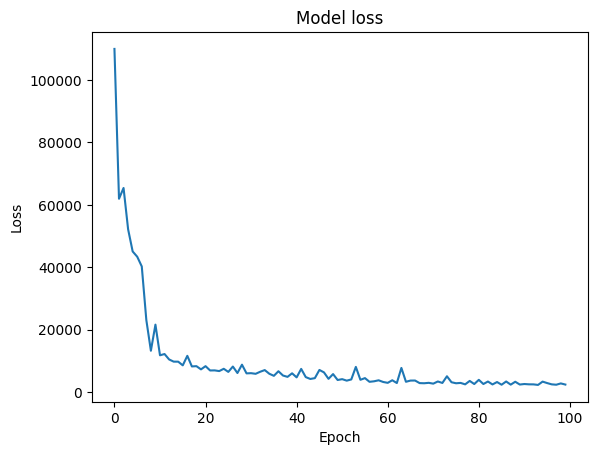

In [24]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [25]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

32/32 [==============================] - 1s 19ms/step


In [26]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [27]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 15.935643
C error per pixel [0, 255]: 12.449405


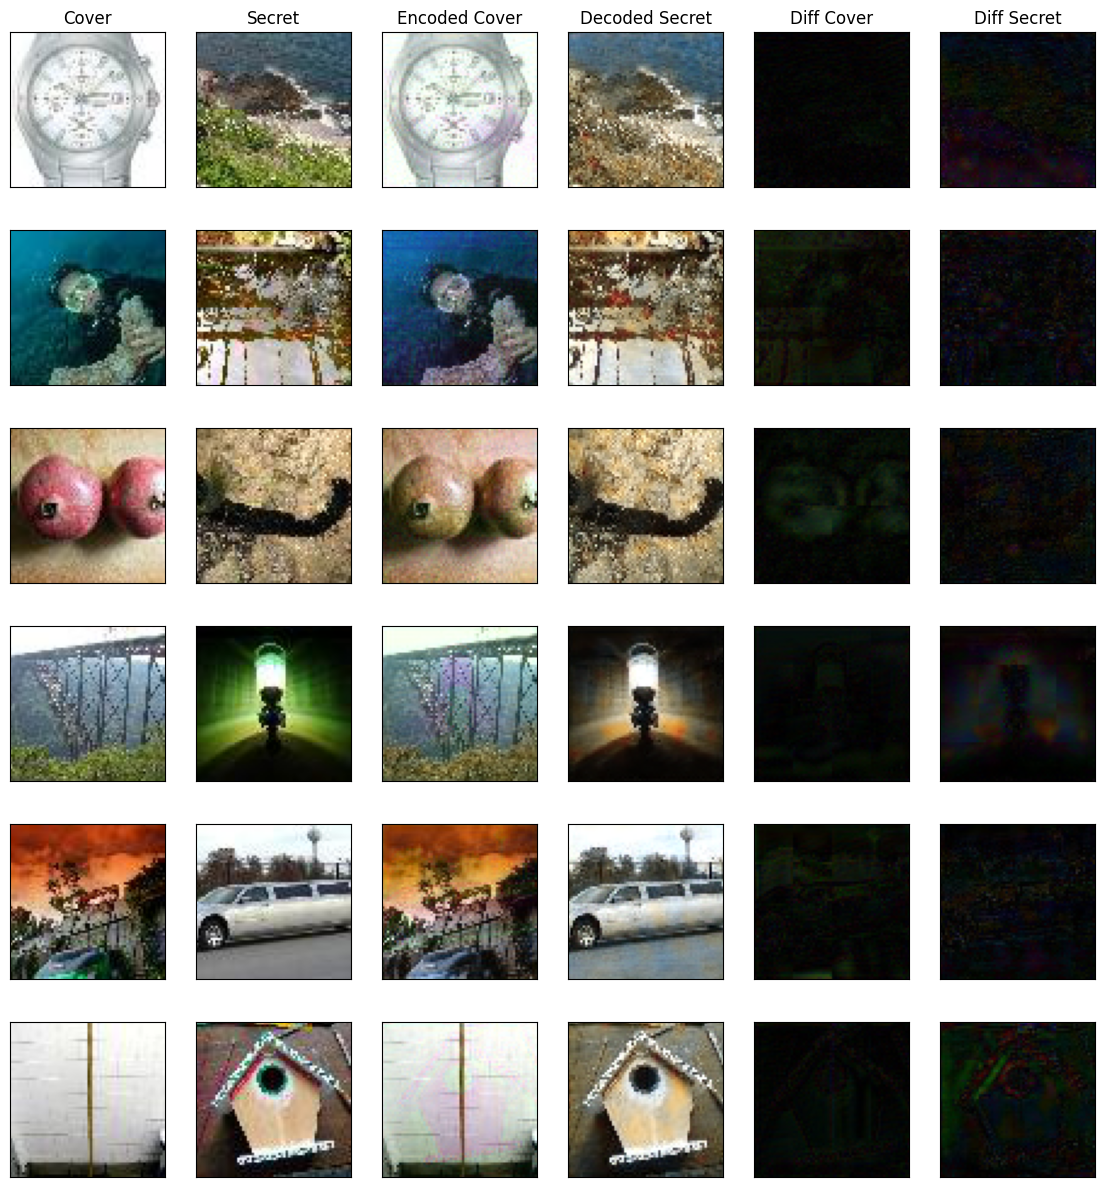

In [28]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()